In [4]:
import numpy as np
import meshio
import torch
import tensorflow.compat.v1 as tf

from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import pandas as pd
import os
import time
from IPython.lib.display import isdir
import random
import matplotlib.pyplot as plt
import copy
from matplotlib import tri as mtri
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from models_duibishiyan import *
from poolings_duibishiyan import *
from bubble_processing_duibishiyan import *

In [5]:
number_trajectories=1
number_ts=200   #400
satart_number_ts=50
per_t=1     #在编码和解码的时候每五个用的点是一样的
dt=0.1
batch_size = 25

In [6]:
SEED = 123
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)        #Python


epochs = 200

device = 'cuda' if torch.cuda.is_available() else 'cpu'    #cuda

file_path= '/root/data1/bubble_EMD/meshgraphnets_miniset1251traj50200ts_vis.pt'
dataset = torch.load(file_path)
print(len(dataset))
#EDstats_list = get_EDstats(dataset)
[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = torch.load('/root/data1/bubble_EMD/EDstats_list.pt')

(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))

train_size=7        #改
train_loader = DataLoader(dataset[:train_size], shuffle=False)
valid_loader = DataLoader(dataset[train_size:], shuffle=False)#分一下训练数据和验证数据
num=int(dataset[:train_size][0].x.shape[0]/(per_t*batch_size))
print(num)#3718
sample = dataset[:train_size][0]
print(sample)
in_channels_node = sample.x.shape[1]
in_channels_edge = sample.edge_attr.shape[1]
hidden_channels = 32  #22
out_channels = in_channels_node
batch_size =25       #改
n_mlp_encode = 3
n_mlp_mp = 3

n_mp_down_topk = [1,1,1,1]
n_mp_up_topk = [1,1,1,2]
pool_ratios = [2700,2000,1400]#[1./2.]

#n_mp_down_topk = [1,1,1]
#n_mp_up_topk = [1,1,2]
#pool_ratios = [2200,1400]#[1./2.]
n_mp_down_enc = [3]#3
n_mp_up_enc = []
lengthscales_enc = []
n_mp_down_dec = [2,1,1]
n_mp_up_dec = [1,2]
lengthscales_dec = [0.5,1]
interp = 'learned'
act = F.elu
param_sharing = False
bounding_box = []
if len(lengthscales_dec) > 0:
        x_lo = sample.mesh_pos[:num,0].min() - lengthscales_dec[0]/2
        x_hi = sample.mesh_pos[:num,0].max() + lengthscales_dec[0]/2
        y_lo = sample.mesh_pos[:num,1].min() - lengthscales_dec[0]/2
        y_hi = sample.mesh_pos[:num,1].max() + lengthscales_dec[0]/2
        bounding_box = [x_lo.cpu().item(), x_hi.cpu().item(), y_lo.cpu().item(), y_hi.cpu().item()]

RuntimeError: CUDA error: out of memory

In [ ]:

model = model_1_GNN_TopK(
                in_channels_node,
                in_channels_edge,
                hidden_channels,
                out_channels,
                n_mlp_encode,
                n_mlp_mp,
                n_mp_down_topk,
                n_mp_up_topk,
                pool_ratios,
                n_mp_down_enc,
                n_mp_up_enc,
                n_mp_down_dec,
                n_mp_up_dec,
                lengthscales_enc,
                lengthscales_dec,
                bounding_box,
                interp,
                act,
                param_sharing,
                name='gnn_topk')
model.to(device)
model.load_state_dict(torch.load('/root/data1/bubble_duibishiyan/model_1_ED_state_dict.pt'), strict=False)
train_hist, test_hist=model_1_train(epochs, model, train_loader, valid_loader,per_t,batch_size,EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)

Training:   0%|          | 1/200 [00:28<1:34:30, 28.50s/Epochs]

Epoch: 0000,	Train mse: 0.38150394,	Train_RMSE: 0.59681310,	Train_acc: 0.59626335,	Test mse: 0.38694268,	Time: 28.49605465s


Training:   1%|          | 2/200 [00:56<1:32:08, 27.92s/Epochs]

Epoch: 0001,	Train mse: 0.33043372,	Train_RMSE: 0.57415501,	Train_acc: 0.57426065,	Test mse: 0.24822536,	Time: 27.52111530s


Training:   2%|▏         | 3/200 [01:23<1:30:58, 27.71s/Epochs]

Epoch: 0002,	Train mse: 0.22676803,	Train_RMSE: 0.47581391,	Train_acc: 0.47586709,	Test mse: 0.18877581,	Time: 27.45390368s


Training:   2%|▏         | 4/200 [01:50<1:30:13, 27.62s/Epochs]

Epoch: 0003,	Train mse: 0.17192753,	Train_RMSE: 0.41434931,	Train_acc: 0.41438487,	Test mse: 0.19184639,	Time: 27.47641826s


Training:   2%|▎         | 5/200 [02:19<1:30:18, 27.79s/Epochs]

Epoch: 0004,	Train mse: 0.17975552,	Train_RMSE: 0.42374544,	Train_acc: 0.42376766,	Test mse: 0.16723156,	Time: 28.08867669s


Training:   3%|▎         | 6/200 [02:47<1:30:09, 27.89s/Epochs]

Epoch: 0005,	Train mse: 0.14833792,	Train_RMSE: 0.38482797,	Train_acc: 0.38487500,	Test mse: 0.12982787,	Time: 28.06908870s


Training:   4%|▎         | 7/200 [03:15<1:29:55, 27.95s/Epochs]

Epoch: 0006,	Train mse: 0.11669951,	Train_RMSE: 0.34144838,	Train_acc: 0.34149536,	Test mse: 0.10313179,	Time: 28.09177709s


Training:   4%|▍         | 8/200 [03:43<1:29:29, 27.96s/Epochs]

Epoch: 0007,	Train mse: 0.11361891,	Train_RMSE: 0.33561705,	Train_acc: 0.33553949,	Test mse: 0.11919262,	Time: 27.98476148s


Training:   4%|▍         | 9/200 [04:10<1:28:34, 27.83s/Epochs]

Epoch: 0008,	Train mse: 0.10929491,	Train_RMSE: 0.33051752,	Train_acc: 0.33055431,	Test mse: 0.10085548,	Time: 27.51792955s


Training:   5%|▌         | 10/200 [04:38<1:27:58, 27.78s/Epochs]

Epoch: 0009,	Train mse: 0.09671316,	Train_RMSE: 0.31096067,	Train_acc: 0.31098053,	Test mse: 0.08706519,	Time: 27.67588401s


Training:   6%|▌         | 11/200 [05:06<1:27:28, 27.77s/Epochs]

Epoch: 0010,	Train mse: 0.08461157,	Train_RMSE: 0.29085661,	Train_acc: 0.29086599,	Test mse: 0.07884628,	Time: 27.74262547s


Training:   6%|▌         | 12/200 [05:34<1:27:07, 27.80s/Epochs]

Epoch: 0011,	Train mse: 0.07709720,	Train_RMSE: 0.27765922,	Train_acc: 0.27766773,	Test mse: 0.07332812,	Time: 27.88487720s


Training:   6%|▋         | 13/200 [06:02<1:27:11, 27.98s/Epochs]

Epoch: 0012,	Train mse: 0.07262773,	Train_RMSE: 0.26947967,	Train_acc: 0.26949012,	Test mse: 0.06863575,	Time: 28.37251806s


Training:   7%|▋         | 14/200 [06:30<1:26:28, 27.90s/Epochs]

Epoch: 0013,	Train mse: 0.07006673,	Train_RMSE: 0.26458178,	Train_acc: 0.26457494,	Test mse: 0.06629901,	Time: 27.70430970s


Training:   8%|▊         | 15/200 [06:58<1:26:10, 27.95s/Epochs]

Epoch: 0014,	Train mse: 0.06732257,	Train_RMSE: 0.25941470,	Train_acc: 0.25942373,	Test mse: 0.06171346,	Time: 28.06132436s


Training:   8%|▊         | 16/200 [07:25<1:25:33, 27.90s/Epochs]

Epoch: 0015,	Train mse: 0.06406633,	Train_RMSE: 0.25306853,	Train_acc: 0.25306895,	Test mse: 0.05861484,	Time: 27.79343987s


Training:   8%|▊         | 17/200 [07:53<1:24:38, 27.75s/Epochs]

Epoch: 0016,	Train mse: 0.05991025,	Train_RMSE: 0.24472790,	Train_acc: 0.24473466,	Test mse: 0.05966293,	Time: 27.39799619s


Training:   9%|▉         | 18/200 [08:20<1:23:54, 27.66s/Epochs]

Epoch: 0017,	Train mse: 0.07512258,	Train_RMSE: 0.27308977,	Train_acc: 0.27306947,	Test mse: 0.06647476,	Time: 27.45592690s


Training:  10%|▉         | 19/200 [08:48<1:23:33, 27.70s/Epochs]

Epoch: 0018,	Train mse: 0.06495534,	Train_RMSE: 0.25477426,	Train_acc: 0.25478515,	Test mse: 0.06411131,	Time: 27.78503656s


Training:  10%|█         | 20/200 [09:16<1:23:01, 27.67s/Epochs]

Epoch: 0019,	Train mse: 0.06186388,	Train_RMSE: 0.24862738,	Train_acc: 0.24864519,	Test mse: 0.05839330,	Time: 27.60909772s


Training:  10%|█         | 21/200 [09:43<1:22:16, 27.58s/Epochs]

Epoch: 0020,	Train mse: 0.05616639,	Train_RMSE: 0.23694619,	Train_acc: 0.23696345,	Test mse: 0.04977434,	Time: 27.35331225s


Training:  11%|█         | 22/200 [10:11<1:21:59, 27.64s/Epochs]

Epoch: 0021,	Train mse: 0.05330467,	Train_RMSE: 0.23083388,	Train_acc: 0.23083857,	Test mse: 0.05386576,	Time: 27.78293085s


Training:  12%|█▏        | 23/200 [10:38<1:21:24, 27.59s/Epochs]

Epoch: 0022,	Train mse: 0.05036999,	Train_RMSE: 0.22433033,	Train_acc: 0.22435297,	Test mse: 0.04500328,	Time: 27.48733687s


Training:  12%|█▏        | 24/200 [11:06<1:20:44, 27.52s/Epochs]

Epoch: 0023,	Train mse: 0.04565198,	Train_RMSE: 0.21363516,	Train_acc: 0.21364017,	Test mse: 0.04471737,	Time: 27.35580063s


Training:  12%|█▎        | 25/200 [11:33<1:20:24, 27.57s/Epochs]

Epoch: 0024,	Train mse: 0.04376900,	Train_RMSE: 0.20916668,	Train_acc: 0.20917897,	Test mse: 0.04161036,	Time: 27.66679835s


Training:  13%|█▎        | 26/200 [12:01<1:19:47, 27.52s/Epochs]

Epoch: 0025,	Train mse: 0.05103137,	Train_RMSE: 0.22488071,	Train_acc: 0.22482343,	Test mse: 0.06767634,	Time: 27.39251328s


Training:  14%|█▎        | 27/200 [12:29<1:19:38, 27.62s/Epochs]

Epoch: 0026,	Train mse: 0.07150952,	Train_RMSE: 0.26704377,	Train_acc: 0.26704141,	Test mse: 0.05435005,	Time: 27.86015010s


Training:  14%|█▍        | 28/200 [12:56<1:19:10, 27.62s/Epochs]

Epoch: 0027,	Train mse: 0.06204352,	Train_RMSE: 0.24876309,	Train_acc: 0.24875465,	Test mse: 0.05961411,	Time: 27.61217332s


Training:  14%|█▍        | 29/200 [13:23<1:18:23, 27.50s/Epochs]

Epoch: 0028,	Train mse: 0.05394104,	Train_RMSE: 0.23190362,	Train_acc: 0.23193868,	Test mse: 0.04407554,	Time: 27.23325086s
Epoch    29: reducing learning rate of group 0 to 5.0000e-04.


Training:  15%|█▌        | 30/200 [13:51<1:17:57, 27.51s/Epochs]

Epoch: 0029,	Train mse: 0.04420380,	Train_RMSE: 0.21022059,	Train_acc: 0.21022888,	Test mse: 0.04294413,	Time: 27.53289175s


Training:  16%|█▌        | 31/200 [14:18<1:17:10, 27.40s/Epochs]

Epoch: 0030,	Train mse: 0.04187184,	Train_RMSE: 0.20456524,	Train_acc: 0.20457084,	Test mse: 0.03907357,	Time: 27.13372612s


Training:  16%|█▌        | 32/200 [14:46<1:16:49, 27.44s/Epochs]

Epoch: 0031,	Train mse: 0.03945272,	Train_RMSE: 0.19858673,	Train_acc: 0.19859038,	Test mse: 0.03802840,	Time: 27.52956605s


Training:  16%|█▋        | 33/200 [15:13<1:16:10, 27.37s/Epochs]

Epoch: 0032,	Train mse: 0.03816769,	Train_RMSE: 0.19533030,	Train_acc: 0.19533604,	Test mse: 0.03640286,	Time: 27.20166850s


Training:  17%|█▋        | 34/200 [15:41<1:15:55, 27.44s/Epochs]

Epoch: 0033,	Train mse: 0.03688599,	Train_RMSE: 0.19201839,	Train_acc: 0.19201998,	Test mse: 0.03473327,	Time: 27.60958743s


Training:  18%|█▊        | 35/200 [16:08<1:15:40, 27.52s/Epochs]

Epoch: 0034,	Train mse: 0.03562838,	Train_RMSE: 0.18870684,	Train_acc: 0.18870707,	Test mse: 0.03387354,	Time: 27.69719219s


Training:  18%|█▊        | 36/200 [16:36<1:15:18, 27.55s/Epochs]

Epoch: 0035,	Train mse: 0.03459964,	Train_RMSE: 0.18596239,	Train_acc: 0.18596263,	Test mse: 0.03309933,	Time: 27.63067746s


Training:  18%|█▊        | 37/200 [17:03<1:14:49, 27.54s/Epochs]

Epoch: 0036,	Train mse: 0.03371513,	Train_RMSE: 0.18355307,	Train_acc: 0.18355401,	Test mse: 0.03249262,	Time: 27.50958395s


Training:  19%|█▉        | 38/200 [17:31<1:14:22, 27.54s/Epochs]

Epoch: 0037,	Train mse: 0.03312691,	Train_RMSE: 0.18192550,	Train_acc: 0.18192701,	Test mse: 0.03226803,	Time: 27.55077600s


Training:  20%|█▉        | 39/200 [17:58<1:13:55, 27.55s/Epochs]

Epoch: 0038,	Train mse: 0.03280841,	Train_RMSE: 0.18106457,	Train_acc: 0.18106541,	Test mse: 0.03138880,	Time: 27.55785298s


Training:  20%|██        | 40/200 [18:26<1:13:26, 27.54s/Epochs]

Epoch: 0039,	Train mse: 0.03218619,	Train_RMSE: 0.17936199,	Train_acc: 0.17936179,	Test mse: 0.03032869,	Time: 27.52582169s


Training:  20%|██        | 41/200 [18:54<1:13:16, 27.65s/Epochs]

Epoch: 0040,	Train mse: 0.03095167,	Train_RMSE: 0.17587493,	Train_acc: 0.17587534,	Test mse: 0.02951678,	Time: 27.89364171s


Training:  21%|██        | 42/200 [19:22<1:12:50, 27.66s/Epochs]

Epoch: 0041,	Train mse: 0.03022599,	Train_RMSE: 0.17379358,	Train_acc: 0.17379364,	Test mse: 0.02914071,	Time: 27.68049741s


Training:  22%|██▏       | 43/200 [19:49<1:12:08, 27.57s/Epochs]

Epoch: 0042,	Train mse: 0.02985114,	Train_RMSE: 0.17271309,	Train_acc: 0.17271350,	Test mse: 0.02858131,	Time: 27.35566640s


Training:  22%|██▏       | 44/200 [20:16<1:11:40, 27.56s/Epochs]

Epoch: 0043,	Train mse: 0.02947584,	Train_RMSE: 0.17160876,	Train_acc: 0.17160827,	Test mse: 0.02775697,	Time: 27.55256009s


Training:  22%|██▎       | 45/200 [20:44<1:11:08, 27.54s/Epochs]

Epoch: 0044,	Train mse: 0.02928211,	Train_RMSE: 0.17101990,	Train_acc: 0.17101279,	Test mse: 0.02717442,	Time: 27.48064065s


Training:  23%|██▎       | 46/200 [21:11<1:10:40, 27.53s/Epochs]

Epoch: 0045,	Train mse: 0.02904211,	Train_RMSE: 0.17029083,	Train_acc: 0.17027931,	Test mse: 0.02818358,	Time: 27.51805520s


Training:  24%|██▎       | 47/200 [21:39<1:10:25, 27.62s/Epochs]

Epoch: 0046,	Train mse: 0.02880501,	Train_RMSE: 0.16959409,	Train_acc: 0.16958706,	Test mse: 0.02796611,	Time: 27.81954408s


Training:  24%|██▍       | 48/200 [22:07<1:09:57, 27.62s/Epochs]

Epoch: 0047,	Train mse: 0.02825456,	Train_RMSE: 0.16798128,	Train_acc: 0.16797516,	Test mse: 0.02828803,	Time: 27.60065770s


Training:  24%|██▍       | 49/200 [22:34<1:09:14, 27.51s/Epochs]

Epoch: 0048,	Train mse: 0.02962149,	Train_RMSE: 0.17193109,	Train_acc: 0.17191465,	Test mse: 0.03021730,	Time: 27.27843189s
Epoch    49: reducing learning rate of group 0 to 2.5000e-04.


Training:  25%|██▌       | 50/200 [23:02<1:08:48, 27.52s/Epochs]

Epoch: 0049,	Train mse: 0.02907352,	Train_RMSE: 0.17036154,	Train_acc: 0.17036396,	Test mse: 0.02886971,	Time: 27.53385329s


Training:  26%|██▌       | 51/200 [23:30<1:08:46, 27.69s/Epochs]

Epoch: 0050,	Train mse: 0.02844811,	Train_RMSE: 0.16857308,	Train_acc: 0.16856883,	Test mse: 0.02757019,	Time: 28.09470391s


Training:  26%|██▌       | 52/200 [23:58<1:08:28, 27.76s/Epochs]

Epoch: 0051,	Train mse: 0.02763357,	Train_RMSE: 0.16614024,	Train_acc: 0.16613564,	Test mse: 0.02640002,	Time: 27.90268040s


Training:  26%|██▋       | 53/200 [24:25<1:07:58, 27.74s/Epochs]

Epoch: 0052,	Train mse: 0.02686676,	Train_RMSE: 0.16381727,	Train_acc: 0.16380855,	Test mse: 0.02575257,	Time: 27.70427752s


Training:  27%|██▋       | 54/200 [24:53<1:07:32, 27.76s/Epochs]

Epoch: 0053,	Train mse: 0.02669543,	Train_RMSE: 0.16329567,	Train_acc: 0.16328685,	Test mse: 0.02575967,	Time: 27.78671026s


Training:  28%|██▊       | 55/200 [25:20<1:06:41, 27.60s/Epochs]

Epoch: 0054,	Train mse: 0.02649541,	Train_RMSE: 0.16268208,	Train_acc: 0.16267529,	Test mse: 0.02543697,	Time: 27.22336745s


Training:  28%|██▊       | 56/200 [25:48<1:06:00, 27.51s/Epochs]

Epoch: 0055,	Train mse: 0.02623363,	Train_RMSE: 0.16187650,	Train_acc: 0.16186927,	Test mse: 0.02514962,	Time: 27.29295301s


Training:  28%|██▊       | 57/200 [26:15<1:05:32, 27.50s/Epochs]

Epoch: 0056,	Train mse: 0.02607890,	Train_RMSE: 0.16140149,	Train_acc: 0.16139476,	Test mse: 0.02499669,	Time: 27.48974848s


Training:  29%|██▉       | 58/200 [26:43<1:05:16, 27.58s/Epochs]

Epoch: 0057,	Train mse: 0.02606606,	Train_RMSE: 0.16136057,	Train_acc: 0.16135238,	Test mse: 0.02506716,	Time: 27.77319932s


Training:  30%|██▉       | 59/200 [27:10<1:04:38, 27.51s/Epochs]

Epoch: 0058,	Train mse: 0.02610382,	Train_RMSE: 0.16146440,	Train_acc: 0.16145414,	Test mse: 0.02530635,	Time: 27.33468246s


Training:  30%|███       | 60/200 [27:37<1:03:53, 27.38s/Epochs]

Epoch: 0059,	Train mse: 0.02601150,	Train_RMSE: 0.16115260,	Train_acc: 0.16114178,	Test mse: 0.02580264,	Time: 27.08855438s


Training:  30%|███       | 61/200 [28:05<1:03:18, 27.33s/Epochs]

Epoch: 0060,	Train mse: 0.02593741,	Train_RMSE: 0.16092152,	Train_acc: 0.16091162,	Test mse: 0.02590575,	Time: 27.19380283s
Epoch    61: reducing learning rate of group 0 to 1.2500e-04.


Training:  31%|███       | 62/200 [28:32<1:02:45, 27.29s/Epochs]

Epoch: 0061,	Train mse: 0.02579897,	Train_RMSE: 0.16050750,	Train_acc: 0.16049990,	Test mse: 0.02537477,	Time: 27.19333720s


Training:  32%|███▏      | 63/200 [28:59<1:02:21, 27.31s/Epochs]

Epoch: 0062,	Train mse: 0.02563548,	Train_RMSE: 0.15999682,	Train_acc: 0.15998839,	Test mse: 0.02533803,	Time: 27.35192275s


Training:  32%|███▏      | 64/200 [29:27<1:02:04, 27.39s/Epochs]

Epoch: 0063,	Train mse: 0.02565725,	Train_RMSE: 0.16007677,	Train_acc: 0.16006787,	Test mse: 0.02519717,	Time: 27.57195544s


Training:  32%|███▎      | 65/200 [29:54<1:01:29, 27.33s/Epochs]

Epoch: 0064,	Train mse: 0.02552950,	Train_RMSE: 0.15966606,	Train_acc: 0.15965667,	Test mse: 0.02500017,	Time: 27.18811917s
Epoch    65: reducing learning rate of group 0 to 6.2500e-05.


Training:  33%|███▎      | 66/200 [30:21<1:00:54, 27.27s/Epochs]

Epoch: 0065,	Train mse: 0.02543407,	Train_RMSE: 0.15938395,	Train_acc: 0.15937632,	Test mse: 0.02476002,	Time: 27.13408875s


Training:  34%|███▎      | 67/200 [30:48<1:00:23, 27.24s/Epochs]

Epoch: 0066,	Train mse: 0.02521760,	Train_RMSE: 0.15870569,	Train_acc: 0.15869823,	Test mse: 0.02472055,	Time: 27.17935228s


Training:  34%|███▍      | 68/200 [31:16<59:59, 27.27s/Epochs]  

Epoch: 0067,	Train mse: 0.02526716,	Train_RMSE: 0.15886191,	Train_acc: 0.15885420,	Test mse: 0.02491451,	Time: 27.33178258s


Training:  34%|███▍      | 69/200 [31:43<59:37, 27.31s/Epochs]

Epoch: 0068,	Train mse: 0.02526798,	Train_RMSE: 0.15887247,	Train_acc: 0.15886566,	Test mse: 0.02472416,	Time: 27.39491820s


Training:  35%|███▌      | 70/200 [32:10<59:17, 27.37s/Epochs]

Epoch: 0069,	Train mse: 0.02520231,	Train_RMSE: 0.15866397,	Train_acc: 0.15865701,	Test mse: 0.02462843,	Time: 27.49695921s


Training:  36%|███▌      | 71/200 [32:38<59:05, 27.48s/Epochs]

Epoch: 0070,	Train mse: 0.02523426,	Train_RMSE: 0.15876462,	Train_acc: 0.15875788,	Test mse: 0.02473002,	Time: 27.76051354s


Training:  36%|███▌      | 72/200 [33:06<58:32, 27.44s/Epochs]

Epoch: 0071,	Train mse: 0.02521829,	Train_RMSE: 0.15871860,	Train_acc: 0.15871266,	Test mse: 0.02462908,	Time: 27.34672165s


Training:  36%|███▋      | 73/200 [33:33<58:16, 27.53s/Epochs]

Epoch: 0072,	Train mse: 0.02515574,	Train_RMSE: 0.15852385,	Train_acc: 0.15851730,	Test mse: 0.02465362,	Time: 27.72974539s


Training:  37%|███▋      | 74/200 [34:01<57:48, 27.53s/Epochs]

Epoch: 0073,	Train mse: 0.02513961,	Train_RMSE: 0.15847144,	Train_acc: 0.15846495,	Test mse: 0.02458881,	Time: 27.52428722s


Training:  38%|███▊      | 75/200 [34:29<57:32, 27.62s/Epochs]

Epoch: 0074,	Train mse: 0.02507004,	Train_RMSE: 0.15825173,	Train_acc: 0.15824518,	Test mse: 0.02446483,	Time: 27.83604598s


Training:  38%|███▊      | 76/200 [34:56<57:07, 27.64s/Epochs]

Epoch: 0075,	Train mse: 0.02500482,	Train_RMSE: 0.15804271,	Train_acc: 0.15803592,	Test mse: 0.02433288,	Time: 27.69729280s


Training:  38%|███▊      | 77/200 [35:24<56:33, 27.59s/Epochs]

Epoch: 0076,	Train mse: 0.02497897,	Train_RMSE: 0.15795922,	Train_acc: 0.15795283,	Test mse: 0.02418981,	Time: 27.45338011s


Training:  39%|███▉      | 78/200 [35:52<56:14, 27.66s/Epochs]

Epoch: 0077,	Train mse: 0.02492513,	Train_RMSE: 0.15778850,	Train_acc: 0.15778203,	Test mse: 0.02409065,	Time: 27.81237864s


Training:  40%|███▉      | 79/200 [36:19<55:37, 27.58s/Epochs]

Epoch: 0078,	Train mse: 0.02486733,	Train_RMSE: 0.15760247,	Train_acc: 0.15759574,	Test mse: 0.02402675,	Time: 27.41156673s


Training:  40%|████      | 80/200 [36:47<55:05, 27.55s/Epochs]

Epoch: 0079,	Train mse: 0.02481024,	Train_RMSE: 0.15742116,	Train_acc: 0.15741435,	Test mse: 0.02393856,	Time: 27.45659542s


Training:  40%|████      | 81/200 [37:14<54:42, 27.58s/Epochs]

Epoch: 0080,	Train mse: 0.02473169,	Train_RMSE: 0.15716813,	Train_acc: 0.15716098,	Test mse: 0.02384802,	Time: 27.66724658s


Training:  41%|████      | 82/200 [37:42<54:07, 27.52s/Epochs]

Epoch: 0081,	Train mse: 0.02465975,	Train_RMSE: 0.15693981,	Train_acc: 0.15693259,	Test mse: 0.02373157,	Time: 27.38638473s


Training:  42%|████▏     | 83/200 [38:09<53:31, 27.45s/Epochs]

Epoch: 0082,	Train mse: 0.02458882,	Train_RMSE: 0.15671348,	Train_acc: 0.15670605,	Test mse: 0.02370346,	Time: 27.26956010s


Training:  42%|████▏     | 84/200 [38:36<52:57, 27.40s/Epochs]

Epoch: 0083,	Train mse: 0.02450707,	Train_RMSE: 0.15645018,	Train_acc: 0.15644281,	Test mse: 0.02363640,	Time: 27.27296495s


Training:  42%|████▎     | 85/200 [39:04<52:31, 27.41s/Epochs]

Epoch: 0084,	Train mse: 0.02442984,	Train_RMSE: 0.15620226,	Train_acc: 0.15619501,	Test mse: 0.02355596,	Time: 27.43230009s


Training:  43%|████▎     | 86/200 [39:31<51:59, 27.37s/Epochs]

Epoch: 0085,	Train mse: 0.02437464,	Train_RMSE: 0.15602526,	Train_acc: 0.15601777,	Test mse: 0.02347999,	Time: 27.27413416s


Training:  44%|████▎     | 87/200 [39:58<51:27, 27.32s/Epochs]

Epoch: 0086,	Train mse: 0.02429987,	Train_RMSE: 0.15578610,	Train_acc: 0.15577872,	Test mse: 0.02342240,	Time: 27.21094155s


Training:  44%|████▍     | 88/200 [40:25<50:58, 27.31s/Epochs]

Epoch: 0087,	Train mse: 0.02424251,	Train_RMSE: 0.15560482,	Train_acc: 0.15559742,	Test mse: 0.02335706,	Time: 27.28454733s


Training:  44%|████▍     | 89/200 [40:53<50:52, 27.50s/Epochs]

Epoch: 0088,	Train mse: 0.02418209,	Train_RMSE: 0.15541030,	Train_acc: 0.15540299,	Test mse: 0.02327688,	Time: 27.93701243s


Training:  45%|████▌     | 90/200 [41:21<50:30, 27.55s/Epochs]

Epoch: 0089,	Train mse: 0.02410619,	Train_RMSE: 0.15516569,	Train_acc: 0.15515827,	Test mse: 0.02322629,	Time: 27.67930508s


Training:  46%|████▌     | 91/200 [41:49<50:11, 27.63s/Epochs]

Epoch: 0090,	Train mse: 0.02405140,	Train_RMSE: 0.15498914,	Train_acc: 0.15498166,	Test mse: 0.02313069,	Time: 27.79831600s


Training:  46%|████▌     | 92/200 [42:16<49:43, 27.63s/Epochs]

Epoch: 0091,	Train mse: 0.02399786,	Train_RMSE: 0.15481712,	Train_acc: 0.15480947,	Test mse: 0.02311157,	Time: 27.62075591s


Training:  46%|████▋     | 93/200 [42:44<49:20, 27.67s/Epochs]

Epoch: 0092,	Train mse: 0.02393094,	Train_RMSE: 0.15460187,	Train_acc: 0.15459424,	Test mse: 0.02304253,	Time: 27.75870466s


Training:  47%|████▋     | 94/200 [43:12<48:57, 27.71s/Epochs]

Epoch: 0093,	Train mse: 0.02386776,	Train_RMSE: 0.15439668,	Train_acc: 0.15438896,	Test mse: 0.02299325,	Time: 27.82327342s


Training:  48%|████▊     | 95/200 [43:39<48:22, 27.64s/Epochs]

Epoch: 0094,	Train mse: 0.02381940,	Train_RMSE: 0.15424022,	Train_acc: 0.15423301,	Test mse: 0.02291160,	Time: 27.46366096s


Training:  48%|████▊     | 96/200 [44:07<48:01, 27.70s/Epochs]

Epoch: 0095,	Train mse: 0.02376514,	Train_RMSE: 0.15406498,	Train_acc: 0.15405789,	Test mse: 0.02288612,	Time: 27.84719205s


Training:  48%|████▊     | 97/200 [44:35<47:30, 27.68s/Epochs]

Epoch: 0096,	Train mse: 0.02369893,	Train_RMSE: 0.15385054,	Train_acc: 0.15384363,	Test mse: 0.02287845,	Time: 27.61852503s


Training:  49%|████▉     | 98/200 [45:02<46:57, 27.62s/Epochs]

Epoch: 0097,	Train mse: 0.02365211,	Train_RMSE: 0.15369932,	Train_acc: 0.15369257,	Test mse: 0.02282157,	Time: 27.48154068s


Training:  50%|████▉     | 99/200 [45:30<46:25, 27.58s/Epochs]

Epoch: 0098,	Train mse: 0.02359456,	Train_RMSE: 0.15351235,	Train_acc: 0.15350573,	Test mse: 0.02285326,	Time: 27.48584104s


Training:  50%|█████     | 100/200 [45:57<45:55, 27.55s/Epochs]

Epoch: 0099,	Train mse: 0.02353739,	Train_RMSE: 0.15332585,	Train_acc: 0.15331909,	Test mse: 0.02275074,	Time: 27.49280453s


Training:  50%|█████     | 101/200 [46:25<45:38, 27.66s/Epochs]

Epoch: 0100,	Train mse: 0.02348715,	Train_RMSE: 0.15316308,	Train_acc: 0.15315625,	Test mse: 0.02272114,	Time: 27.90898848s


Training:  51%|█████     | 102/200 [46:53<45:07, 27.63s/Epochs]

Epoch: 0101,	Train mse: 0.02344324,	Train_RMSE: 0.15301922,	Train_acc: 0.15301231,	Test mse: 0.02264663,	Time: 27.55052876s


Training:  52%|█████▏    | 103/200 [47:21<44:43, 27.66s/Epochs]

Epoch: 0102,	Train mse: 0.02337774,	Train_RMSE: 0.15280594,	Train_acc: 0.15279889,	Test mse: 0.02256113,	Time: 27.73888540s


Training:  52%|█████▏    | 104/200 [47:48<44:18, 27.70s/Epochs]

Epoch: 0103,	Train mse: 0.02333417,	Train_RMSE: 0.15266038,	Train_acc: 0.15265319,	Test mse: 0.02249276,	Time: 27.77928042s


Training:  52%|█████▎    | 105/200 [48:16<43:52, 27.71s/Epochs]

Epoch: 0104,	Train mse: 0.02326364,	Train_RMSE: 0.15242915,	Train_acc: 0.15242213,	Test mse: 0.02240079,	Time: 27.73076296s


Training:  53%|█████▎    | 106/200 [48:44<43:29, 27.76s/Epochs]

Epoch: 0105,	Train mse: 0.02318660,	Train_RMSE: 0.15217625,	Train_acc: 0.15216920,	Test mse: 0.02232204,	Time: 27.86914730s


Training:  54%|█████▎    | 107/200 [49:12<43:03, 27.77s/Epochs]

Epoch: 0106,	Train mse: 0.02314901,	Train_RMSE: 0.15205368,	Train_acc: 0.15204674,	Test mse: 0.02227986,	Time: 27.81314230s


Training:  54%|█████▍    | 108/200 [49:39<42:21, 27.63s/Epochs]

Epoch: 0107,	Train mse: 0.02304981,	Train_RMSE: 0.15172712,	Train_acc: 0.15172012,	Test mse: 0.02219659,	Time: 27.27563095s


Training:  55%|█████▍    | 109/200 [50:06<41:46, 27.55s/Epochs]

Epoch: 0108,	Train mse: 0.02297938,	Train_RMSE: 0.15149461,	Train_acc: 0.15148765,	Test mse: 0.02213427,	Time: 27.36965442s


Training:  55%|█████▌    | 110/200 [50:34<41:19, 27.55s/Epochs]

Epoch: 0109,	Train mse: 0.02291336,	Train_RMSE: 0.15127664,	Train_acc: 0.15126970,	Test mse: 0.02207006,	Time: 27.56276965s


Training:  56%|█████▌    | 111/200 [51:02<40:53, 27.57s/Epochs]

Epoch: 0110,	Train mse: 0.02284473,	Train_RMSE: 0.15104843,	Train_acc: 0.15104143,	Test mse: 0.02197893,	Time: 27.58979940s


Training:  56%|█████▌    | 112/200 [51:29<40:28, 27.60s/Epochs]

Epoch: 0111,	Train mse: 0.02277869,	Train_RMSE: 0.15082937,	Train_acc: 0.15082248,	Test mse: 0.02190574,	Time: 27.67300606s


Training:  56%|█████▋    | 113/200 [51:57<40:02, 27.62s/Epochs]

Epoch: 0112,	Train mse: 0.02269880,	Train_RMSE: 0.15056524,	Train_acc: 0.15055810,	Test mse: 0.02187341,	Time: 27.66757607s


Training:  57%|█████▋    | 114/200 [52:25<39:40, 27.68s/Epochs]

Epoch: 0113,	Train mse: 0.02263758,	Train_RMSE: 0.15036260,	Train_acc: 0.15035562,	Test mse: 0.02179048,	Time: 27.80308771s


Training:  57%|█████▊    | 115/200 [52:52<39:08, 27.63s/Epochs]

Epoch: 0114,	Train mse: 0.02257491,	Train_RMSE: 0.15015277,	Train_acc: 0.15014571,	Test mse: 0.02171365,	Time: 27.53416348s


Training:  58%|█████▊    | 116/200 [53:20<38:44, 27.68s/Epochs]

Epoch: 0115,	Train mse: 0.02251487,	Train_RMSE: 0.14995268,	Train_acc: 0.14994554,	Test mse: 0.02163820,	Time: 27.77109075s


Training:  58%|█████▊    | 117/200 [53:48<38:15, 27.65s/Epochs]

Epoch: 0116,	Train mse: 0.02247034,	Train_RMSE: 0.14980256,	Train_acc: 0.14979525,	Test mse: 0.02156249,	Time: 27.59170461s


Training:  59%|█████▉    | 118/200 [54:15<37:43, 27.61s/Epochs]

Epoch: 0117,	Train mse: 0.02241008,	Train_RMSE: 0.14960238,	Train_acc: 0.14959505,	Test mse: 0.02152362,	Time: 27.49996328s


Training:  60%|█████▉    | 119/200 [54:43<37:16, 27.61s/Epochs]

Epoch: 0118,	Train mse: 0.02235154,	Train_RMSE: 0.14940709,	Train_acc: 0.14939964,	Test mse: 0.02149807,	Time: 27.60568619s


Training:  60%|██████    | 120/200 [55:10<36:50, 27.64s/Epochs]

Epoch: 0119,	Train mse: 0.02227988,	Train_RMSE: 0.14916682,	Train_acc: 0.14915943,	Test mse: 0.02142653,	Time: 27.70158339s


Training:  60%|██████    | 121/200 [55:39<36:34, 27.78s/Epochs]

Epoch: 0120,	Train mse: 0.02220811,	Train_RMSE: 0.14892636,	Train_acc: 0.14891872,	Test mse: 0.02135703,	Time: 28.11012030s


Training:  61%|██████    | 122/200 [56:06<36:05, 27.76s/Epochs]

Epoch: 0121,	Train mse: 0.02213763,	Train_RMSE: 0.14868940,	Train_acc: 0.14868192,	Test mse: 0.02128271,	Time: 27.71654058s


Training:  62%|██████▏   | 123/200 [56:34<35:41, 27.82s/Epochs]

Epoch: 0122,	Train mse: 0.02208441,	Train_RMSE: 0.14851064,	Train_acc: 0.14850317,	Test mse: 0.02122902,	Time: 27.94757462s


Training:  62%|██████▏   | 124/200 [57:02<35:06, 27.72s/Epochs]

Epoch: 0123,	Train mse: 0.02202687,	Train_RMSE: 0.14831588,	Train_acc: 0.14830859,	Test mse: 0.02120139,	Time: 27.48571515s


Training:  62%|██████▎   | 125/200 [57:29<34:28, 27.59s/Epochs]

Epoch: 0124,	Train mse: 0.02195227,	Train_RMSE: 0.14806482,	Train_acc: 0.14805740,	Test mse: 0.02114842,	Time: 27.27196097s


Training:  63%|██████▎   | 126/200 [57:56<33:58, 27.54s/Epochs]

Epoch: 0125,	Train mse: 0.02188783,	Train_RMSE: 0.14784798,	Train_acc: 0.14784069,	Test mse: 0.02108037,	Time: 27.43748307s


Training:  64%|██████▎   | 127/200 [58:24<33:27, 27.50s/Epochs]

Epoch: 0126,	Train mse: 0.02185817,	Train_RMSE: 0.14774871,	Train_acc: 0.14774199,	Test mse: 0.02100552,	Time: 27.39074230s


Training:  64%|██████▍   | 128/200 [58:51<32:57, 27.47s/Epochs]

Epoch: 0127,	Train mse: 0.02181582,	Train_RMSE: 0.14760558,	Train_acc: 0.14759877,	Test mse: 0.02088892,	Time: 27.40509272s


Training:  64%|██████▍   | 129/200 [59:19<32:33, 27.51s/Epochs]

Epoch: 0128,	Train mse: 0.02176381,	Train_RMSE: 0.14742931,	Train_acc: 0.14742275,	Test mse: 0.02080006,	Time: 27.60599399s


Training:  65%|██████▌   | 130/200 [59:47<32:09, 27.56s/Epochs]

Epoch: 0129,	Train mse: 0.02167947,	Train_RMSE: 0.14714034,	Train_acc: 0.14713386,	Test mse: 0.02070593,	Time: 27.67256427s


Training:  66%|██████▌   | 131/200 [1:00:14<31:49, 27.68s/Epochs]

Epoch: 0130,	Train mse: 0.02161383,	Train_RMSE: 0.14691850,	Train_acc: 0.14691196,	Test mse: 0.02064898,	Time: 27.94340682s


Training:  66%|██████▌   | 132/200 [1:00:42<31:19, 27.63s/Epochs]

Epoch: 0131,	Train mse: 0.02153397,	Train_RMSE: 0.14664272,	Train_acc: 0.14663623,	Test mse: 0.02056430,	Time: 27.53010225s


Training:  66%|██████▋   | 133/200 [1:01:10<30:54, 27.69s/Epochs]

Epoch: 0132,	Train mse: 0.02148126,	Train_RMSE: 0.14646313,	Train_acc: 0.14645655,	Test mse: 0.02049298,	Time: 27.80665565s


Training:  67%|██████▋   | 134/200 [1:01:37<30:21, 27.59s/Epochs]

Epoch: 0133,	Train mse: 0.02140279,	Train_RMSE: 0.14619462,	Train_acc: 0.14618817,	Test mse: 0.02043913,	Time: 27.37481403s


Training:  68%|██████▊   | 135/200 [1:02:04<29:45, 27.47s/Epochs]

Epoch: 0134,	Train mse: 0.02134512,	Train_RMSE: 0.14599833,	Train_acc: 0.14599180,	Test mse: 0.02035541,	Time: 27.18598485s


Training:  68%|██████▊   | 136/200 [1:02:32<29:12, 27.38s/Epochs]

Epoch: 0135,	Train mse: 0.02127902,	Train_RMSE: 0.14577287,	Train_acc: 0.14576648,	Test mse: 0.02030191,	Time: 27.17877984s


Training:  68%|██████▊   | 137/200 [1:02:59<28:47, 27.42s/Epochs]

Epoch: 0136,	Train mse: 0.02123057,	Train_RMSE: 0.14560733,	Train_acc: 0.14560108,	Test mse: 0.02028522,	Time: 27.51150393s


Training:  69%|██████▉   | 138/200 [1:03:27<28:38, 27.72s/Epochs]

Epoch: 0137,	Train mse: 0.02117457,	Train_RMSE: 0.14541410,	Train_acc: 0.14540789,	Test mse: 0.02023717,	Time: 28.40565443s


Training:  70%|██████▉   | 139/200 [1:03:55<28:07, 27.66s/Epochs]

Epoch: 0138,	Train mse: 0.02111203,	Train_RMSE: 0.14519805,	Train_acc: 0.14519179,	Test mse: 0.02020192,	Time: 27.53249073s


Training:  70%|███████   | 140/200 [1:04:23<27:37, 27.63s/Epochs]

Epoch: 0139,	Train mse: 0.02105412,	Train_RMSE: 0.14499812,	Train_acc: 0.14499199,	Test mse: 0.02017296,	Time: 27.53700495s


Training:  70%|███████   | 141/200 [1:04:50<27:08, 27.61s/Epochs]

Epoch: 0140,	Train mse: 0.02101007,	Train_RMSE: 0.14484518,	Train_acc: 0.14483903,	Test mse: 0.02013422,	Time: 27.57018685s


Training:  71%|███████   | 142/200 [1:05:18<26:39, 27.57s/Epochs]

Epoch: 0141,	Train mse: 0.02094393,	Train_RMSE: 0.14461745,	Train_acc: 0.14461127,	Test mse: 0.02006921,	Time: 27.47491241s


Training:  72%|███████▏  | 143/200 [1:05:45<26:09, 27.53s/Epochs]

Epoch: 0142,	Train mse: 0.02089991,	Train_RMSE: 0.14446581,	Train_acc: 0.14445989,	Test mse: 0.02002604,	Time: 27.44222522s


Training:  72%|███████▏  | 144/200 [1:06:12<25:33, 27.38s/Epochs]

Epoch: 0143,	Train mse: 0.02084042,	Train_RMSE: 0.14425942,	Train_acc: 0.14425352,	Test mse: 0.01996647,	Time: 27.02731133s


Training:  72%|███████▎  | 145/200 [1:06:39<25:05, 27.37s/Epochs]

Epoch: 0144,	Train mse: 0.02078320,	Train_RMSE: 0.14405942,	Train_acc: 0.14405356,	Test mse: 0.01993197,	Time: 27.32857823s


Training:  73%|███████▎  | 146/200 [1:07:07<24:42, 27.46s/Epochs]

Epoch: 0145,	Train mse: 0.02073036,	Train_RMSE: 0.14387585,	Train_acc: 0.14387003,	Test mse: 0.01983893,	Time: 27.67397380s


Training:  74%|███████▎  | 147/200 [1:07:35<24:18, 27.51s/Epochs]

Epoch: 0146,	Train mse: 0.02065743,	Train_RMSE: 0.14362356,	Train_acc: 0.14361760,	Test mse: 0.01971687,	Time: 27.63773108s


Training:  74%|███████▍  | 148/200 [1:08:02<23:53, 27.56s/Epochs]

Epoch: 0147,	Train mse: 0.02060815,	Train_RMSE: 0.14345015,	Train_acc: 0.14344400,	Test mse: 0.01965271,	Time: 27.67266273s


Training:  74%|███████▍  | 149/200 [1:08:30<23:28, 27.62s/Epochs]

Epoch: 0148,	Train mse: 0.02055018,	Train_RMSE: 0.14324816,	Train_acc: 0.14324208,	Test mse: 0.01960095,	Time: 27.74986267s


Training:  75%|███████▌  | 150/200 [1:08:59<23:14, 27.90s/Epochs]

Epoch: 0149,	Train mse: 0.02052739,	Train_RMSE: 0.14317154,	Train_acc: 0.14316587,	Test mse: 0.01952399,	Time: 28.54461122s


Training:  76%|███████▌  | 151/200 [1:09:27<22:49, 27.96s/Epochs]

Epoch: 0150,	Train mse: 0.02047495,	Train_RMSE: 0.14298853,	Train_acc: 0.14298292,	Test mse: 0.01950391,	Time: 28.09558773s


Training:  76%|███████▌  | 152/200 [1:09:54<22:15, 27.82s/Epochs]

Epoch: 0151,	Train mse: 0.02043472,	Train_RMSE: 0.14284759,	Train_acc: 0.14284216,	Test mse: 0.01944647,	Time: 27.48201489s


Training:  76%|███████▋  | 153/200 [1:10:22<21:45, 27.77s/Epochs]

Epoch: 0152,	Train mse: 0.02039641,	Train_RMSE: 0.14271350,	Train_acc: 0.14270794,	Test mse: 0.01940419,	Time: 27.66862345s


Training:  77%|███████▋  | 154/200 [1:10:50<21:15, 27.73s/Epochs]

Epoch: 0153,	Train mse: 0.02032737,	Train_RMSE: 0.14247075,	Train_acc: 0.14246532,	Test mse: 0.01935874,	Time: 27.63865924s


Training:  78%|███████▊  | 155/200 [1:11:17<20:45, 27.68s/Epochs]

Epoch: 0154,	Train mse: 0.02026769,	Train_RMSE: 0.14226189,	Train_acc: 0.14225641,	Test mse: 0.01929596,	Time: 27.55261064s


Training:  78%|███████▊  | 156/200 [1:11:45<20:16, 27.66s/Epochs]

Epoch: 0155,	Train mse: 0.02020524,	Train_RMSE: 0.14203982,	Train_acc: 0.14203423,	Test mse: 0.01933653,	Time: 27.60797453s


Training:  78%|███████▊  | 157/200 [1:12:12<19:47, 27.61s/Epochs]

Epoch: 0156,	Train mse: 0.02017423,	Train_RMSE: 0.14193236,	Train_acc: 0.14192678,	Test mse: 0.01927564,	Time: 27.48330355s


Training:  79%|███████▉  | 158/200 [1:12:40<19:16, 27.53s/Epochs]

Epoch: 0157,	Train mse: 0.02011506,	Train_RMSE: 0.14172361,	Train_acc: 0.14171797,	Test mse: 0.01921547,	Time: 27.35191441s


Training:  80%|███████▉  | 159/200 [1:13:08<18:54, 27.67s/Epochs]

Epoch: 0158,	Train mse: 0.02005114,	Train_RMSE: 0.14149668,	Train_acc: 0.14149097,	Test mse: 0.01919929,	Time: 27.97829556s


Training:  80%|████████  | 160/200 [1:13:36<18:30, 27.77s/Epochs]

Epoch: 0159,	Train mse: 0.02000603,	Train_RMSE: 0.14133825,	Train_acc: 0.14133275,	Test mse: 0.01911833,	Time: 28.00588465s


Training:  80%|████████  | 161/200 [1:14:04<18:05, 27.83s/Epochs]

Epoch: 0160,	Train mse: 0.01993916,	Train_RMSE: 0.14110020,	Train_acc: 0.14109468,	Test mse: 0.01908173,	Time: 27.95533180s


Training:  81%|████████  | 162/200 [1:14:32<17:39, 27.88s/Epochs]

Epoch: 0161,	Train mse: 0.01987390,	Train_RMSE: 0.14086779,	Train_acc: 0.14086212,	Test mse: 0.01902294,	Time: 27.99273539s


Training:  82%|████████▏ | 163/200 [1:14:59<17:06, 27.73s/Epochs]

Epoch: 0162,	Train mse: 0.01984084,	Train_RMSE: 0.14075195,	Train_acc: 0.14074638,	Test mse: 0.01896775,	Time: 27.39637542s


Training:  82%|████████▏ | 164/200 [1:15:26<16:35, 27.66s/Epochs]

Epoch: 0163,	Train mse: 0.01979688,	Train_RMSE: 0.14059584,	Train_acc: 0.14059022,	Test mse: 0.01891229,	Time: 27.47786570s


Training:  82%|████████▎ | 165/200 [1:15:54<16:06, 27.60s/Epochs]

Epoch: 0164,	Train mse: 0.01972177,	Train_RMSE: 0.14032465,	Train_acc: 0.14031884,	Test mse: 0.01887549,	Time: 27.47219372s


Training:  83%|████████▎ | 166/200 [1:16:21<15:36, 27.55s/Epochs]

Epoch: 0165,	Train mse: 0.01967435,	Train_RMSE: 0.14015547,	Train_acc: 0.14015001,	Test mse: 0.01882864,	Time: 27.42074347s


Training:  84%|████████▎ | 167/200 [1:16:49<15:10, 27.60s/Epochs]

Epoch: 0166,	Train mse: 0.01962392,	Train_RMSE: 0.13997540,	Train_acc: 0.13996993,	Test mse: 0.01877765,	Time: 27.71049047s


Training:  84%|████████▍ | 168/200 [1:17:17<14:46, 27.71s/Epochs]

Epoch: 0167,	Train mse: 0.01958551,	Train_RMSE: 0.13984015,	Train_acc: 0.13983469,	Test mse: 0.01873154,	Time: 27.96005106s


Training:  84%|████████▍ | 169/200 [1:17:45<14:18, 27.71s/Epochs]

Epoch: 0168,	Train mse: 0.01954410,	Train_RMSE: 0.13969201,	Train_acc: 0.13968654,	Test mse: 0.01869826,	Time: 27.71256113s


Training:  85%|████████▌ | 170/200 [1:18:12<13:48, 27.60s/Epochs]

Epoch: 0169,	Train mse: 0.01950304,	Train_RMSE: 0.13954490,	Train_acc: 0.13953935,	Test mse: 0.01866595,	Time: 27.34722972s


Training:  86%|████████▌ | 171/200 [1:18:40<13:19, 27.57s/Epochs]

Epoch: 0170,	Train mse: 0.01946013,	Train_RMSE: 0.13939197,	Train_acc: 0.13938661,	Test mse: 0.01864065,	Time: 27.50915360s


Training:  86%|████████▌ | 172/200 [1:19:07<12:51, 27.55s/Epochs]

Epoch: 0171,	Train mse: 0.01939746,	Train_RMSE: 0.13916558,	Train_acc: 0.13916041,	Test mse: 0.01862283,	Time: 27.47994900s


Training:  86%|████████▋ | 173/200 [1:19:35<12:24, 27.57s/Epochs]

Epoch: 0172,	Train mse: 0.01935081,	Train_RMSE: 0.13899896,	Train_acc: 0.13899359,	Test mse: 0.01856787,	Time: 27.61059856s


Training:  87%|████████▋ | 174/200 [1:20:02<11:56, 27.54s/Epochs]

Epoch: 0173,	Train mse: 0.01930322,	Train_RMSE: 0.13882878,	Train_acc: 0.13882349,	Test mse: 0.01851781,	Time: 27.48565269s


Training:  88%|████████▊ | 175/200 [1:20:29<11:27, 27.48s/Epochs]

Epoch: 0174,	Train mse: 0.01924392,	Train_RMSE: 0.13861401,	Train_acc: 0.13860869,	Test mse: 0.01846798,	Time: 27.34437966s


Training:  88%|████████▊ | 176/200 [1:20:57<10:59, 27.49s/Epochs]

Epoch: 0175,	Train mse: 0.01919349,	Train_RMSE: 0.13843093,	Train_acc: 0.13842551,	Test mse: 0.01842579,	Time: 27.49288321s


Training:  88%|████████▊ | 177/200 [1:21:25<10:32, 27.51s/Epochs]

Epoch: 0176,	Train mse: 0.01914770,	Train_RMSE: 0.13826418,	Train_acc: 0.13825868,	Test mse: 0.01837642,	Time: 27.57059693s


Training:  89%|████████▉ | 178/200 [1:21:52<10:04, 27.46s/Epochs]

Epoch: 0177,	Train mse: 0.01908905,	Train_RMSE: 0.13805208,	Train_acc: 0.13804667,	Test mse: 0.01827662,	Time: 27.34016705s


Training:  90%|████████▉ | 179/200 [1:22:19<09:36, 27.45s/Epochs]

Epoch: 0178,	Train mse: 0.01900369,	Train_RMSE: 0.13774234,	Train_acc: 0.13773689,	Test mse: 0.01817632,	Time: 27.43641305s


Training:  90%|█████████ | 180/200 [1:22:47<09:08, 27.43s/Epochs]

Epoch: 0179,	Train mse: 0.01894211,	Train_RMSE: 0.13751823,	Train_acc: 0.13751274,	Test mse: 0.01810705,	Time: 27.36472058s


Training:  90%|█████████ | 181/200 [1:23:14<08:42, 27.51s/Epochs]

Epoch: 0180,	Train mse: 0.01889963,	Train_RMSE: 0.13736135,	Train_acc: 0.13735579,	Test mse: 0.01806496,	Time: 27.68652272s


Training:  91%|█████████ | 182/200 [1:23:42<08:15, 27.51s/Epochs]

Epoch: 0181,	Train mse: 0.01885526,	Train_RMSE: 0.13719598,	Train_acc: 0.13719021,	Test mse: 0.01801196,	Time: 27.52341986s


Training:  92%|█████████▏| 183/200 [1:24:09<07:47, 27.48s/Epochs]

Epoch: 0182,	Train mse: 0.01879531,	Train_RMSE: 0.13697702,	Train_acc: 0.13697103,	Test mse: 0.01794296,	Time: 27.41041017s


Training:  92%|█████████▏| 184/200 [1:24:37<07:19, 27.44s/Epochs]

Epoch: 0183,	Train mse: 0.01874529,	Train_RMSE: 0.13679438,	Train_acc: 0.13678800,	Test mse: 0.01790879,	Time: 27.34814787s


Training:  92%|█████████▎| 185/200 [1:25:04<06:51, 27.42s/Epochs]

Epoch: 0184,	Train mse: 0.01871667,	Train_RMSE: 0.13669169,	Train_acc: 0.13668557,	Test mse: 0.01785469,	Time: 27.36004877s


Training:  93%|█████████▎| 186/200 [1:25:31<06:22, 27.34s/Epochs]

Epoch: 0185,	Train mse: 0.01865264,	Train_RMSE: 0.13645720,	Train_acc: 0.13645117,	Test mse: 0.01776981,	Time: 27.14365435s


Training:  94%|█████████▎| 187/200 [1:25:59<05:56, 27.40s/Epochs]

Epoch: 0186,	Train mse: 0.01858732,	Train_RMSE: 0.13621426,	Train_acc: 0.13620816,	Test mse: 0.01766349,	Time: 27.54765868s


Training:  94%|█████████▍| 188/200 [1:26:27<05:30, 27.53s/Epochs]

Epoch: 0187,	Train mse: 0.01851616,	Train_RMSE: 0.13595388,	Train_acc: 0.13594757,	Test mse: 0.01761398,	Time: 27.84421539s


Training:  94%|█████████▍| 189/200 [1:26:54<05:03, 27.55s/Epochs]

Epoch: 0188,	Train mse: 0.01846400,	Train_RMSE: 0.13576402,	Train_acc: 0.13575780,	Test mse: 0.01756040,	Time: 27.58440733s


Training:  95%|█████████▌| 190/200 [1:27:22<04:36, 27.69s/Epochs]

Epoch: 0189,	Train mse: 0.01841555,	Train_RMSE: 0.13558747,	Train_acc: 0.13558120,	Test mse: 0.01749652,	Time: 28.01420522s


Training:  96%|█████████▌| 191/200 [1:27:50<04:09, 27.75s/Epochs]

Epoch: 0190,	Train mse: 0.01836693,	Train_RMSE: 0.13540728,	Train_acc: 0.13540110,	Test mse: 0.01744336,	Time: 27.88167810s


Training:  96%|█████████▌| 192/200 [1:28:18<03:42, 27.76s/Epochs]

Epoch: 0191,	Train mse: 0.01830852,	Train_RMSE: 0.13519170,	Train_acc: 0.13518529,	Test mse: 0.01737570,	Time: 27.78107715s


Training:  96%|█████████▋| 193/200 [1:28:45<03:13, 27.70s/Epochs]

Epoch: 0192,	Train mse: 0.01824658,	Train_RMSE: 0.13496020,	Train_acc: 0.13495360,	Test mse: 0.01736483,	Time: 27.57411242s


Training:  97%|█████████▋| 194/200 [1:29:13<02:46, 27.73s/Epochs]

Epoch: 0193,	Train mse: 0.01822169,	Train_RMSE: 0.13487113,	Train_acc: 0.13486481,	Test mse: 0.01731044,	Time: 27.80319524s


Training:  98%|█████████▊| 195/200 [1:29:41<02:18, 27.73s/Epochs]

Epoch: 0194,	Train mse: 0.01819158,	Train_RMSE: 0.13476152,	Train_acc: 0.13475509,	Test mse: 0.01726650,	Time: 27.70420837s


Training:  98%|█████████▊| 196/200 [1:30:09<01:50, 27.71s/Epochs]

Epoch: 0195,	Train mse: 0.01816337,	Train_RMSE: 0.13465557,	Train_acc: 0.13464901,	Test mse: 0.01726173,	Time: 27.65509105s


Training:  98%|█████████▊| 197/200 [1:30:36<01:23, 27.70s/Epochs]

Epoch: 0196,	Train mse: 0.01812459,	Train_RMSE: 0.13451258,	Train_acc: 0.13450615,	Test mse: 0.01719070,	Time: 27.68017817s


Training:  99%|█████████▉| 198/200 [1:31:04<00:55, 27.71s/Epochs]

Epoch: 0197,	Train mse: 0.01807757,	Train_RMSE: 0.13433833,	Train_acc: 0.13433176,	Test mse: 0.01714086,	Time: 27.73608804s


Training: 100%|█████████▉| 199/200 [1:31:32<00:27, 27.70s/Epochs]

Epoch: 0198,	Train mse: 0.01802524,	Train_RMSE: 0.13414378,	Train_acc: 0.13413727,	Test mse: 0.01711315,	Time: 27.67366052s


Training: 100%|██████████| 200/200 [1:32:00<00:00, 27.60s/Epochs]

Epoch: 0199,	Train mse: 0.01797058,	Train_RMSE: 0.13393583,	Train_acc: 0.13392925,	Test mse: 0.01710614,	Time: 27.95309401s
Model.state_dict:
node_encode.0.weight 	 torch.Size([32, 2])
node_encode.0.bias 	 torch.Size([32])
node_encode.1.weight 	 torch.Size([32, 32])
node_encode.1.bias 	 torch.Size([32])
node_encode.2.weight 	 torch.Size([32, 32])
node_encode.2.bias 	 torch.Size([32])
node_encode_norm.weight 	 torch.Size([32])
node_encode_norm.bias 	 torch.Size([32])
edge_encode.0.weight 	 torch.Size([32, 3])
edge_encode.0.bias 	 torch.Size([32])
edge_encode.1.weight 	 torch.Size([32, 32])
edge_encode.1.bias 	 torch.Size([32])
edge_encode.2.weight 	 torch.Size([32, 32])
edge_encode.2.bias 	 torch.Size([32])
edge_encode_norm.weight 	 torch.Size([32])
edge_encode_norm.bias 	 torch.Size([32])
down_mps.0.0.edge_down_mps.0.0.0.weight 	 torch.Size([32, 96])
down_mps.0.0.edge_down_mps.0.0.0.bias 	 torch.Size([32])
down_mps.0.0.edge_down_mps.0.0.1.weight 	 torch.Size([32, 32])
down_mps.0.0.edge

down_mps.0.0.node_down_mps.0.2.1.weight 	 torch.Size([32, 32])
down_mps.0.0.node_down_mps.0.2.1.bias 	 torch.Size([32])
down_mps.0.0.node_down_mps.0.2.2.weight 	 torch.Size([32, 32])
down_mps.0.0.node_down_mps.0.2.2.bias 	 torch.Size([32])
down_mps.0.0.node_down_norms.0.0.weight 	 torch.Size([32])
down_mps.0.0.node_down_norms.0.0.bias 	 torch.Size([32])
down_mps.0.0.node_down_norms.0.1.weight 	 torch.Size([32])
down_mps.0.0.node_down_norms.0.1.bias 	 torch.Size([32])
down_mps.0.0.node_down_norms.0.2.weight 	 torch.Size([32])
down_mps.0.0.node_down_norms.0.2.bias 	 torch.Size([32])
down_mps.1.0.edge_down_mps.0.0.0.weight 	 torch.Size([32, 96])
down_mps.1.0.edge_down_mps.0.0.0.bias 	 torch.Size([32])
down_mps.1.0.edge_down_mps.0.0.1.weight 	 torch.Size([32, 32])
down_mps.1.0.edge_down_mps.0.0.1.bias 	 torch.Size([32])
down_mps.1.0.edge_down_mps.0.0.2.weight 	 torch.Size([32, 32])
down_mps.1.0.edge_down_mps.0.0.2.bias 	 torch.Size([32])
down_mps.1.0.edge_down_mps.0.1.0.weight 	 torch.Size

In [ ]:
SEED = 123
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)        #Python


epochs = 200

device = 'cuda' if torch.cuda.is_available() else 'cpu'    #cuda

file_path= '/root/data1/bubble_EMD/meshgraphnets_miniset1251traj50200ts_vis.pt'
dataset = torch.load(file_path)
print(len(dataset))
#EDstats_list = get_EDstats(dataset)
[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = torch.load('/root/data1/bubble_EMD/EDstats_list.pt')

(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))

train_size=7        #改
train_loader = DataLoader(dataset[:train_size], shuffle=False)
valid_loader = DataLoader(dataset[train_size:], shuffle=False)#分一下训练数据和验证数据


sample = dataset[:train_size][0]

in_channels_node = sample.x.shape[1]
in_channels_edge = sample.edge_attr.shape[1]
hidden_channels = 32    #22#12
out_channels = in_channels_node
batch_size =25       #改
n_mlp_encode = 6
n_mlp_mp = 3
encoding_dim=10
ae_dim=[128,64,32,16,10]
n_mp_down = [2,2,2,2,1,1]
n_mp_up= [1,1,2,2,2,2]
pool_num =[3000,2700,2200,1800,1400] #[3300,2500,1500]


act = F.elu
param_sharing = False

8


In [ ]:
model = model_2_GCN_Unet(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')

model.to(device)
model.load_state_dict(torch.load('/root/data1/bubble_duibishiyan/model_2_ED_state_dict.pt'), strict=False)
train_hist, test_hist=model_2_train(epochs, model, train_loader, valid_loader,per_t,batch_size,
                            EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)

Training:   0%|          | 1/200 [00:11<38:31, 11.61s/Epochs]

Epoch: 0000,	Train mse: 0.52336864,	Train_RMSE: 0.67544673,	Train_acc: 0.67517543,	Test mse: 0.26294652,	Time: 11.61335635s


Training:   1%|          | 2/200 [00:22<37:08, 11.26s/Epochs]

Epoch: 0001,	Train mse: 0.23326937,	Train_RMSE: 0.48269243,	Train_acc: 0.48276457,	Test mse: 0.20309283,	Time: 11.00287604s


Training:   2%|▏         | 3/200 [00:33<37:04, 11.29s/Epochs]

Epoch: 0002,	Train mse: 0.18338395,	Train_RMSE: 0.42803760,	Train_acc: 0.42808989,	Test mse: 0.16898084,	Time: 11.33556414s


Training:   2%|▏         | 4/200 [00:45<36:36, 11.21s/Epochs]

Epoch: 0003,	Train mse: 0.16471604,	Train_RMSE: 0.40583863,	Train_acc: 0.40585560,	Test mse: 0.16392292,	Time: 11.07560945s


Training:   2%|▎         | 5/200 [00:55<35:59, 11.07s/Epochs]

Epoch: 0004,	Train mse: 0.15405441,	Train_RMSE: 0.39246130,	Train_acc: 0.39248627,	Test mse: 0.15220448,	Time: 10.83556461s


Training:   3%|▎         | 6/200 [01:06<35:33, 11.00s/Epochs]

Epoch: 0005,	Train mse: 0.15095275,	Train_RMSE: 0.38850837,	Train_acc: 0.38851684,	Test mse: 0.14970116,	Time: 10.84682417s


Training:   4%|▎         | 7/200 [01:17<35:24, 11.01s/Epochs]

Epoch: 0006,	Train mse: 0.14776684,	Train_RMSE: 0.38438167,	Train_acc: 0.38439092,	Test mse: 0.15076785,	Time: 11.02378345s


Training:   4%|▍         | 8/200 [01:28<35:09, 10.99s/Epochs]

Epoch: 0007,	Train mse: 0.15029588,	Train_RMSE: 0.38764519,	Train_acc: 0.38765088,	Test mse: 0.15591371,	Time: 10.94666314s


Training:   4%|▍         | 9/200 [01:39<34:46, 10.92s/Epochs]

Epoch: 0008,	Train mse: 0.15062668,	Train_RMSE: 0.38805761,	Train_acc: 0.38807398,	Test mse: 0.15191846,	Time: 10.77202654s


Training:   5%|▌         | 10/200 [01:50<34:52, 11.01s/Epochs]

Epoch: 0009,	Train mse: 0.14499059,	Train_RMSE: 0.38073452,	Train_acc: 0.38075086,	Test mse: 0.14904468,	Time: 11.21950364s


Training:   6%|▌         | 11/200 [02:01<34:22, 10.91s/Epochs]

Epoch: 0010,	Train mse: 0.14234951,	Train_RMSE: 0.37722790,	Train_acc: 0.37724546,	Test mse: 0.14680874,	Time: 10.68176723s


Training:   6%|▌         | 12/200 [02:12<34:10, 10.91s/Epochs]

Epoch: 0011,	Train mse: 0.13904838,	Train_RMSE: 0.37283165,	Train_acc: 0.37284949,	Test mse: 0.14221780,	Time: 10.88705373s


Training:   6%|▋         | 13/200 [02:23<33:58, 10.90s/Epochs]

Epoch: 0012,	Train mse: 0.13478894,	Train_RMSE: 0.36708187,	Train_acc: 0.36710140,	Test mse: 0.13726585,	Time: 10.88611412s


Training:   7%|▋         | 14/200 [02:34<33:49, 10.91s/Epochs]

Epoch: 0013,	Train mse: 0.13141169,	Train_RMSE: 0.36246250,	Train_acc: 0.36247987,	Test mse: 0.13440830,	Time: 10.92861915s


Training:   8%|▊         | 15/200 [02:44<33:20, 10.82s/Epochs]

Epoch: 0014,	Train mse: 0.13039259,	Train_RMSE: 0.36105374,	Train_acc: 0.36106569,	Test mse: 0.13473442,	Time: 10.59582233s


Training:   8%|▊         | 16/200 [02:55<33:06, 10.79s/Epochs]

Epoch: 0015,	Train mse: 0.13083407,	Train_RMSE: 0.36166438,	Train_acc: 0.36167496,	Test mse: 0.13493614,	Time: 10.74277592s


Training:   8%|▊         | 17/200 [03:06<32:56, 10.80s/Epochs]

Epoch: 0016,	Train mse: 0.13116083,	Train_RMSE: 0.36211211,	Train_acc: 0.36212322,	Test mse: 0.13508727,	Time: 10.81559229s


Training:   9%|▉         | 18/200 [03:17<32:58, 10.87s/Epochs]

Epoch: 0017,	Train mse: 0.13053561,	Train_RMSE: 0.36124932,	Train_acc: 0.36126143,	Test mse: 0.13465992,	Time: 11.02372551s


Training:  10%|▉         | 19/200 [03:28<32:51, 10.89s/Epochs]

Epoch: 0018,	Train mse: 0.12959170,	Train_RMSE: 0.35993705,	Train_acc: 0.35994989,	Test mse: 0.13316569,	Time: 10.95289421s


Training:  10%|█         | 20/200 [03:39<32:39, 10.89s/Epochs]

Epoch: 0019,	Train mse: 0.12832059,	Train_RMSE: 0.35815661,	Train_acc: 0.35817060,	Test mse: 0.13067211,	Time: 10.86104012s


Training:  10%|█         | 21/200 [03:49<32:15, 10.81s/Epochs]

Epoch: 0020,	Train mse: 0.12768253,	Train_RMSE: 0.35725956,	Train_acc: 0.35727254,	Test mse: 0.12928750,	Time: 10.63494325s


Training:  11%|█         | 22/200 [04:00<32:13, 10.86s/Epochs]

Epoch: 0021,	Train mse: 0.12682448,	Train_RMSE: 0.35605506,	Train_acc: 0.35606989,	Test mse: 0.12957217,	Time: 10.98601127s


Training:  12%|█▏        | 23/200 [04:11<32:21, 10.97s/Epochs]

Epoch: 0022,	Train mse: 0.12527380,	Train_RMSE: 0.35388458,	Train_acc: 0.35389763,	Test mse: 0.12869334,	Time: 11.22069287s


Training:  12%|█▏        | 24/200 [04:22<32:10, 10.97s/Epochs]

Epoch: 0023,	Train mse: 0.12746327,	Train_RMSE: 0.35694505,	Train_acc: 0.35694784,	Test mse: 0.12626809,	Time: 10.95729470s


Training:  12%|█▎        | 25/200 [04:34<32:06, 11.01s/Epochs]

Epoch: 0024,	Train mse: 0.12938991,	Train_RMSE: 0.35958194,	Train_acc: 0.35959545,	Test mse: 0.13366199,	Time: 11.10945392s


Training:  13%|█▎        | 26/200 [04:44<31:36, 10.90s/Epochs]

Epoch: 0025,	Train mse: 0.12004608,	Train_RMSE: 0.34638255,	Train_acc: 0.34641415,	Test mse: 0.11980724,	Time: 10.63456941s


Training:  14%|█▎        | 27/200 [04:55<31:10, 10.81s/Epochs]

Epoch: 0026,	Train mse: 0.12047801,	Train_RMSE: 0.34701481,	Train_acc: 0.34701398,	Test mse: 0.11976809,	Time: 10.60684133s


Training:  14%|█▍        | 28/200 [05:05<30:53, 10.77s/Epochs]

Epoch: 0027,	Train mse: 0.12422202,	Train_RMSE: 0.35227225,	Train_acc: 0.35227737,	Test mse: 0.12640642,	Time: 10.68339896s


Training:  14%|█▍        | 29/200 [05:16<30:29, 10.70s/Epochs]

Epoch: 0028,	Train mse: 0.11403969,	Train_RMSE: 0.33760160,	Train_acc: 0.33763096,	Test mse: 0.11187299,	Time: 10.51252532s


Training:  15%|█▌        | 30/200 [05:27<30:12, 10.66s/Epochs]

Epoch: 0029,	Train mse: 0.11205932,	Train_RMSE: 0.33465718,	Train_acc: 0.33465916,	Test mse: 0.11336494,	Time: 10.57338548s


Training:  16%|█▌        | 31/200 [05:37<30:06, 10.69s/Epochs]

Epoch: 0030,	Train mse: 0.11152400,	Train_RMSE: 0.33380399,	Train_acc: 0.33381477,	Test mse: 0.11252717,	Time: 10.75682187s


Training:  16%|█▌        | 32/200 [05:48<29:49, 10.65s/Epochs]

Epoch: 0031,	Train mse: 0.10577463,	Train_RMSE: 0.32511073,	Train_acc: 0.32513052,	Test mse: 0.10333769,	Time: 10.56867790s


Training:  16%|█▋        | 33/200 [05:59<29:38, 10.65s/Epochs]

Epoch: 0032,	Train mse: 0.10139883,	Train_RMSE: 0.31830890,	Train_acc: 0.31831565,	Test mse: 0.10811159,	Time: 10.64685893s


Training:  17%|█▋        | 34/200 [06:09<29:10, 10.54s/Epochs]

Epoch: 0033,	Train mse: 0.10678746,	Train_RMSE: 0.32676292,	Train_acc: 0.32676387,	Test mse: 0.11137925,	Time: 10.29266906s


Training:  18%|█▊        | 35/200 [06:19<28:56, 10.52s/Epochs]

Epoch: 0034,	Train mse: 0.10101130,	Train_RMSE: 0.31762617,	Train_acc: 0.31765255,	Test mse: 0.09957981,	Time: 10.47051978s


Training:  18%|█▊        | 36/200 [06:30<28:55, 10.58s/Epochs]

Epoch: 0035,	Train mse: 0.09280256,	Train_RMSE: 0.30460066,	Train_acc: 0.30462289,	Test mse: 0.09507622,	Time: 10.71627784s


Training:  18%|█▊        | 37/200 [06:41<28:51, 10.62s/Epochs]

Epoch: 0036,	Train mse: 0.08969737,	Train_RMSE: 0.29947263,	Train_acc: 0.29948795,	Test mse: 0.09024592,	Time: 10.71519113s


Training:  19%|█▉        | 38/200 [06:51<28:45, 10.65s/Epochs]

Epoch: 0037,	Train mse: 0.08753117,	Train_RMSE: 0.29583432,	Train_acc: 0.29584342,	Test mse: 0.09072745,	Time: 10.72177148s


Training:  20%|█▉        | 39/200 [07:02<28:35, 10.66s/Epochs]

Epoch: 0038,	Train mse: 0.08631017,	Train_RMSE: 0.29376410,	Train_acc: 0.29377645,	Test mse: 0.08991069,	Time: 10.66504431s


Training:  20%|██        | 40/200 [07:13<28:24, 10.65s/Epochs]

Epoch: 0039,	Train mse: 0.08697146,	Train_RMSE: 0.29490062,	Train_acc: 0.29490870,	Test mse: 0.09302700,	Time: 10.64179325s


Training:  20%|██        | 41/200 [07:24<28:23, 10.72s/Epochs]

Epoch: 0040,	Train mse: 0.08628668,	Train_RMSE: 0.29369556,	Train_acc: 0.29371038,	Test mse: 0.08933146,	Time: 10.86440825s


Training:  21%|██        | 42/200 [07:34<28:20, 10.76s/Epochs]

Epoch: 0041,	Train mse: 0.08397173,	Train_RMSE: 0.28975359,	Train_acc: 0.28976959,	Test mse: 0.08483609,	Time: 10.85818911s


Training:  22%|██▏       | 43/200 [07:45<28:21, 10.84s/Epochs]

Epoch: 0042,	Train mse: 0.08384307,	Train_RMSE: 0.28954919,	Train_acc: 0.28955382,	Test mse: 0.08945505,	Time: 11.02789354s


Training:  22%|██▏       | 44/200 [07:56<28:13, 10.86s/Epochs]

Epoch: 0043,	Train mse: 0.08446511,	Train_RMSE: 0.29059677,	Train_acc: 0.29060829,	Test mse: 0.08587135,	Time: 10.89313936s


Training:  22%|██▎       | 45/200 [08:07<28:01, 10.85s/Epochs]

Epoch: 0044,	Train mse: 0.08125619,	Train_RMSE: 0.28502776,	Train_acc: 0.28504360,	Test mse: 0.08058510,	Time: 10.83275008s


Training:  23%|██▎       | 46/200 [08:18<27:48, 10.83s/Epochs]

Epoch: 0045,	Train mse: 0.08006793,	Train_RMSE: 0.28295569,	Train_acc: 0.28296220,	Test mse: 0.08087652,	Time: 10.79436827s


Training:  24%|██▎       | 47/200 [08:29<27:45, 10.89s/Epochs]

Epoch: 0046,	Train mse: 0.08619098,	Train_RMSE: 0.29351277,	Train_acc: 0.29350790,	Test mse: 0.08915774,	Time: 11.00609541s


Training:  24%|██▍       | 48/200 [08:40<27:28, 10.85s/Epochs]

Epoch: 0047,	Train mse: 0.08332038,	Train_RMSE: 0.28861542,	Train_acc: 0.28863087,	Test mse: 0.08180533,	Time: 10.75140572s


Training:  24%|██▍       | 49/200 [08:51<27:17, 10.85s/Epochs]

Epoch: 0048,	Train mse: 0.07998016,	Train_RMSE: 0.28279044,	Train_acc: 0.28279787,	Test mse: 0.08288207,	Time: 10.84938741s


Training:  25%|██▌       | 50/200 [09:02<27:12, 10.88s/Epochs]

Epoch: 0049,	Train mse: 0.07962049,	Train_RMSE: 0.28210038,	Train_acc: 0.28211078,	Test mse: 0.08282465,	Time: 10.95601416s


Training:  26%|██▌       | 51/200 [09:12<26:42, 10.76s/Epochs]

Epoch: 0050,	Train mse: 0.07905718,	Train_RMSE: 0.28112104,	Train_acc: 0.28113651,	Test mse: 0.08048589,	Time: 10.47017646s


Training:  26%|██▌       | 52/200 [09:23<26:35, 10.78s/Epochs]

Epoch: 0051,	Train mse: 0.07934168,	Train_RMSE: 0.28165748,	Train_acc: 0.28167051,	Test mse: 0.08075671,	Time: 10.84221888s


Training:  26%|██▋       | 53/200 [09:34<26:38, 10.87s/Epochs]

Epoch: 0052,	Train mse: 0.08059530,	Train_RMSE: 0.28387458,	Train_acc: 0.28388447,	Test mse: 0.08417007,	Time: 11.08582997s


Training:  27%|██▋       | 54/200 [09:45<26:25, 10.86s/Epochs]

Epoch: 0053,	Train mse: 0.08108401,	Train_RMSE: 0.28472835,	Train_acc: 0.28474811,	Test mse: 0.08733177,	Time: 10.82540464s


Training:  28%|██▊       | 55/200 [09:55<26:06, 10.80s/Epochs]

Epoch: 0054,	Train mse: 0.08023407,	Train_RMSE: 0.28317632,	Train_acc: 0.28319728,	Test mse: 0.08097818,	Time: 10.66690302s


Training:  28%|██▊       | 56/200 [10:06<25:56, 10.81s/Epochs]

Epoch: 0055,	Train mse: 0.07957074,	Train_RMSE: 0.28205910,	Train_acc: 0.28207129,	Test mse: 0.08330674,	Time: 10.82056165s


Training:  28%|██▊       | 57/200 [10:17<25:53, 10.86s/Epochs]

Epoch: 0056,	Train mse: 0.07951166,	Train_RMSE: 0.28193273,	Train_acc: 0.28194976,	Test mse: 0.08166815,	Time: 10.98411345s
Epoch    57: reducing learning rate of group 0 to 5.0000e-04.


Training:  29%|██▉       | 58/200 [10:28<25:55, 10.96s/Epochs]

Epoch: 0057,	Train mse: 0.07500304,	Train_RMSE: 0.27377655,	Train_acc: 0.27380422,	Test mse: 0.07825468,	Time: 11.17949533s


Training:  30%|██▉       | 59/200 [10:39<25:45, 10.96s/Epochs]

Epoch: 0058,	Train mse: 0.07398038,	Train_RMSE: 0.27194964,	Train_acc: 0.27197012,	Test mse: 0.07572635,	Time: 10.96925735s


Training:  30%|███       | 60/200 [10:50<25:37, 10.98s/Epochs]

Epoch: 0059,	Train mse: 0.07370401,	Train_RMSE: 0.27144722,	Train_acc: 0.27145869,	Test mse: 0.07550312,	Time: 11.02848053s


Training:  30%|███       | 61/200 [11:01<25:19, 10.94s/Epochs]

Epoch: 0060,	Train mse: 0.07366348,	Train_RMSE: 0.27136675,	Train_acc: 0.27137873,	Test mse: 0.07674108,	Time: 10.82376051s


Training:  31%|███       | 62/200 [11:12<25:18, 11.00s/Epochs]

Epoch: 0061,	Train mse: 0.07321435,	Train_RMSE: 0.27053705,	Train_acc: 0.27055255,	Test mse: 0.07610293,	Time: 11.16628814s


Training:  32%|███▏      | 63/200 [11:23<24:59, 10.95s/Epochs]

Epoch: 0062,	Train mse: 0.07364147,	Train_RMSE: 0.27133861,	Train_acc: 0.27135050,	Test mse: 0.07745633,	Time: 10.80842733s


Training:  32%|███▏      | 64/200 [11:34<24:41, 10.90s/Epochs]

Epoch: 0063,	Train mse: 0.07378795,	Train_RMSE: 0.27159563,	Train_acc: 0.27160975,	Test mse: 0.07776726,	Time: 10.77661180s


Training:  32%|███▎      | 65/200 [11:45<24:33, 10.92s/Epochs]

Epoch: 0064,	Train mse: 0.07325655,	Train_RMSE: 0.27061325,	Train_acc: 0.27063197,	Test mse: 0.07563028,	Time: 10.96588826s


Training:  33%|███▎      | 66/200 [11:56<24:21, 10.90s/Epochs]

Epoch: 0065,	Train mse: 0.07318603,	Train_RMSE: 0.27050195,	Train_acc: 0.27051544,	Test mse: 0.07559843,	Time: 10.86985803s
Epoch    66: reducing learning rate of group 0 to 2.5000e-04.


Training:  34%|███▎      | 67/200 [12:07<24:13, 10.93s/Epochs]

Epoch: 0066,	Train mse: 0.07268483,	Train_RMSE: 0.26956239,	Train_acc: 0.26957706,	Test mse: 0.07498541,	Time: 10.98364592s


Training:  34%|███▍      | 68/200 [12:18<23:57, 10.89s/Epochs]

Epoch: 0067,	Train mse: 0.07277847,	Train_RMSE: 0.26974135,	Train_acc: 0.26975426,	Test mse: 0.07565041,	Time: 10.80309534s


Training:  34%|███▍      | 69/200 [12:28<23:41, 10.85s/Epochs]

Epoch: 0068,	Train mse: 0.07292288,	Train_RMSE: 0.27000598,	Train_acc: 0.27002060,	Test mse: 0.07491988,	Time: 10.75844669s


Training:  35%|███▌      | 70/200 [12:39<23:23, 10.80s/Epochs]

Epoch: 0069,	Train mse: 0.07291626,	Train_RMSE: 0.26999883,	Train_acc: 0.27001143,	Test mse: 0.07551364,	Time: 10.67349792s


Training:  36%|███▌      | 71/200 [12:50<23:04, 10.73s/Epochs]

Epoch: 0070,	Train mse: 0.07293153,	Train_RMSE: 0.27002305,	Train_acc: 0.27003735,	Test mse: 0.07514445,	Time: 10.56389856s


Training:  36%|███▌      | 72/200 [13:00<22:51, 10.72s/Epochs]

Epoch: 0071,	Train mse: 0.07263110,	Train_RMSE: 0.26946736,	Train_acc: 0.26948234,	Test mse: 0.07466937,	Time: 10.68606234s


Training:  36%|███▋      | 73/200 [13:11<22:47, 10.77s/Epochs]

Epoch: 0072,	Train mse: 0.07278437,	Train_RMSE: 0.26975673,	Train_acc: 0.26976880,	Test mse: 0.07528802,	Time: 10.88596487s


Training:  37%|███▋      | 74/200 [13:22<22:47, 10.85s/Epochs]

Epoch: 0073,	Train mse: 0.07291175,	Train_RMSE: 0.26998354,	Train_acc: 0.26999697,	Test mse: 0.07516212,	Time: 11.04796457s


Training:  38%|███▊      | 75/200 [13:33<22:31, 10.81s/Epochs]

Epoch: 0074,	Train mse: 0.07227511,	Train_RMSE: 0.26880409,	Train_acc: 0.26882020,	Test mse: 0.07396654,	Time: 10.72569847s


Training:  38%|███▊      | 76/200 [13:44<22:23, 10.84s/Epochs]

Epoch: 0075,	Train mse: 0.07248271,	Train_RMSE: 0.26919972,	Train_acc: 0.26921186,	Test mse: 0.07453557,	Time: 10.88219953s


Training:  38%|███▊      | 77/200 [13:55<22:10, 10.82s/Epochs]

Epoch: 0076,	Train mse: 0.07263313,	Train_RMSE: 0.26947115,	Train_acc: 0.26948342,	Test mse: 0.07508751,	Time: 10.76706290s


Training:  39%|███▉      | 78/200 [14:05<21:54, 10.77s/Epochs]

Epoch: 0077,	Train mse: 0.07200862,	Train_RMSE: 0.26830495,	Train_acc: 0.26832196,	Test mse: 0.07368246,	Time: 10.66464853s


Training:  40%|███▉      | 79/200 [14:16<21:35, 10.71s/Epochs]

Epoch: 0078,	Train mse: 0.07189412,	Train_RMSE: 0.26810343,	Train_acc: 0.26811635,	Test mse: 0.07386088,	Time: 10.56076503s


Training:  40%|████      | 80/200 [14:27<21:28, 10.74s/Epochs]

Epoch: 0079,	Train mse: 0.07247645,	Train_RMSE: 0.26918215,	Train_acc: 0.26919302,	Test mse: 0.07550579,	Time: 10.80768538s


Training:  40%|████      | 81/200 [14:37<21:07, 10.65s/Epochs]

Epoch: 0080,	Train mse: 0.07182467,	Train_RMSE: 0.26795848,	Train_acc: 0.26797688,	Test mse: 0.07310772,	Time: 10.44862199s


Training:  41%|████      | 82/200 [14:48<21:15, 10.81s/Epochs]

Epoch: 0081,	Train mse: 0.07143345,	Train_RMSE: 0.26724531,	Train_acc: 0.26725802,	Test mse: 0.07342952,	Time: 11.16431880s


Training:  42%|████▏     | 83/200 [14:59<21:05, 10.81s/Epochs]

Epoch: 0082,	Train mse: 0.07209042,	Train_RMSE: 0.26846778,	Train_acc: 0.26847893,	Test mse: 0.07498466,	Time: 10.83146334s


Training:  42%|████▏     | 84/200 [15:10<21:00, 10.86s/Epochs]

Epoch: 0083,	Train mse: 0.07158624,	Train_RMSE: 0.26751519,	Train_acc: 0.26753217,	Test mse: 0.07322299,	Time: 10.97960377s


Training:  42%|████▎     | 85/200 [15:21<20:50, 10.87s/Epochs]

Epoch: 0084,	Train mse: 0.07108186,	Train_RMSE: 0.26658404,	Train_acc: 0.26659778,	Test mse: 0.07308829,	Time: 10.88867235s


Training:  43%|████▎     | 86/200 [15:32<20:31, 10.80s/Epochs]

Epoch: 0085,	Train mse: 0.07188707,	Train_RMSE: 0.26809308,	Train_acc: 0.26810384,	Test mse: 0.07491500,	Time: 10.63978529s


Training:  44%|████▎     | 87/200 [15:42<20:16, 10.77s/Epochs]

Epoch: 0086,	Train mse: 0.07175080,	Train_RMSE: 0.26782110,	Train_acc: 0.26783678,	Test mse: 0.07293892,	Time: 10.67559838s


Training:  44%|████▍     | 88/200 [15:53<20:05, 10.76s/Epochs]

Epoch: 0087,	Train mse: 0.07081058,	Train_RMSE: 0.26607595,	Train_acc: 0.26608995,	Test mse: 0.07280801,	Time: 10.75536704s


Training:  44%|████▍     | 89/200 [16:04<19:44, 10.67s/Epochs]

Epoch: 0088,	Train mse: 0.07129238,	Train_RMSE: 0.26697836,	Train_acc: 0.26698905,	Test mse: 0.07371248,	Time: 10.44383335s


Training:  45%|████▌     | 90/200 [16:14<19:36, 10.69s/Epochs]

Epoch: 0089,	Train mse: 0.07082300,	Train_RMSE: 0.26608963,	Train_acc: 0.26610437,	Test mse: 0.07258044,	Time: 10.75234962s


Training:  46%|████▌     | 91/200 [16:25<19:23, 10.68s/Epochs]

Epoch: 0090,	Train mse: 0.07056963,	Train_RMSE: 0.26562491,	Train_acc: 0.26563764,	Test mse: 0.07234580,	Time: 10.63675570s


Training:  46%|████▌     | 92/200 [16:36<19:23, 10.77s/Epochs]

Epoch: 0091,	Train mse: 0.07139729,	Train_RMSE: 0.26717892,	Train_acc: 0.26718825,	Test mse: 0.07437593,	Time: 10.99246192s


Training:  46%|████▋     | 93/200 [16:47<19:14, 10.79s/Epochs]

Epoch: 0092,	Train mse: 0.07082169,	Train_RMSE: 0.26607865,	Train_acc: 0.26609528,	Test mse: 0.07179148,	Time: 10.83707952s


Training:  47%|████▋     | 94/200 [16:58<19:06, 10.81s/Epochs]

Epoch: 0093,	Train mse: 0.07007717,	Train_RMSE: 0.26469632,	Train_acc: 0.26470870,	Test mse: 0.07174458,	Time: 10.86640286s


Training:  48%|████▊     | 95/200 [17:09<18:56, 10.83s/Epochs]

Epoch: 0094,	Train mse: 0.07061251,	Train_RMSE: 0.26570401,	Train_acc: 0.26571393,	Test mse: 0.07320005,	Time: 10.85666656s


Training:  48%|████▊     | 96/200 [17:19<18:45, 10.82s/Epochs]

Epoch: 0095,	Train mse: 0.07031231,	Train_RMSE: 0.26512651,	Train_acc: 0.26514059,	Test mse: 0.07196166,	Time: 10.79881668s


Training:  48%|████▊     | 97/200 [17:30<18:35, 10.83s/Epochs]

Epoch: 0096,	Train mse: 0.06971252,	Train_RMSE: 0.26400379,	Train_acc: 0.26401699,	Test mse: 0.07127196,	Time: 10.85383439s


Training:  49%|████▉     | 98/200 [17:41<18:22, 10.81s/Epochs]

Epoch: 0097,	Train mse: 0.07045289,	Train_RMSE: 0.26541173,	Train_acc: 0.26542154,	Test mse: 0.07221884,	Time: 10.74488449s


Training:  50%|████▉     | 99/200 [17:52<18:08, 10.78s/Epochs]

Epoch: 0098,	Train mse: 0.07062354,	Train_RMSE: 0.26571104,	Train_acc: 0.26572156,	Test mse: 0.07249421,	Time: 10.71543241s


Training:  50%|█████     | 100/200 [18:02<17:45, 10.66s/Epochs]

Epoch: 0099,	Train mse: 0.06953170,	Train_RMSE: 0.26365298,	Train_acc: 0.26366922,	Test mse: 0.07044890,	Time: 10.37586069s


Training:  50%|█████     | 101/200 [18:13<17:37, 10.68s/Epochs]

Epoch: 0100,	Train mse: 0.06960623,	Train_RMSE: 0.26380700,	Train_acc: 0.26381779,	Test mse: 0.07188120,	Time: 10.73690581s


Training:  51%|█████     | 102/200 [18:24<17:31, 10.73s/Epochs]

Epoch: 0101,	Train mse: 0.06967899,	Train_RMSE: 0.26393285,	Train_acc: 0.26394552,	Test mse: 0.07170186,	Time: 10.83183479s


Training:  52%|█████▏    | 103/200 [18:35<17:29, 10.82s/Epochs]

Epoch: 0102,	Train mse: 0.06919690,	Train_RMSE: 0.26301974,	Train_acc: 0.26303363,	Test mse: 0.07066081,	Time: 11.04934978s


Training:  52%|█████▏    | 104/200 [18:46<17:20, 10.84s/Epochs]

Epoch: 0103,	Train mse: 0.06932994,	Train_RMSE: 0.26328166,	Train_acc: 0.26329291,	Test mse: 0.07118865,	Time: 10.88598800s


Training:  52%|█████▎    | 105/200 [18:56<17:10, 10.85s/Epochs]

Epoch: 0104,	Train mse: 0.06981110,	Train_RMSE: 0.26418444,	Train_acc: 0.26419342,	Test mse: 0.07296883,	Time: 10.87247419s


Training:  53%|█████▎    | 106/200 [19:07<17:06, 10.92s/Epochs]

Epoch: 0105,	Train mse: 0.06890635,	Train_RMSE: 0.26244992,	Train_acc: 0.26246884,	Test mse: 0.06966528,	Time: 11.07030368s


Training:  54%|█████▎    | 107/200 [19:19<16:59, 10.96s/Epochs]

Epoch: 0106,	Train mse: 0.06864870,	Train_RMSE: 0.26198628,	Train_acc: 0.26199800,	Test mse: 0.07041799,	Time: 11.05201101s


Training:  54%|█████▍    | 108/200 [19:29<16:47, 10.95s/Epochs]

Epoch: 0107,	Train mse: 0.06944999,	Train_RMSE: 0.26350714,	Train_acc: 0.26351780,	Test mse: 0.07252159,	Time: 10.92698050s


Training:  55%|█████▍    | 109/200 [19:40<16:28, 10.86s/Epochs]

Epoch: 0108,	Train mse: 0.06876257,	Train_RMSE: 0.26217169,	Train_acc: 0.26218945,	Test mse: 0.06994697,	Time: 10.64556789s


Training:  55%|█████▌    | 110/200 [19:51<16:11, 10.79s/Epochs]

Epoch: 0109,	Train mse: 0.06794411,	Train_RMSE: 0.26062961,	Train_acc: 0.26064333,	Test mse: 0.06925327,	Time: 10.63469863s


Training:  56%|█████▌    | 111/200 [20:02<16:01, 10.80s/Epochs]

Epoch: 0110,	Train mse: 0.06884753,	Train_RMSE: 0.26236877,	Train_acc: 0.26237983,	Test mse: 0.07097109,	Time: 10.82700419s


Training:  56%|█████▌    | 112/200 [20:12<15:49, 10.79s/Epochs]

Epoch: 0111,	Train mse: 0.06918187,	Train_RMSE: 0.26296974,	Train_acc: 0.26298207,	Test mse: 0.07158855,	Time: 10.77160358s


Training:  56%|█████▋    | 113/200 [20:23<15:40, 10.81s/Epochs]

Epoch: 0112,	Train mse: 0.06788020,	Train_RMSE: 0.26049098,	Train_acc: 0.26050949,	Test mse: 0.06890980,	Time: 10.83846450s


Training:  57%|█████▋    | 114/200 [20:34<15:25, 10.77s/Epochs]

Epoch: 0113,	Train mse: 0.06802897,	Train_RMSE: 0.26079890,	Train_acc: 0.26081073,	Test mse: 0.07127748,	Time: 10.66909504s


Training:  57%|█████▊    | 115/200 [20:45<15:18, 10.80s/Epochs]

Epoch: 0114,	Train mse: 0.06808608,	Train_RMSE: 0.26088393,	Train_acc: 0.26089939,	Test mse: 0.07069427,	Time: 10.89020801s


Training:  58%|█████▊    | 116/200 [20:56<15:13, 10.87s/Epochs]

Epoch: 0115,	Train mse: 0.06754805,	Train_RMSE: 0.25985715,	Train_acc: 0.25987262,	Test mse: 0.06929411,	Time: 11.02700019s


Training:  58%|█████▊    | 117/200 [21:06<14:57, 10.82s/Epochs]

Epoch: 0116,	Train mse: 0.06763678,	Train_RMSE: 0.26004597,	Train_acc: 0.26005879,	Test mse: 0.06986548,	Time: 10.68480945s


Training:  59%|█████▉    | 118/200 [21:17<14:47, 10.82s/Epochs]

Epoch: 0117,	Train mse: 0.06862903,	Train_RMSE: 0.26194209,	Train_acc: 0.26195300,	Test mse: 0.07242880,	Time: 10.83074498s


Training:  60%|█████▉    | 119/200 [21:28<14:36, 10.82s/Epochs]

Epoch: 0118,	Train mse: 0.06773481,	Train_RMSE: 0.26019449,	Train_acc: 0.26021463,	Test mse: 0.06868694,	Time: 10.82224846s


Training:  60%|██████    | 120/200 [21:39<14:27, 10.84s/Epochs]

Epoch: 0119,	Train mse: 0.06701448,	Train_RMSE: 0.25883922,	Train_acc: 0.25885260,	Test mse: 0.06963447,	Time: 10.88453102s


Training:  60%|██████    | 121/200 [21:50<14:14, 10.82s/Epochs]

Epoch: 0120,	Train mse: 0.06815062,	Train_RMSE: 0.26103326,	Train_acc: 0.26104331,	Test mse: 0.07198722,	Time: 10.77777171s


Training:  61%|██████    | 122/200 [22:01<14:06, 10.85s/Epochs]

Epoch: 0121,	Train mse: 0.06811724,	Train_RMSE: 0.26093600,	Train_acc: 0.26095051,	Test mse: 0.07087581,	Time: 10.90413833s


Training:  62%|██████▏   | 123/200 [22:11<13:53, 10.82s/Epochs]

Epoch: 0122,	Train mse: 0.06672247,	Train_RMSE: 0.25825047,	Train_acc: 0.25826824,	Test mse: 0.06880875,	Time: 10.75641751s


Training:  62%|██████▏   | 124/200 [22:23<13:48, 10.90s/Epochs]

Epoch: 0123,	Train mse: 0.06687032,	Train_RMSE: 0.25856321,	Train_acc: 0.25857565,	Test mse: 0.06957681,	Time: 11.08496237s


Training:  62%|██████▎   | 125/200 [22:33<13:35, 10.88s/Epochs]

Epoch: 0124,	Train mse: 0.06811563,	Train_RMSE: 0.26096669,	Train_acc: 0.26097637,	Test mse: 0.07305804,	Time: 10.81450152s
Epoch   125: reducing learning rate of group 0 to 1.2500e-04.


Training:  63%|██████▎   | 126/200 [22:44<13:21, 10.83s/Epochs]

Epoch: 0125,	Train mse: 0.06700415,	Train_RMSE: 0.25877448,	Train_acc: 0.25879687,	Test mse: 0.07127603,	Time: 10.71572447s


Training:  64%|██████▎   | 127/200 [22:55<13:07, 10.79s/Epochs]

Epoch: 0126,	Train mse: 0.06636541,	Train_RMSE: 0.25754671,	Train_acc: 0.25756690,	Test mse: 0.07002944,	Time: 10.68801141s


Training:  64%|██████▍   | 128/200 [23:05<12:54, 10.76s/Epochs]

Epoch: 0127,	Train mse: 0.06600590,	Train_RMSE: 0.25685627,	Train_acc: 0.25687337,	Test mse: 0.06909756,	Time: 10.70792317s


Training:  64%|██████▍   | 129/200 [23:16<12:41, 10.73s/Epochs]

Epoch: 0128,	Train mse: 0.06580194,	Train_RMSE: 0.25646380,	Train_acc: 0.25647888,	Test mse: 0.06878186,	Time: 10.64157748s


Training:  65%|██████▌   | 130/200 [23:27<12:31, 10.74s/Epochs]

Epoch: 0129,	Train mse: 0.06572884,	Train_RMSE: 0.25632558,	Train_acc: 0.25633952,	Test mse: 0.06916439,	Time: 10.76914763s


Training:  66%|██████▌   | 131/200 [23:38<12:22, 10.76s/Epochs]

Epoch: 0130,	Train mse: 0.06566370,	Train_RMSE: 0.25619696,	Train_acc: 0.25621134,	Test mse: 0.06917031,	Time: 10.79928279s
Epoch   131: reducing learning rate of group 0 to 6.2500e-05.


Training:  66%|██████▌   | 132/200 [23:49<12:19, 10.87s/Epochs]

Epoch: 0131,	Train mse: 0.06549891,	Train_RMSE: 0.25586668,	Train_acc: 0.25588125,	Test mse: 0.06921151,	Time: 11.12900972s


Training:  66%|██████▋   | 133/200 [24:00<12:05, 10.82s/Epochs]

Epoch: 0132,	Train mse: 0.06547698,	Train_RMSE: 0.25583078,	Train_acc: 0.25584531,	Test mse: 0.06893451,	Time: 10.70835471s


Training:  67%|██████▋   | 134/200 [24:10<11:53, 10.81s/Epochs]

Epoch: 0133,	Train mse: 0.06547575,	Train_RMSE: 0.25583095,	Train_acc: 0.25584513,	Test mse: 0.06849773,	Time: 10.76942825s


Training:  68%|██████▊   | 135/200 [24:21<11:41, 10.79s/Epochs]

Epoch: 0134,	Train mse: 0.06540424,	Train_RMSE: 0.25569406,	Train_acc: 0.25570813,	Test mse: 0.06841953,	Time: 10.76657104s


Training:  68%|██████▊   | 136/200 [24:32<11:31, 10.81s/Epochs]

Epoch: 0135,	Train mse: 0.06539260,	Train_RMSE: 0.25567223,	Train_acc: 0.25568619,	Test mse: 0.06853095,	Time: 10.84212232s


Training:  68%|██████▊   | 137/200 [24:43<11:22, 10.83s/Epochs]

Epoch: 0136,	Train mse: 0.06536562,	Train_RMSE: 0.25561954,	Train_acc: 0.25563323,	Test mse: 0.06849391,	Time: 10.88297081s


Training:  69%|██████▉   | 138/200 [24:54<11:16, 10.91s/Epochs]

Epoch: 0137,	Train mse: 0.06531642,	Train_RMSE: 0.25552431,	Train_acc: 0.25553811,	Test mse: 0.06852912,	Time: 11.10511589s


Training:  70%|██████▉   | 139/200 [25:05<11:03, 10.88s/Epochs]

Epoch: 0138,	Train mse: 0.06528917,	Train_RMSE: 0.25546977,	Train_acc: 0.25548351,	Test mse: 0.06846193,	Time: 10.80020666s


Training:  70%|███████   | 140/200 [25:16<10:54, 10.90s/Epochs]

Epoch: 0139,	Train mse: 0.06521250,	Train_RMSE: 0.25531835,	Train_acc: 0.25533229,	Test mse: 0.06839545,	Time: 10.95858049s


Training:  70%|███████   | 141/200 [25:27<10:42, 10.89s/Epochs]

Epoch: 0140,	Train mse: 0.06511462,	Train_RMSE: 0.25512688,	Train_acc: 0.25514108,	Test mse: 0.06827606,	Time: 10.86137986s


Training:  71%|███████   | 142/200 [25:38<10:35, 10.96s/Epochs]

Epoch: 0141,	Train mse: 0.06506511,	Train_RMSE: 0.25502986,	Train_acc: 0.25504380,	Test mse: 0.06830060,	Time: 11.11391282s


Training:  72%|███████▏  | 143/200 [25:48<10:22, 10.91s/Epochs]

Epoch: 0142,	Train mse: 0.06500691,	Train_RMSE: 0.25491543,	Train_acc: 0.25492933,	Test mse: 0.06836516,	Time: 10.80926347s


Training:  72%|███████▏  | 144/200 [25:59<10:06, 10.83s/Epochs]

Epoch: 0143,	Train mse: 0.06495043,	Train_RMSE: 0.25480358,	Train_acc: 0.25481808,	Test mse: 0.06837579,	Time: 10.61823678s


Training:  72%|███████▎  | 145/200 [26:10<09:52, 10.76s/Epochs]

Epoch: 0144,	Train mse: 0.06489908,	Train_RMSE: 0.25470041,	Train_acc: 0.25471526,	Test mse: 0.06833617,	Time: 10.61885691s


Training:  73%|███████▎  | 146/200 [26:21<09:48, 10.89s/Epochs]

Epoch: 0145,	Train mse: 0.06483051,	Train_RMSE: 0.25456519,	Train_acc: 0.25458056,	Test mse: 0.06837627,	Time: 11.19144106s


Training:  74%|███████▎  | 147/200 [26:32<09:37, 10.89s/Epochs]

Epoch: 0146,	Train mse: 0.06475347,	Train_RMSE: 0.25441246,	Train_acc: 0.25442791,	Test mse: 0.06829615,	Time: 10.88469291s
Epoch   147: reducing learning rate of group 0 to 3.1250e-05.


Training:  74%|███████▍  | 148/200 [26:43<09:29, 10.94s/Epochs]

Epoch: 0147,	Train mse: 0.06472887,	Train_RMSE: 0.25436956,	Train_acc: 0.25438532,	Test mse: 0.06716818,	Time: 11.06532431s


Training:  74%|███████▍  | 149/200 [26:54<09:14, 10.88s/Epochs]

Epoch: 0148,	Train mse: 0.06449366,	Train_RMSE: 0.25389897,	Train_acc: 0.25391364,	Test mse: 0.06709298,	Time: 10.72936082s


Training:  75%|███████▌  | 150/200 [27:04<09:03, 10.88s/Epochs]

Epoch: 0149,	Train mse: 0.06434871,	Train_RMSE: 0.25361812,	Train_acc: 0.25363296,	Test mse: 0.06733121,	Time: 10.86366224s


Training:  76%|███████▌  | 151/200 [27:15<08:48, 10.79s/Epochs]

Epoch: 0150,	Train mse: 0.06432404,	Train_RMSE: 0.25356891,	Train_acc: 0.25358382,	Test mse: 0.06721531,	Time: 10.59477997s


Training:  76%|███████▌  | 152/200 [27:26<08:38, 10.80s/Epochs]

Epoch: 0151,	Train mse: 0.06431946,	Train_RMSE: 0.25356037,	Train_acc: 0.25357544,	Test mse: 0.06706288,	Time: 10.80999446s


Training:  76%|███████▋  | 153/200 [27:37<08:26, 10.78s/Epochs]

Epoch: 0152,	Train mse: 0.06428909,	Train_RMSE: 0.25349891,	Train_acc: 0.25351378,	Test mse: 0.06704468,	Time: 10.75209975s


Training:  77%|███████▋  | 154/200 [27:48<08:18, 10.85s/Epochs]

Epoch: 0153,	Train mse: 0.06422909,	Train_RMSE: 0.25338186,	Train_acc: 0.25339663,	Test mse: 0.06702072,	Time: 10.98992801s


Training:  78%|███████▊  | 155/200 [27:58<08:06, 10.81s/Epochs]

Epoch: 0154,	Train mse: 0.06421543,	Train_RMSE: 0.25335501,	Train_acc: 0.25336984,	Test mse: 0.06696431,	Time: 10.73423052s


Training:  78%|███████▊  | 156/200 [28:09<07:55, 10.80s/Epochs]

Epoch: 0155,	Train mse: 0.06419832,	Train_RMSE: 0.25332092,	Train_acc: 0.25333571,	Test mse: 0.06695679,	Time: 10.75871563s


Training:  78%|███████▊  | 157/200 [28:20<07:43, 10.78s/Epochs]

Epoch: 0156,	Train mse: 0.06416226,	Train_RMSE: 0.25324978,	Train_acc: 0.25326452,	Test mse: 0.06696771,	Time: 10.75242496s


Training:  79%|███████▉  | 158/200 [28:31<07:34, 10.82s/Epochs]

Epoch: 0157,	Train mse: 0.06414271,	Train_RMSE: 0.25321126,	Train_acc: 0.25322628,	Test mse: 0.06691849,	Time: 10.89248967s


Training:  80%|███████▉  | 159/200 [28:42<07:24, 10.83s/Epochs]

Epoch: 0158,	Train mse: 0.06411904,	Train_RMSE: 0.25316538,	Train_acc: 0.25318035,	Test mse: 0.06691722,	Time: 10.86168432s


Training:  80%|████████  | 160/200 [28:52<07:12, 10.81s/Epochs]

Epoch: 0159,	Train mse: 0.06409517,	Train_RMSE: 0.25311772,	Train_acc: 0.25313270,	Test mse: 0.06685957,	Time: 10.77345729s


Training:  80%|████████  | 161/200 [29:03<06:57, 10.71s/Epochs]

Epoch: 0160,	Train mse: 0.06405713,	Train_RMSE: 0.25304236,	Train_acc: 0.25305742,	Test mse: 0.06679574,	Time: 10.46969485s


Training:  81%|████████  | 162/200 [29:14<06:47, 10.73s/Epochs]

Epoch: 0161,	Train mse: 0.06403387,	Train_RMSE: 0.25299541,	Train_acc: 0.25301039,	Test mse: 0.06680828,	Time: 10.78003931s


Training:  82%|████████▏ | 163/200 [29:24<06:37, 10.74s/Epochs]

Epoch: 0162,	Train mse: 0.06400228,	Train_RMSE: 0.25293303,	Train_acc: 0.25294799,	Test mse: 0.06677549,	Time: 10.77239943s


Training:  82%|████████▏ | 164/200 [29:35<06:29, 10.82s/Epochs]

Epoch: 0163,	Train mse: 0.06400059,	Train_RMSE: 0.25292916,	Train_acc: 0.25294417,	Test mse: 0.06677310,	Time: 10.99736023s


Training:  82%|████████▎ | 165/200 [29:46<06:19, 10.85s/Epochs]

Epoch: 0164,	Train mse: 0.06396363,	Train_RMSE: 0.25285613,	Train_acc: 0.25287113,	Test mse: 0.06672513,	Time: 10.90886497s


Training:  83%|████████▎ | 166/200 [29:57<06:08, 10.85s/Epochs]

Epoch: 0165,	Train mse: 0.06392649,	Train_RMSE: 0.25278330,	Train_acc: 0.25279820,	Test mse: 0.06668272,	Time: 10.84826159s


Training:  84%|████████▎ | 167/200 [30:08<05:57, 10.84s/Epochs]

Epoch: 0166,	Train mse: 0.06389388,	Train_RMSE: 0.25271960,	Train_acc: 0.25273463,	Test mse: 0.06662877,	Time: 10.82742667s


Training:  84%|████████▍ | 168/200 [30:18<05:43, 10.72s/Epochs]

Epoch: 0167,	Train mse: 0.06386667,	Train_RMSE: 0.25266537,	Train_acc: 0.25268030,	Test mse: 0.06659401,	Time: 10.44870234s


Training:  84%|████████▍ | 169/200 [30:29<05:32, 10.71s/Epochs]

Epoch: 0168,	Train mse: 0.06381064,	Train_RMSE: 0.25255403,	Train_acc: 0.25256911,	Test mse: 0.06651600,	Time: 10.67465043s


Training:  85%|████████▌ | 170/200 [30:40<05:21, 10.71s/Epochs]

Epoch: 0169,	Train mse: 0.06379052,	Train_RMSE: 0.25251417,	Train_acc: 0.25252920,	Test mse: 0.06646327,	Time: 10.71629167s


Training:  86%|████████▌ | 171/200 [30:51<05:10, 10.71s/Epochs]

Epoch: 0170,	Train mse: 0.06376267,	Train_RMSE: 0.25246011,	Train_acc: 0.25247487,	Test mse: 0.06644905,	Time: 10.70957541s


Training:  86%|████████▌ | 172/200 [31:01<04:59, 10.70s/Epochs]

Epoch: 0171,	Train mse: 0.06375142,	Train_RMSE: 0.25243853,	Train_acc: 0.25245333,	Test mse: 0.06640945,	Time: 10.67996144s


Training:  86%|████████▋ | 173/200 [31:12<04:51, 10.81s/Epochs]

Epoch: 0172,	Train mse: 0.06371570,	Train_RMSE: 0.25236592,	Train_acc: 0.25238091,	Test mse: 0.06635816,	Time: 11.04259443s


Training:  87%|████████▋ | 174/200 [31:23<04:42, 10.85s/Epochs]

Epoch: 0173,	Train mse: 0.06369888,	Train_RMSE: 0.25233346,	Train_acc: 0.25234821,	Test mse: 0.06631691,	Time: 10.95856547s


Training:  88%|████████▊ | 175/200 [31:34<04:31, 10.87s/Epochs]

Epoch: 0174,	Train mse: 0.06365242,	Train_RMSE: 0.25224097,	Train_acc: 0.25225565,	Test mse: 0.06631898,	Time: 10.90473604s


Training:  88%|████████▊ | 176/200 [31:45<04:18, 10.79s/Epochs]

Epoch: 0175,	Train mse: 0.06360606,	Train_RMSE: 0.25214872,	Train_acc: 0.25216359,	Test mse: 0.06626817,	Time: 10.61054635s


Training:  88%|████████▊ | 177/200 [31:55<04:06, 10.71s/Epochs]

Epoch: 0176,	Train mse: 0.06359931,	Train_RMSE: 0.25213523,	Train_acc: 0.25215003,	Test mse: 0.06621793,	Time: 10.51762748s


Training:  89%|████████▉ | 178/200 [32:06<03:55, 10.70s/Epochs]

Epoch: 0177,	Train mse: 0.06354268,	Train_RMSE: 0.25202169,	Train_acc: 0.25203657,	Test mse: 0.06596587,	Time: 10.68392086s


Training:  90%|████████▉ | 179/200 [32:17<03:45, 10.73s/Epochs]

Epoch: 0178,	Train mse: 0.06346832,	Train_RMSE: 0.25187492,	Train_acc: 0.25188988,	Test mse: 0.06594279,	Time: 10.79604721s


Training:  90%|█████████ | 180/200 [32:27<03:34, 10.73s/Epochs]

Epoch: 0179,	Train mse: 0.06345275,	Train_RMSE: 0.25184473,	Train_acc: 0.25185964,	Test mse: 0.06595538,	Time: 10.72906041s


Training:  90%|█████████ | 181/200 [32:38<03:24, 10.74s/Epochs]

Epoch: 0180,	Train mse: 0.06343059,	Train_RMSE: 0.25179927,	Train_acc: 0.25181425,	Test mse: 0.06589444,	Time: 10.76307654s


Training:  91%|█████████ | 182/200 [32:49<03:13, 10.73s/Epochs]

Epoch: 0181,	Train mse: 0.06339865,	Train_RMSE: 0.25173665,	Train_acc: 0.25175166,	Test mse: 0.06585027,	Time: 10.68977594s


Training:  92%|█████████▏| 183/200 [33:00<03:02, 10.76s/Epochs]

Epoch: 0182,	Train mse: 0.06337182,	Train_RMSE: 0.25168388,	Train_acc: 0.25169873,	Test mse: 0.06579962,	Time: 10.82022595s


Training:  92%|█████████▏| 184/200 [33:10<02:51, 10.69s/Epochs]

Epoch: 0183,	Train mse: 0.06337759,	Train_RMSE: 0.25169529,	Train_acc: 0.25171027,	Test mse: 0.06572726,	Time: 10.54234433s


Training:  92%|█████████▎| 185/200 [33:21<02:40, 10.70s/Epochs]

Epoch: 0184,	Train mse: 0.06337385,	Train_RMSE: 0.25168750,	Train_acc: 0.25170276,	Test mse: 0.06567592,	Time: 10.71470571s


Training:  93%|█████████▎| 186/200 [33:32<02:29, 10.70s/Epochs]

Epoch: 0185,	Train mse: 0.06329491,	Train_RMSE: 0.25153146,	Train_acc: 0.25154659,	Test mse: 0.06566303,	Time: 10.68898892s


Training:  94%|█████████▎| 187/200 [33:42<02:18, 10.69s/Epochs]

Epoch: 0186,	Train mse: 0.06326739,	Train_RMSE: 0.25147637,	Train_acc: 0.25149155,	Test mse: 0.06558196,	Time: 10.66092491s


Training:  94%|█████████▍| 188/200 [33:53<02:08, 10.75s/Epochs]

Epoch: 0187,	Train mse: 0.06323133,	Train_RMSE: 0.25140545,	Train_acc: 0.25142059,	Test mse: 0.06557276,	Time: 10.89283633s


Training:  94%|█████████▍| 189/200 [34:04<01:58, 10.81s/Epochs]

Epoch: 0188,	Train mse: 0.06321083,	Train_RMSE: 0.25136586,	Train_acc: 0.25138098,	Test mse: 0.06553461,	Time: 10.96157265s


Training:  95%|█████████▌| 190/200 [34:15<01:47, 10.79s/Epochs]

Epoch: 0189,	Train mse: 0.06317452,	Train_RMSE: 0.25129323,	Train_acc: 0.25130820,	Test mse: 0.06544099,	Time: 10.74762797s


Training:  96%|█████████▌| 191/200 [34:26<01:37, 10.81s/Epochs]

Epoch: 0190,	Train mse: 0.06309871,	Train_RMSE: 0.25114176,	Train_acc: 0.25115687,	Test mse: 0.06541021,	Time: 10.85699964s


Training:  96%|█████████▌| 192/200 [34:37<01:26, 10.87s/Epochs]

Epoch: 0191,	Train mse: 0.06304147,	Train_RMSE: 0.25102748,	Train_acc: 0.25104269,	Test mse: 0.06532830,	Time: 10.99450898s


Training:  96%|█████████▋| 193/200 [34:48<01:15, 10.86s/Epochs]

Epoch: 0192,	Train mse: 0.06298828,	Train_RMSE: 0.25092120,	Train_acc: 0.25093609,	Test mse: 0.06523983,	Time: 10.82541823s


Training:  97%|█████████▋| 194/200 [34:58<01:04, 10.77s/Epochs]

Epoch: 0193,	Train mse: 0.06299525,	Train_RMSE: 0.25093503,	Train_acc: 0.25095028,	Test mse: 0.06523885,	Time: 10.55928111s


Training:  98%|█████████▊| 195/200 [35:09<00:53, 10.75s/Epochs]

Epoch: 0194,	Train mse: 0.06302303,	Train_RMSE: 0.25099002,	Train_acc: 0.25100517,	Test mse: 0.06522027,	Time: 10.69803309s


Training:  98%|█████████▊| 196/200 [35:20<00:42, 10.74s/Epochs]

Epoch: 0195,	Train mse: 0.06294144,	Train_RMSE: 0.25082872,	Train_acc: 0.25084394,	Test mse: 0.06517072,	Time: 10.72028351s


Training:  98%|█████████▊| 197/200 [35:31<00:32, 10.81s/Epochs]

Epoch: 0196,	Train mse: 0.06290033,	Train_RMSE: 0.25074669,	Train_acc: 0.25076163,	Test mse: 0.06515657,	Time: 10.98621368s


Training:  99%|█████████▉| 198/200 [35:42<00:21, 10.87s/Epochs]

Epoch: 0197,	Train mse: 0.06284341,	Train_RMSE: 0.25063445,	Train_acc: 0.25064933,	Test mse: 0.06537226,	Time: 10.99730229s


Training: 100%|█████████▉| 199/200 [35:52<00:10, 10.86s/Epochs]

Epoch: 0198,	Train mse: 0.06282661,	Train_RMSE: 0.25060059,	Train_acc: 0.25061554,	Test mse: 0.06537260,	Time: 10.85227871s


Training: 100%|██████████| 200/200 [36:03<00:00, 10.82s/Epochs]

Epoch: 0199,	Train mse: 0.06279532,	Train_RMSE: 0.25053847,	Train_acc: 0.25055367,	Test mse: 0.06534732,	Time: 10.90403390s
Model.state_dict:
node_encode.0.weight 	 torch.Size([32, 2])
node_encode.0.bias 	 torch.Size([32])
node_encode.1.weight 	 torch.Size([32, 32])
node_encode.1.bias 	 torch.Size([32])
node_encode.2.weight 	 torch.Size([32, 32])
node_encode.2.bias 	 torch.Size([32])
node_encode.3.weight 	 torch.Size([32, 32])
node_encode.3.bias 	 torch.Size([32])
node_encode.4.weight 	 torch.Size([32, 32])
node_encode.4.bias 	 torch.Size([32])
node_encode.5.weight 	 torch.Size([32, 32])
node_encode.5.bias 	 torch.Size([32])
node_encode_norm.weight 	 torch.Size([32])
node_encode_norm.bias 	 torch.Size([32])
edge_encode.0.weight 	 torch.Size([32, 3])
edge_encode.0.bias 	 torch.Size([32])
edge_encode.1.weight 	 torch.Size([32, 32])
edge_encode.1.bias 	 torch.Size([32])
edge_encode.2.weight 	 torch.Size([32, 32])
edge_encode.2.bias 	 torch.Size([32])
edge_encode.3.weight 	 torch.Size([32,

edge_up_mps.2.0.0.weight 	 torch.Size([32, 96])
edge_up_mps.2.0.0.bias 	 torch.Size([32])
edge_up_mps.2.0.1.weight 	 torch.Size([32, 32])
edge_up_mps.2.0.1.bias 	 torch.Size([32])
edge_up_mps.2.0.2.weight 	 torch.Size([32, 32])
edge_up_mps.2.0.2.bias 	 torch.Size([32])
edge_up_mps.2.1.0.weight 	 torch.Size([32, 96])
edge_up_mps.2.1.0.bias 	 torch.Size([32])
edge_up_mps.2.1.1.weight 	 torch.Size([32, 32])
edge_up_mps.2.1.1.bias 	 torch.Size([32])
edge_up_mps.2.1.2.weight 	 torch.Size([32, 32])
edge_up_mps.2.1.2.bias 	 torch.Size([32])
edge_up_mps.3.0.0.weight 	 torch.Size([32, 96])
edge_up_mps.3.0.0.bias 	 torch.Size([32])
edge_up_mps.3.0.1.weight 	 torch.Size([32, 32])
edge_up_mps.3.0.1.bias 	 torch.Size([32])
edge_up_mps.3.0.2.weight 	 torch.Size([32, 32])
edge_up_mps.3.0.2.bias 	 torch.Size([32])
edge_up_mps.3.1.0.weight 	 torch.Size([32, 96])
edge_up_mps.3.1.0.bias 	 torch.Size([32])
edge_up_mps.3.1.1.weight 	 torch.Size([32, 32])
edge_up_mps.3.1.1.bias 	 torch.Size([32])
edge_up_mp

In [ ]:
model = model_2_GCN_Unet(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')

model.to(device)
model.load_state_dict(torch.load('/root/data1/bubble_duibishiyan/model_2_ED_state_dict.pt'), strict=False)
train_hist, test_hist=model_2_train(epochs, model, train_loader, valid_loader,per_t,batch_size,
                            EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)

Training:   0%|          | 1/200 [00:11<37:31, 11.31s/Epochs]

Epoch: 0000,	Train mse: 0.09042927,	Train_RMSE: 0.29809228,	Train_acc: 0.29801950,	Test mse: 0.07686933,	Time: 11.31386924s


Training:   1%|          | 2/200 [00:22<36:08, 10.95s/Epochs]

Epoch: 0001,	Train mse: 0.07026295,	Train_RMSE: 0.26494289,	Train_acc: 0.26496124,	Test mse: 0.07201789,	Time: 10.69188213s


Training:   2%|▏         | 3/200 [00:32<35:28, 10.80s/Epochs]

Epoch: 0002,	Train mse: 0.06699908,	Train_RMSE: 0.25877886,	Train_acc: 0.25879931,	Test mse: 0.07014710,	Time: 10.62577844s


Training:   2%|▏         | 4/200 [00:43<35:03, 10.73s/Epochs]

Epoch: 0003,	Train mse: 0.06431307,	Train_RMSE: 0.25353242,	Train_acc: 0.25355503,	Test mse: 0.06621882,	Time: 10.61981249s


Training:   2%|▎         | 5/200 [00:54<34:53, 10.74s/Epochs]

Epoch: 0004,	Train mse: 0.06376532,	Train_RMSE: 0.25245062,	Train_acc: 0.25246456,	Test mse: 0.06536633,	Time: 10.74405622s


Training:   3%|▎         | 6/200 [01:04<34:50, 10.77s/Epochs]

Epoch: 0005,	Train mse: 0.06210265,	Train_RMSE: 0.24915384,	Train_acc: 0.24916971,	Test mse: 0.06418393,	Time: 10.84427595s


Training:   4%|▎         | 7/200 [01:15<34:38, 10.77s/Epochs]

Epoch: 0006,	Train mse: 0.06216085,	Train_RMSE: 0.24926572,	Train_acc: 0.24927762,	Test mse: 0.06564634,	Time: 10.75159717s


Training:   4%|▍         | 8/200 [01:26<34:31, 10.79s/Epochs]

Epoch: 0007,	Train mse: 0.06229764,	Train_RMSE: 0.24953050,	Train_acc: 0.24954456,	Test mse: 0.06516573,	Time: 10.82751799s


Training:   4%|▍         | 9/200 [01:36<34:03, 10.70s/Epochs]

Epoch: 0008,	Train mse: 0.06238725,	Train_RMSE: 0.24971177,	Train_acc: 0.24972585,	Test mse: 0.06562347,	Time: 10.50686407s


Training:   5%|▌         | 10/200 [01:47<33:53, 10.70s/Epochs]

Epoch: 0009,	Train mse: 0.06241378,	Train_RMSE: 0.24976513,	Train_acc: 0.24978013,	Test mse: 0.06506529,	Time: 10.71263099s


Training:   6%|▌         | 11/200 [01:58<33:53, 10.76s/Epochs]

Epoch: 0010,	Train mse: 0.06232885,	Train_RMSE: 0.24959526,	Train_acc: 0.24960953,	Test mse: 0.06493212,	Time: 10.87633038s


Training:   6%|▌         | 12/200 [02:09<33:39, 10.74s/Epochs]

Epoch: 0011,	Train mse: 0.06222111,	Train_RMSE: 0.24938444,	Train_acc: 0.24939884,	Test mse: 0.06505715,	Time: 10.70078492s
Epoch    12: reducing learning rate of group 0 to 5.0000e-05.


Training:   6%|▋         | 13/200 [02:19<33:27, 10.74s/Epochs]

Epoch: 0012,	Train mse: 0.06218058,	Train_RMSE: 0.24930292,	Train_acc: 0.24931794,	Test mse: 0.06457953,	Time: 10.72710896s


Training:   7%|▋         | 14/200 [02:30<33:14, 10.72s/Epochs]

Epoch: 0013,	Train mse: 0.06200171,	Train_RMSE: 0.24894547,	Train_acc: 0.24896002,	Test mse: 0.06441790,	Time: 10.68618178s


Training:   8%|▊         | 15/200 [02:41<32:53, 10.67s/Epochs]

Epoch: 0014,	Train mse: 0.06193635,	Train_RMSE: 0.24880873,	Train_acc: 0.24882385,	Test mse: 0.06423240,	Time: 10.52933288s


Training:   8%|▊         | 16/200 [02:52<32:51, 10.72s/Epochs]

Epoch: 0015,	Train mse: 0.06171608,	Train_RMSE: 0.24836938,	Train_acc: 0.24838455,	Test mse: 0.06427364,	Time: 10.82965136s


Training:   8%|▊         | 17/200 [03:02<32:46, 10.74s/Epochs]

Epoch: 0016,	Train mse: 0.06157296,	Train_RMSE: 0.24808048,	Train_acc: 0.24809571,	Test mse: 0.06405558,	Time: 10.80746984s


Training:   9%|▉         | 18/200 [03:13<32:33, 10.73s/Epochs]

Epoch: 0017,	Train mse: 0.06151997,	Train_RMSE: 0.24797351,	Train_acc: 0.24798867,	Test mse: 0.06405863,	Time: 10.70814085s


Training:  10%|▉         | 19/200 [03:24<32:23, 10.74s/Epochs]

Epoch: 0018,	Train mse: 0.06152004,	Train_RMSE: 0.24797366,	Train_acc: 0.24798878,	Test mse: 0.06400391,	Time: 10.74376488s


Training:  10%|█         | 20/200 [03:34<32:07, 10.71s/Epochs]

Epoch: 0019,	Train mse: 0.06144132,	Train_RMSE: 0.24781632,	Train_acc: 0.24783126,	Test mse: 0.06403093,	Time: 10.63536716s


Training:  10%|█         | 21/200 [03:45<31:46, 10.65s/Epochs]

Epoch: 0020,	Train mse: 0.06140868,	Train_RMSE: 0.24775184,	Train_acc: 0.24776681,	Test mse: 0.06395628,	Time: 10.52212763s


Training:  11%|█         | 22/200 [03:56<31:40, 10.68s/Epochs]

Epoch: 0021,	Train mse: 0.06137190,	Train_RMSE: 0.24767966,	Train_acc: 0.24769467,	Test mse: 0.06385387,	Time: 10.73954320s


Training:  12%|█▏        | 23/200 [04:06<31:25, 10.65s/Epochs]

Epoch: 0022,	Train mse: 0.06127212,	Train_RMSE: 0.24747852,	Train_acc: 0.24749321,	Test mse: 0.06387027,	Time: 10.59016562s


Training:  12%|█▏        | 24/200 [04:17<31:12, 10.64s/Epochs]

Epoch: 0023,	Train mse: 0.06118252,	Train_RMSE: 0.24729635,	Train_acc: 0.24731095,	Test mse: 0.06379779,	Time: 10.60342646s


Training:  12%|█▎        | 25/200 [04:28<31:07, 10.67s/Epochs]

Epoch: 0024,	Train mse: 0.06111492,	Train_RMSE: 0.24715950,	Train_acc: 0.24717438,	Test mse: 0.06363755,	Time: 10.74706697s


Training:  13%|█▎        | 26/200 [04:39<31:08, 10.74s/Epochs]

Epoch: 0025,	Train mse: 0.06107649,	Train_RMSE: 0.24708330,	Train_acc: 0.24709791,	Test mse: 0.06365927,	Time: 10.89146972s


Training:  14%|█▎        | 27/200 [04:49<31:07, 10.79s/Epochs]

Epoch: 0026,	Train mse: 0.06097746,	Train_RMSE: 0.24688331,	Train_acc: 0.24689773,	Test mse: 0.06354690,	Time: 10.91753793s


Training:  14%|█▍        | 28/200 [05:00<30:42, 10.71s/Epochs]

Epoch: 0027,	Train mse: 0.06093231,	Train_RMSE: 0.24679066,	Train_acc: 0.24680533,	Test mse: 0.06364976,	Time: 10.52420592s


Training:  14%|█▍        | 29/200 [05:10<30:22, 10.66s/Epochs]

Epoch: 0028,	Train mse: 0.06084664,	Train_RMSE: 0.24661575,	Train_acc: 0.24663043,	Test mse: 0.06351374,	Time: 10.51858521s


Training:  15%|█▌        | 30/200 [05:21<30:06, 10.63s/Epochs]

Epoch: 0029,	Train mse: 0.06076730,	Train_RMSE: 0.24645676,	Train_acc: 0.24647124,	Test mse: 0.06355282,	Time: 10.55412626s


Training:  16%|█▌        | 31/200 [05:32<29:57, 10.64s/Epochs]

Epoch: 0030,	Train mse: 0.06072797,	Train_RMSE: 0.24637722,	Train_acc: 0.24639158,	Test mse: 0.06356232,	Time: 10.66614056s


Training:  16%|█▌        | 32/200 [05:42<29:45, 10.63s/Epochs]

Epoch: 0031,	Train mse: 0.06069079,	Train_RMSE: 0.24629832,	Train_acc: 0.24631314,	Test mse: 0.06370773,	Time: 10.59220386s


Training:  16%|█▋        | 33/200 [05:53<29:40, 10.66s/Epochs]

Epoch: 0032,	Train mse: 0.06060355,	Train_RMSE: 0.24611581,	Train_acc: 0.24613100,	Test mse: 0.06357934,	Time: 10.74046159s


Training:  17%|█▋        | 34/200 [06:04<29:27, 10.65s/Epochs]

Epoch: 0033,	Train mse: 0.06039367,	Train_RMSE: 0.24568991,	Train_acc: 0.24570587,	Test mse: 0.06349573,	Time: 10.61725950s


Training:  18%|█▊        | 35/200 [06:14<29:20, 10.67s/Epochs]

Epoch: 0034,	Train mse: 0.06028876,	Train_RMSE: 0.24547622,	Train_acc: 0.24549207,	Test mse: 0.06336360,	Time: 10.72323132s


Training:  18%|█▊        | 36/200 [06:25<29:02, 10.62s/Epochs]

Epoch: 0035,	Train mse: 0.06025625,	Train_RMSE: 0.24540955,	Train_acc: 0.24542543,	Test mse: 0.06321713,	Time: 10.50687003s


Training:  18%|█▊        | 37/200 [06:36<28:51, 10.62s/Epochs]

Epoch: 0036,	Train mse: 0.06012905,	Train_RMSE: 0.24515107,	Train_acc: 0.24516717,	Test mse: 0.06305750,	Time: 10.62383032s


Training:  19%|█▉        | 38/200 [06:46<28:44, 10.64s/Epochs]

Epoch: 0037,	Train mse: 0.06003505,	Train_RMSE: 0.24495942,	Train_acc: 0.24497582,	Test mse: 0.06288423,	Time: 10.68704367s


Training:  20%|█▉        | 39/200 [06:57<28:28, 10.61s/Epochs]

Epoch: 0038,	Train mse: 0.05992391,	Train_RMSE: 0.24473376,	Train_acc: 0.24475011,	Test mse: 0.06294572,	Time: 10.53995585s


Training:  20%|██        | 40/200 [07:08<28:29, 10.68s/Epochs]

Epoch: 0039,	Train mse: 0.05982023,	Train_RMSE: 0.24452104,	Train_acc: 0.24453755,	Test mse: 0.06282161,	Time: 10.84720206s


Training:  20%|██        | 41/200 [07:18<28:13, 10.65s/Epochs]

Epoch: 0040,	Train mse: 0.05972003,	Train_RMSE: 0.24431653,	Train_acc: 0.24433327,	Test mse: 0.06273147,	Time: 10.58127022s


Training:  21%|██        | 42/200 [07:29<27:53, 10.59s/Epochs]

Epoch: 0041,	Train mse: 0.05958164,	Train_RMSE: 0.24403415,	Train_acc: 0.24405079,	Test mse: 0.06257952,	Time: 10.45324993s


Training:  22%|██▏       | 43/200 [07:39<27:38, 10.57s/Epochs]

Epoch: 0042,	Train mse: 0.05948692,	Train_RMSE: 0.24384097,	Train_acc: 0.24385774,	Test mse: 0.06249626,	Time: 10.49877572s


Training:  22%|██▏       | 44/200 [07:50<27:27, 10.56s/Epochs]

Epoch: 0043,	Train mse: 0.05936365,	Train_RMSE: 0.24358878,	Train_acc: 0.24360529,	Test mse: 0.06237888,	Time: 10.55742621s


Training:  22%|██▎       | 45/200 [08:01<27:30, 10.65s/Epochs]

Epoch: 0044,	Train mse: 0.05927051,	Train_RMSE: 0.24339964,	Train_acc: 0.24341528,	Test mse: 0.06245755,	Time: 10.85547876s


Training:  23%|██▎       | 46/200 [08:11<27:21, 10.66s/Epochs]

Epoch: 0045,	Train mse: 0.05915589,	Train_RMSE: 0.24316183,	Train_acc: 0.24317813,	Test mse: 0.06225834,	Time: 10.67581034s


Training:  24%|██▎       | 47/200 [08:22<27:00, 10.59s/Epochs]

Epoch: 0046,	Train mse: 0.05904387,	Train_RMSE: 0.24293292,	Train_acc: 0.24294856,	Test mse: 0.06208170,	Time: 10.43710494s


Training:  24%|██▍       | 48/200 [08:32<26:58, 10.65s/Epochs]

Epoch: 0047,	Train mse: 0.05897942,	Train_RMSE: 0.24280096,	Train_acc: 0.24281642,	Test mse: 0.06200942,	Time: 10.77134633s


Training:  24%|██▍       | 49/200 [08:43<26:45, 10.63s/Epochs]

Epoch: 0048,	Train mse: 0.05884052,	Train_RMSE: 0.24251484,	Train_acc: 0.24253017,	Test mse: 0.06148362,	Time: 10.59446192s


Training:  25%|██▌       | 50/200 [08:53<26:25, 10.57s/Epochs]

Epoch: 0049,	Train mse: 0.05874940,	Train_RMSE: 0.24232758,	Train_acc: 0.24234296,	Test mse: 0.06131839,	Time: 10.41638255s


Training:  26%|██▌       | 51/200 [09:04<26:15, 10.58s/Epochs]

Epoch: 0050,	Train mse: 0.05865495,	Train_RMSE: 0.24213456,	Train_acc: 0.24214987,	Test mse: 0.06118972,	Time: 10.59172440s


Training:  26%|██▌       | 52/200 [09:15<26:19, 10.67s/Epochs]

Epoch: 0051,	Train mse: 0.05853800,	Train_RMSE: 0.24189224,	Train_acc: 0.24190755,	Test mse: 0.06104283,	Time: 10.89133263s


Training:  26%|██▋       | 53/200 [09:25<25:59, 10.61s/Epochs]

Epoch: 0052,	Train mse: 0.05845142,	Train_RMSE: 0.24171448,	Train_acc: 0.24172941,	Test mse: 0.06096435,	Time: 10.45212698s


Training:  27%|██▋       | 54/200 [09:36<25:47, 10.60s/Epochs]

Epoch: 0053,	Train mse: 0.05835263,	Train_RMSE: 0.24151067,	Train_acc: 0.24152561,	Test mse: 0.06086782,	Time: 10.58027697s


Training:  28%|██▊       | 55/200 [09:47<25:50, 10.69s/Epochs]

Epoch: 0054,	Train mse: 0.05822383,	Train_RMSE: 0.24124526,	Train_acc: 0.24125989,	Test mse: 0.06075101,	Time: 10.90190768s


Training:  28%|██▊       | 56/200 [09:58<25:37, 10.68s/Epochs]

Epoch: 0055,	Train mse: 0.05808536,	Train_RMSE: 0.24095832,	Train_acc: 0.24097273,	Test mse: 0.06056367,	Time: 10.65161180s


Training:  28%|██▊       | 57/200 [10:08<25:28, 10.69s/Epochs]

Epoch: 0056,	Train mse: 0.05801274,	Train_RMSE: 0.24080797,	Train_acc: 0.24082229,	Test mse: 0.06039239,	Time: 10.70446396s


Training:  29%|██▉       | 58/200 [10:19<25:23, 10.73s/Epochs]

Epoch: 0057,	Train mse: 0.05790687,	Train_RMSE: 0.24058833,	Train_acc: 0.24060249,	Test mse: 0.06024931,	Time: 10.81817412s


Training:  30%|██▉       | 59/200 [10:30<25:01, 10.65s/Epochs]

Epoch: 0058,	Train mse: 0.05784132,	Train_RMSE: 0.24045115,	Train_acc: 0.24046531,	Test mse: 0.06010693,	Time: 10.45701814s


Training:  30%|███       | 60/200 [10:40<24:48, 10.63s/Epochs]

Epoch: 0059,	Train mse: 0.05779122,	Train_RMSE: 0.24034832,	Train_acc: 0.24036221,	Test mse: 0.05998348,	Time: 10.59970093s


Training:  30%|███       | 61/200 [10:51<24:45, 10.69s/Epochs]

Epoch: 0060,	Train mse: 0.05771298,	Train_RMSE: 0.24018534,	Train_acc: 0.24019910,	Test mse: 0.05993165,	Time: 10.80417299s


Training:  31%|███       | 62/200 [11:02<24:30, 10.66s/Epochs]

Epoch: 0061,	Train mse: 0.05764181,	Train_RMSE: 0.24003637,	Train_acc: 0.24005057,	Test mse: 0.05985957,	Time: 10.58570027s


Training:  32%|███▏      | 63/200 [11:12<24:22, 10.68s/Epochs]

Epoch: 0062,	Train mse: 0.05757338,	Train_RMSE: 0.23989264,	Train_acc: 0.23990704,	Test mse: 0.05960845,	Time: 10.71854377s


Training:  32%|███▏      | 64/200 [11:23<24:18, 10.72s/Epochs]

Epoch: 0063,	Train mse: 0.05750495,	Train_RMSE: 0.23974913,	Train_acc: 0.23976362,	Test mse: 0.05950514,	Time: 10.83756995s


Training:  32%|███▎      | 65/200 [11:34<24:01, 10.68s/Epochs]

Epoch: 0064,	Train mse: 0.05740963,	Train_RMSE: 0.23955217,	Train_acc: 0.23956658,	Test mse: 0.05947142,	Time: 10.56176901s


Training:  33%|███▎      | 66/200 [11:44<23:42, 10.62s/Epochs]

Epoch: 0065,	Train mse: 0.05735125,	Train_RMSE: 0.23943178,	Train_acc: 0.23944601,	Test mse: 0.05944372,	Time: 10.47077870s


Training:  34%|███▎      | 67/200 [11:55<23:33, 10.63s/Epochs]

Epoch: 0066,	Train mse: 0.05725291,	Train_RMSE: 0.23922729,	Train_acc: 0.23924157,	Test mse: 0.05938816,	Time: 10.65982270s


Training:  34%|███▍      | 68/200 [12:06<23:32, 10.70s/Epochs]

Epoch: 0067,	Train mse: 0.05719306,	Train_RMSE: 0.23910314,	Train_acc: 0.23911744,	Test mse: 0.05918582,	Time: 10.86252618s


Training:  34%|███▍      | 69/200 [12:16<23:18, 10.67s/Epochs]

Epoch: 0068,	Train mse: 0.05714379,	Train_RMSE: 0.23900006,	Train_acc: 0.23901395,	Test mse: 0.05906047,	Time: 10.61248851s


Training:  35%|███▌      | 70/200 [12:27<23:11, 10.70s/Epochs]

Epoch: 0069,	Train mse: 0.05707387,	Train_RMSE: 0.23885506,	Train_acc: 0.23886873,	Test mse: 0.05883770,	Time: 10.75808835s


Training:  36%|███▌      | 71/200 [12:38<22:58, 10.69s/Epochs]

Epoch: 0070,	Train mse: 0.05700765,	Train_RMSE: 0.23871809,	Train_acc: 0.23873124,	Test mse: 0.05891704,	Time: 10.65042686s


Training:  36%|███▌      | 72/200 [12:48<22:46, 10.68s/Epochs]

Epoch: 0071,	Train mse: 0.05698226,	Train_RMSE: 0.23866411,	Train_acc: 0.23867707,	Test mse: 0.05887325,	Time: 10.65747237s


Training:  36%|███▋      | 73/200 [12:59<22:40, 10.71s/Epochs]

Epoch: 0072,	Train mse: 0.05691862,	Train_RMSE: 0.23852975,	Train_acc: 0.23854311,	Test mse: 0.05856525,	Time: 10.78788900s


Training:  37%|███▋      | 74/200 [13:10<22:24, 10.67s/Epochs]

Epoch: 0073,	Train mse: 0.05683265,	Train_RMSE: 0.23835092,	Train_acc: 0.23836356,	Test mse: 0.05848142,	Time: 10.58323693s


Training:  38%|███▊      | 75/200 [13:21<22:23, 10.75s/Epochs]

Epoch: 0074,	Train mse: 0.05677142,	Train_RMSE: 0.23822349,	Train_acc: 0.23823619,	Test mse: 0.05844806,	Time: 10.92731667s


Training:  38%|███▊      | 76/200 [13:31<22:11, 10.74s/Epochs]

Epoch: 0075,	Train mse: 0.05673218,	Train_RMSE: 0.23814171,	Train_acc: 0.23815431,	Test mse: 0.05845403,	Time: 10.70569992s


Training:  38%|███▊      | 77/200 [13:42<21:55, 10.70s/Epochs]

Epoch: 0076,	Train mse: 0.05666955,	Train_RMSE: 0.23800899,	Train_acc: 0.23802201,	Test mse: 0.05836378,	Time: 10.59720993s


Training:  39%|███▉      | 78/200 [13:53<21:41, 10.67s/Epochs]

Epoch: 0077,	Train mse: 0.05655384,	Train_RMSE: 0.23776618,	Train_acc: 0.23777902,	Test mse: 0.05829043,	Time: 10.60275936s


Training:  40%|███▉      | 79/200 [14:03<21:29, 10.66s/Epochs]

Epoch: 0078,	Train mse: 0.05652182,	Train_RMSE: 0.23769905,	Train_acc: 0.23771171,	Test mse: 0.05816294,	Time: 10.63433361s


Training:  40%|████      | 80/200 [14:14<21:20, 10.67s/Epochs]

Epoch: 0079,	Train mse: 0.05643814,	Train_RMSE: 0.23752395,	Train_acc: 0.23753634,	Test mse: 0.05802956,	Time: 10.69521022s


Training:  40%|████      | 81/200 [14:25<21:13, 10.70s/Epochs]

Epoch: 0080,	Train mse: 0.05638653,	Train_RMSE: 0.23741608,	Train_acc: 0.23742856,	Test mse: 0.05781264,	Time: 10.77561045s


Training:  41%|████      | 82/200 [14:35<20:59, 10.67s/Epochs]

Epoch: 0081,	Train mse: 0.05633518,	Train_RMSE: 0.23730574,	Train_acc: 0.23731831,	Test mse: 0.05771554,	Time: 10.59238911s


Training:  42%|████▏     | 83/200 [14:46<20:44, 10.64s/Epochs]

Epoch: 0082,	Train mse: 0.05626746,	Train_RMSE: 0.23716376,	Train_acc: 0.23717660,	Test mse: 0.05760094,	Time: 10.56086135s


Training:  42%|████▏     | 84/200 [14:57<20:39, 10.69s/Epochs]

Epoch: 0083,	Train mse: 0.05624275,	Train_RMSE: 0.23711136,	Train_acc: 0.23712422,	Test mse: 0.05757856,	Time: 10.80289268s


Training:  42%|████▎     | 85/200 [15:07<20:33, 10.72s/Epochs]

Epoch: 0084,	Train mse: 0.05624599,	Train_RMSE: 0.23711648,	Train_acc: 0.23712951,	Test mse: 0.05759244,	Time: 10.80382919s


Training:  43%|████▎     | 86/200 [15:18<20:31, 10.80s/Epochs]

Epoch: 0085,	Train mse: 0.05627092,	Train_RMSE: 0.23716809,	Train_acc: 0.23718095,	Test mse: 0.05752116,	Time: 10.98091745s


Training:  44%|████▎     | 87/200 [15:29<20:15, 10.75s/Epochs]

Epoch: 0086,	Train mse: 0.05627622,	Train_RMSE: 0.23717935,	Train_acc: 0.23719199,	Test mse: 0.05750173,	Time: 10.63686967s


Training:  44%|████▍     | 88/200 [15:40<19:58, 10.70s/Epochs]

Epoch: 0087,	Train mse: 0.05626197,	Train_RMSE: 0.23714831,	Train_acc: 0.23716073,	Test mse: 0.05734166,	Time: 10.58193946s


Training:  44%|████▍     | 89/200 [15:50<19:41, 10.65s/Epochs]

Epoch: 0088,	Train mse: 0.05623149,	Train_RMSE: 0.23708519,	Train_acc: 0.23709767,	Test mse: 0.05731354,	Time: 10.51352382s


Training:  45%|████▌     | 90/200 [16:01<19:32, 10.66s/Epochs]

Epoch: 0089,	Train mse: 0.05614995,	Train_RMSE: 0.23691350,	Train_acc: 0.23692569,	Test mse: 0.05725848,	Time: 10.67738295s


Training:  46%|████▌     | 91/200 [16:11<19:15, 10.61s/Epochs]

Epoch: 0090,	Train mse: 0.05617249,	Train_RMSE: 0.23696158,	Train_acc: 0.23697355,	Test mse: 0.05724383,	Time: 10.48577785s


Training:  46%|████▌     | 92/200 [16:22<19:09, 10.64s/Epochs]

Epoch: 0091,	Train mse: 0.05612821,	Train_RMSE: 0.23686976,	Train_acc: 0.23688146,	Test mse: 0.05725074,	Time: 10.71593380s


Training:  46%|████▋     | 93/200 [16:33<19:07, 10.72s/Epochs]

Epoch: 0092,	Train mse: 0.05611732,	Train_RMSE: 0.23684916,	Train_acc: 0.23686089,	Test mse: 0.05729703,	Time: 10.92114878s


Training:  47%|████▋     | 94/200 [16:44<18:57, 10.73s/Epochs]

Epoch: 0093,	Train mse: 0.05612510,	Train_RMSE: 0.23686718,	Train_acc: 0.23687895,	Test mse: 0.05727996,	Time: 10.75192237s


Training:  48%|████▊     | 95/200 [16:54<18:43, 10.70s/Epochs]

Epoch: 0094,	Train mse: 0.05615340,	Train_RMSE: 0.23692705,	Train_acc: 0.23693892,	Test mse: 0.05719458,	Time: 10.62113976s


Training:  48%|████▊     | 96/200 [17:05<18:33, 10.71s/Epochs]

Epoch: 0095,	Train mse: 0.05622222,	Train_RMSE: 0.23707441,	Train_acc: 0.23708579,	Test mse: 0.05745681,	Time: 10.73342919s


Training:  48%|████▊     | 97/200 [17:16<18:24, 10.73s/Epochs]

Epoch: 0096,	Train mse: 0.05622424,	Train_RMSE: 0.23707631,	Train_acc: 0.23708799,	Test mse: 0.05741334,	Time: 10.76057720s


Training:  49%|████▉     | 98/200 [17:27<18:14, 10.73s/Epochs]

Epoch: 0097,	Train mse: 0.05624088,	Train_RMSE: 0.23711328,	Train_acc: 0.23712461,	Test mse: 0.05755843,	Time: 10.73629379s


Training:  50%|████▉     | 99/200 [17:37<18:03, 10.72s/Epochs]

Epoch: 0098,	Train mse: 0.05624776,	Train_RMSE: 0.23712764,	Train_acc: 0.23713906,	Test mse: 0.05770303,	Time: 10.71032715s


Training:  50%|█████     | 100/200 [17:48<17:52, 10.73s/Epochs]

Epoch: 0099,	Train mse: 0.05631169,	Train_RMSE: 0.23726234,	Train_acc: 0.23727329,	Test mse: 0.05773247,	Time: 10.73035932s


Training:  50%|█████     | 101/200 [17:59<17:38, 10.69s/Epochs]

Epoch: 0100,	Train mse: 0.05635010,	Train_RMSE: 0.23734119,	Train_acc: 0.23735237,	Test mse: 0.05768932,	Time: 10.60825801s
Epoch   101: reducing learning rate of group 0 to 2.5000e-05.


Training:  51%|█████     | 102/200 [18:09<17:26, 10.68s/Epochs]

Epoch: 0101,	Train mse: 0.05625933,	Train_RMSE: 0.23715149,	Train_acc: 0.23716325,	Test mse: 0.05753175,	Time: 10.65266228s


Training:  52%|█████▏    | 103/200 [18:20<17:14, 10.67s/Epochs]

Epoch: 0102,	Train mse: 0.05620429,	Train_RMSE: 0.23703902,	Train_acc: 0.23705132,	Test mse: 0.05758300,	Time: 10.63609385s


Training:  52%|█████▏    | 104/200 [18:31<17:03, 10.66s/Epochs]

Epoch: 0103,	Train mse: 0.05624422,	Train_RMSE: 0.23712167,	Train_acc: 0.23713322,	Test mse: 0.05754459,	Time: 10.63964367s


Training:  52%|█████▎    | 105/200 [18:41<16:55, 10.69s/Epochs]

Epoch: 0104,	Train mse: 0.05625858,	Train_RMSE: 0.23715270,	Train_acc: 0.23716433,	Test mse: 0.05773493,	Time: 10.74716592s


Training:  53%|█████▎    | 106/200 [18:52<16:52, 10.77s/Epochs]

Epoch: 0105,	Train mse: 0.05622951,	Train_RMSE: 0.23709250,	Train_acc: 0.23710443,	Test mse: 0.05770733,	Time: 10.97003412s


Training:  54%|█████▎    | 107/200 [19:03<16:38, 10.73s/Epochs]

Epoch: 0106,	Train mse: 0.05629415,	Train_RMSE: 0.23722679,	Train_acc: 0.23723871,	Test mse: 0.05782611,	Time: 10.63436198s
Epoch   107: reducing learning rate of group 0 to 1.2500e-05.


Training:  54%|█████▍    | 108/200 [19:14<16:26, 10.72s/Epochs]

Epoch: 0107,	Train mse: 0.05628314,	Train_RMSE: 0.23720458,	Train_acc: 0.23721683,	Test mse: 0.05741566,	Time: 10.68427539s


Training:  55%|█████▍    | 109/200 [19:24<16:12, 10.69s/Epochs]

Epoch: 0108,	Train mse: 0.05618704,	Train_RMSE: 0.23700115,	Train_acc: 0.23701301,	Test mse: 0.05744635,	Time: 10.62309980s


Training:  55%|█████▌    | 110/200 [19:35<16:02, 10.69s/Epochs]

Epoch: 0109,	Train mse: 0.05616198,	Train_RMSE: 0.23694733,	Train_acc: 0.23695910,	Test mse: 0.05767004,	Time: 10.68812394s


Training:  56%|█████▌    | 111/200 [19:46<15:53, 10.72s/Epochs]

Epoch: 0110,	Train mse: 0.05619766,	Train_RMSE: 0.23702400,	Train_acc: 0.23703580,	Test mse: 0.05760368,	Time: 10.77359414s


Training:  56%|█████▌    | 112/200 [19:57<15:47, 10.76s/Epochs]

Epoch: 0111,	Train mse: 0.05622690,	Train_RMSE: 0.23708627,	Train_acc: 0.23709790,	Test mse: 0.05762161,	Time: 10.86589074s


Training:  56%|█████▋    | 113/200 [20:07<15:32, 10.71s/Epochs]

Epoch: 0112,	Train mse: 0.05625019,	Train_RMSE: 0.23713374,	Train_acc: 0.23714536,	Test mse: 0.05764125,	Time: 10.60049987s
Epoch   113: reducing learning rate of group 0 to 6.2500e-06.


Training:  57%|█████▋    | 114/200 [20:18<15:28, 10.79s/Epochs]

Epoch: 0113,	Train mse: 0.05624188,	Train_RMSE: 0.23711636,	Train_acc: 0.23712820,	Test mse: 0.05764267,	Time: 10.97053480s


Training:  57%|█████▊    | 115/200 [20:29<15:17, 10.80s/Epochs]

Epoch: 0114,	Train mse: 0.05622988,	Train_RMSE: 0.23709048,	Train_acc: 0.23710215,	Test mse: 0.05768181,	Time: 10.81205010s


Training:  58%|█████▊    | 116/200 [20:40<15:02, 10.74s/Epochs]

Epoch: 0115,	Train mse: 0.05624318,	Train_RMSE: 0.23711924,	Train_acc: 0.23713104,	Test mse: 0.05765718,	Time: 10.60061812s


Training:  58%|█████▊    | 117/200 [20:50<14:51, 10.74s/Epochs]

Epoch: 0116,	Train mse: 0.05624694,	Train_RMSE: 0.23712702,	Train_acc: 0.23713866,	Test mse: 0.05766161,	Time: 10.73263025s


Training:  59%|█████▉    | 118/200 [21:01<14:41, 10.75s/Epochs]

Epoch: 0117,	Train mse: 0.05626646,	Train_RMSE: 0.23716849,	Train_acc: 0.23718014,	Test mse: 0.05768470,	Time: 10.77635670s


Training:  60%|█████▉    | 119/200 [21:12<14:26, 10.70s/Epochs]

Epoch: 0118,	Train mse: 0.05626925,	Train_RMSE: 0.23717451,	Train_acc: 0.23718604,	Test mse: 0.05761348,	Time: 10.57682180s
Epoch   119: reducing learning rate of group 0 to 3.1250e-06.


Training:  60%|██████    | 120/200 [21:22<14:16, 10.71s/Epochs]

Epoch: 0119,	Train mse: 0.05626593,	Train_RMSE: 0.23716723,	Train_acc: 0.23717883,	Test mse: 0.05760676,	Time: 10.73512149s


Training:  60%|██████    | 121/200 [21:33<14:04, 10.69s/Epochs]

Epoch: 0120,	Train mse: 0.05626221,	Train_RMSE: 0.23715916,	Train_acc: 0.23717077,	Test mse: 0.05764471,	Time: 10.63851619s


Training:  61%|██████    | 122/200 [21:44<13:49, 10.63s/Epochs]

Epoch: 0121,	Train mse: 0.05627062,	Train_RMSE: 0.23717749,	Train_acc: 0.23718901,	Test mse: 0.05757177,	Time: 10.50206566s


Training:  62%|██████▏   | 123/200 [21:55<13:47, 10.74s/Epochs]

Epoch: 0122,	Train mse: 0.05629504,	Train_RMSE: 0.23722862,	Train_acc: 0.23724009,	Test mse: 0.05759231,	Time: 10.99808359s


Training:  62%|██████▏   | 124/200 [22:06<13:41, 10.81s/Epochs]

Epoch: 0123,	Train mse: 0.05629888,	Train_RMSE: 0.23723676,	Train_acc: 0.23724830,	Test mse: 0.05760572,	Time: 10.96730185s


Training:  62%|██████▎   | 125/200 [22:16<13:26, 10.75s/Epochs]

Epoch: 0124,	Train mse: 0.05628634,	Train_RMSE: 0.23721022,	Train_acc: 0.23722169,	Test mse: 0.05759427,	Time: 10.59344912s
Epoch   125: reducing learning rate of group 0 to 1.5625e-06.


Training:  63%|██████▎   | 126/200 [22:27<13:12, 10.71s/Epochs]

Epoch: 0125,	Train mse: 0.05629162,	Train_RMSE: 0.23722171,	Train_acc: 0.23723325,	Test mse: 0.05759595,	Time: 10.61866665s


Training:  64%|██████▎   | 127/200 [22:37<13:01, 10.71s/Epochs]

Epoch: 0126,	Train mse: 0.05629332,	Train_RMSE: 0.23722523,	Train_acc: 0.23723674,	Test mse: 0.05764784,	Time: 10.71055293s


Training:  64%|██████▍   | 128/200 [22:49<13:03, 10.89s/Epochs]

Epoch: 0127,	Train mse: 0.05629819,	Train_RMSE: 0.23723525,	Train_acc: 0.23724681,	Test mse: 0.05757058,	Time: 11.29773593s


Training:  64%|██████▍   | 129/200 [23:00<12:53, 10.89s/Epochs]

Epoch: 0128,	Train mse: 0.05629413,	Train_RMSE: 0.23722710,	Train_acc: 0.23723873,	Test mse: 0.05767220,	Time: 10.90071058s


Training:  65%|██████▌   | 130/200 [23:10<12:40, 10.87s/Epochs]

Epoch: 0129,	Train mse: 0.05629965,	Train_RMSE: 0.23723866,	Train_acc: 0.23725027,	Test mse: 0.05760455,	Time: 10.81020355s


Training:  66%|██████▌   | 131/200 [23:21<12:25, 10.81s/Epochs]

Epoch: 0130,	Train mse: 0.05630498,	Train_RMSE: 0.23724987,	Train_acc: 0.23726143,	Test mse: 0.05762108,	Time: 10.66123390s
Epoch   131: reducing learning rate of group 0 to 7.8125e-07.


Training:  66%|██████▌   | 132/200 [23:32<12:10, 10.74s/Epochs]

Epoch: 0131,	Train mse: 0.05631627,	Train_RMSE: 0.23727365,	Train_acc: 0.23728518,	Test mse: 0.05762169,	Time: 10.58835077s


Training:  66%|██████▋   | 133/200 [23:42<11:55, 10.68s/Epochs]

Epoch: 0132,	Train mse: 0.05630744,	Train_RMSE: 0.23725522,	Train_acc: 0.23726669,	Test mse: 0.05767386,	Time: 10.52804089s


Training:  67%|██████▋   | 134/200 [23:53<11:42, 10.64s/Epochs]

Epoch: 0133,	Train mse: 0.05631955,	Train_RMSE: 0.23728075,	Train_acc: 0.23729238,	Test mse: 0.05760596,	Time: 10.55560279s


Training:  68%|██████▊   | 135/200 [24:04<11:35, 10.70s/Epochs]

Epoch: 0134,	Train mse: 0.05631332,	Train_RMSE: 0.23726748,	Train_acc: 0.23727910,	Test mse: 0.05760976,	Time: 10.84429216s


Training:  68%|██████▊   | 136/200 [24:14<11:26, 10.73s/Epochs]

Epoch: 0135,	Train mse: 0.05631360,	Train_RMSE: 0.23726851,	Train_acc: 0.23728004,	Test mse: 0.05763226,	Time: 10.79667473s


Training:  68%|██████▊   | 137/200 [24:25<11:17, 10.75s/Epochs]

Epoch: 0136,	Train mse: 0.05630660,	Train_RMSE: 0.23725354,	Train_acc: 0.23726508,	Test mse: 0.05762455,	Time: 10.80522585s
Epoch   137: reducing learning rate of group 0 to 3.9063e-07.


Training:  69%|██████▉   | 138/200 [24:36<11:06, 10.75s/Epochs]

Epoch: 0137,	Train mse: 0.05631500,	Train_RMSE: 0.23727103,	Train_acc: 0.23728259,	Test mse: 0.05761553,	Time: 10.74570632s


Training:  70%|██████▉   | 139/200 [24:47<10:52, 10.70s/Epochs]

Epoch: 0138,	Train mse: 0.05632837,	Train_RMSE: 0.23729910,	Train_acc: 0.23731062,	Test mse: 0.05764381,	Time: 10.56852412s


Training:  70%|███████   | 140/200 [24:57<10:39, 10.66s/Epochs]

Epoch: 0139,	Train mse: 0.05631181,	Train_RMSE: 0.23726459,	Train_acc: 0.23727623,	Test mse: 0.05763753,	Time: 10.55674624s


Training:  70%|███████   | 141/200 [25:08<10:29, 10.66s/Epochs]

Epoch: 0140,	Train mse: 0.05631734,	Train_RMSE: 0.23727601,	Train_acc: 0.23728764,	Test mse: 0.05762795,	Time: 10.67878866s


Training:  71%|███████   | 142/200 [25:18<10:18, 10.67s/Epochs]

Epoch: 0141,	Train mse: 0.05631802,	Train_RMSE: 0.23727738,	Train_acc: 0.23728888,	Test mse: 0.05762668,	Time: 10.68942165s


Training:  72%|███████▏  | 143/200 [25:29<10:12, 10.74s/Epochs]

Epoch: 0142,	Train mse: 0.05632562,	Train_RMSE: 0.23729365,	Train_acc: 0.23730516,	Test mse: 0.05764338,	Time: 10.89764833s
Epoch   143: reducing learning rate of group 0 to 1.9531e-07.


Training:  72%|███████▏  | 144/200 [25:40<09:59, 10.71s/Epochs]

Epoch: 0143,	Train mse: 0.05631883,	Train_RMSE: 0.23727892,	Train_acc: 0.23729044,	Test mse: 0.05765687,	Time: 10.65084338s


Training:  72%|███████▎  | 145/200 [25:51<09:46, 10.66s/Epochs]

Epoch: 0144,	Train mse: 0.05632421,	Train_RMSE: 0.23729033,	Train_acc: 0.23730189,	Test mse: 0.05764445,	Time: 10.51772571s


Training:  73%|███████▎  | 146/200 [26:01<09:34, 10.64s/Epochs]

Epoch: 0145,	Train mse: 0.05632757,	Train_RMSE: 0.23729792,	Train_acc: 0.23730946,	Test mse: 0.05766288,	Time: 10.60785604s


Training:  74%|███████▎  | 147/200 [26:12<09:25, 10.67s/Epochs]

Epoch: 0146,	Train mse: 0.05632858,	Train_RMSE: 0.23729978,	Train_acc: 0.23731133,	Test mse: 0.05766019,	Time: 10.71996140s


Training:  74%|███████▍  | 148/200 [26:23<09:13, 10.65s/Epochs]

Epoch: 0147,	Train mse: 0.05631241,	Train_RMSE: 0.23726582,	Train_acc: 0.23727740,	Test mse: 0.05764312,	Time: 10.62186170s


Training:  74%|███████▍  | 149/200 [26:33<09:04, 10.68s/Epochs]

Epoch: 0148,	Train mse: 0.05632338,	Train_RMSE: 0.23728852,	Train_acc: 0.23730004,	Test mse: 0.05761298,	Time: 10.75234485s
Epoch   149: reducing learning rate of group 0 to 1.0000e-07.


Training:  75%|███████▌  | 150/200 [26:44<08:49, 10.59s/Epochs]

Epoch: 0149,	Train mse: 0.05632213,	Train_RMSE: 0.23728602,	Train_acc: 0.23729756,	Test mse: 0.05761992,	Time: 10.36245513s


Training:  76%|███████▌  | 151/200 [26:54<08:42, 10.66s/Epochs]

Epoch: 0150,	Train mse: 0.05632210,	Train_RMSE: 0.23728585,	Train_acc: 0.23729739,	Test mse: 0.05764212,	Time: 10.84219098s


Training:  76%|███████▌  | 152/200 [27:05<08:32, 10.68s/Epochs]

Epoch: 0151,	Train mse: 0.05632229,	Train_RMSE: 0.23728637,	Train_acc: 0.23729794,	Test mse: 0.05765789,	Time: 10.70557213s


Training:  76%|███████▋  | 153/200 [27:16<08:24, 10.74s/Epochs]

Epoch: 0152,	Train mse: 0.05632214,	Train_RMSE: 0.23728586,	Train_acc: 0.23729742,	Test mse: 0.05766500,	Time: 10.87195158s


Training:  77%|███████▋  | 154/200 [27:27<08:13, 10.73s/Epochs]

Epoch: 0153,	Train mse: 0.05632268,	Train_RMSE: 0.23728701,	Train_acc: 0.23729856,	Test mse: 0.05766243,	Time: 10.71734333s


Training:  78%|███████▊  | 155/200 [27:37<08:02, 10.72s/Epochs]

Epoch: 0154,	Train mse: 0.05632409,	Train_RMSE: 0.23728998,	Train_acc: 0.23730153,	Test mse: 0.05766238,	Time: 10.70654559s


Training:  78%|███████▊  | 156/200 [27:48<07:52, 10.74s/Epochs]

Epoch: 0155,	Train mse: 0.05633173,	Train_RMSE: 0.23730617,	Train_acc: 0.23731773,	Test mse: 0.05764460,	Time: 10.76334572s


Training:  78%|███████▊  | 157/200 [27:59<07:39, 10.69s/Epochs]

Epoch: 0156,	Train mse: 0.05632961,	Train_RMSE: 0.23730149,	Train_acc: 0.23731300,	Test mse: 0.05766467,	Time: 10.58209467s


Training:  79%|███████▉  | 158/200 [28:10<07:29, 10.71s/Epochs]

Epoch: 0157,	Train mse: 0.05632335,	Train_RMSE: 0.23728838,	Train_acc: 0.23729995,	Test mse: 0.05765665,	Time: 10.76462150s


Training:  80%|███████▉  | 159/200 [28:20<07:19, 10.73s/Epochs]

Epoch: 0158,	Train mse: 0.05631860,	Train_RMSE: 0.23727852,	Train_acc: 0.23729022,	Test mse: 0.05765207,	Time: 10.75630546s


Training:  80%|████████  | 160/200 [28:31<07:11, 10.79s/Epochs]

Epoch: 0159,	Train mse: 0.05632560,	Train_RMSE: 0.23729297,	Train_acc: 0.23730451,	Test mse: 0.05765887,	Time: 10.93827772s


Training:  80%|████████  | 161/200 [28:42<06:59, 10.77s/Epochs]

Epoch: 0160,	Train mse: 0.05631686,	Train_RMSE: 0.23727453,	Train_acc: 0.23728615,	Test mse: 0.05765437,	Time: 10.70625329s


Training:  81%|████████  | 162/200 [28:53<06:50, 10.79s/Epochs]

Epoch: 0161,	Train mse: 0.05631937,	Train_RMSE: 0.23728016,	Train_acc: 0.23729177,	Test mse: 0.05765574,	Time: 10.84741139s


Training:  82%|████████▏ | 163/200 [29:04<06:37, 10.75s/Epochs]

Epoch: 0162,	Train mse: 0.05631500,	Train_RMSE: 0.23727098,	Train_acc: 0.23728256,	Test mse: 0.05765486,	Time: 10.66266608s


Training:  82%|████████▏ | 164/200 [29:14<06:26, 10.74s/Epochs]

Epoch: 0163,	Train mse: 0.05632154,	Train_RMSE: 0.23728474,	Train_acc: 0.23729631,	Test mse: 0.05766052,	Time: 10.70818067s


Training:  82%|████████▎ | 165/200 [29:25<06:17, 10.79s/Epochs]

Epoch: 0164,	Train mse: 0.05631824,	Train_RMSE: 0.23727779,	Train_acc: 0.23728940,	Test mse: 0.05766703,	Time: 10.90328503s


Training:  83%|████████▎ | 166/200 [29:36<06:05, 10.76s/Epochs]

Epoch: 0165,	Train mse: 0.05632527,	Train_RMSE: 0.23729255,	Train_acc: 0.23730414,	Test mse: 0.05766531,	Time: 10.68783355s


Training:  84%|████████▎ | 167/200 [29:47<05:57, 10.84s/Epochs]

Epoch: 0166,	Train mse: 0.05632244,	Train_RMSE: 0.23728707,	Train_acc: 0.23729868,	Test mse: 0.05766370,	Time: 11.00893474s


Training:  84%|████████▍ | 168/200 [29:57<05:44, 10.75s/Epochs]

Epoch: 0167,	Train mse: 0.05632486,	Train_RMSE: 0.23729198,	Train_acc: 0.23730350,	Test mse: 0.05766444,	Time: 10.55512667s


Training:  84%|████████▍ | 169/200 [30:08<05:33, 10.77s/Epochs]

Epoch: 0168,	Train mse: 0.05632316,	Train_RMSE: 0.23728836,	Train_acc: 0.23729989,	Test mse: 0.05766002,	Time: 10.80802512s


Training:  85%|████████▌ | 170/200 [30:19<05:20, 10.68s/Epochs]

Epoch: 0169,	Train mse: 0.05633036,	Train_RMSE: 0.23730358,	Train_acc: 0.23731512,	Test mse: 0.05766386,	Time: 10.47497749s


Training:  86%|████████▌ | 171/200 [30:29<05:08, 10.63s/Epochs]

Epoch: 0170,	Train mse: 0.05631744,	Train_RMSE: 0.23727612,	Train_acc: 0.23728767,	Test mse: 0.05765801,	Time: 10.49999189s


Training:  86%|████████▌ | 172/200 [30:40<04:59, 10.71s/Epochs]

Epoch: 0171,	Train mse: 0.05632182,	Train_RMSE: 0.23728524,	Train_acc: 0.23729679,	Test mse: 0.05772492,	Time: 10.89457226s


Training:  86%|████████▋ | 173/200 [30:51<04:49, 10.74s/Epochs]

Epoch: 0172,	Train mse: 0.05632973,	Train_RMSE: 0.23730190,	Train_acc: 0.23731352,	Test mse: 0.05766874,	Time: 10.79449701s


Training:  87%|████████▋ | 174/200 [31:02<04:38, 10.71s/Epochs]

Epoch: 0173,	Train mse: 0.05633007,	Train_RMSE: 0.23730282,	Train_acc: 0.23731448,	Test mse: 0.05767525,	Time: 10.63349223s


Training:  88%|████████▊ | 175/200 [31:12<04:28, 10.74s/Epochs]

Epoch: 0174,	Train mse: 0.05632269,	Train_RMSE: 0.23728700,	Train_acc: 0.23729864,	Test mse: 0.05766552,	Time: 10.82885671s


Training:  88%|████████▊ | 176/200 [31:23<04:16, 10.69s/Epochs]

Epoch: 0175,	Train mse: 0.05633840,	Train_RMSE: 0.23732041,	Train_acc: 0.23733206,	Test mse: 0.05766135,	Time: 10.55759382s


Training:  88%|████████▊ | 177/200 [31:34<04:05, 10.69s/Epochs]

Epoch: 0176,	Train mse: 0.05632641,	Train_RMSE: 0.23729460,	Train_acc: 0.23730630,	Test mse: 0.05764122,	Time: 10.70405102s


Training:  89%|████████▉ | 178/200 [31:44<03:55, 10.73s/Epochs]

Epoch: 0177,	Train mse: 0.05632604,	Train_RMSE: 0.23729424,	Train_acc: 0.23730585,	Test mse: 0.05765682,	Time: 10.80302048s


Training:  90%|████████▉ | 179/200 [31:55<03:44, 10.67s/Epochs]

Epoch: 0178,	Train mse: 0.05632751,	Train_RMSE: 0.23729754,	Train_acc: 0.23730917,	Test mse: 0.05766633,	Time: 10.54937458s


Training:  90%|█████████ | 180/200 [32:06<03:33, 10.67s/Epochs]

Epoch: 0179,	Train mse: 0.05633049,	Train_RMSE: 0.23730377,	Train_acc: 0.23731543,	Test mse: 0.05766594,	Time: 10.64809275s


Training:  90%|█████████ | 181/200 [32:16<03:22, 10.67s/Epochs]

Epoch: 0180,	Train mse: 0.05632228,	Train_RMSE: 0.23728659,	Train_acc: 0.23729827,	Test mse: 0.05766594,	Time: 10.68313551s


Training:  91%|█████████ | 182/200 [32:27<03:11, 10.64s/Epochs]

Epoch: 0181,	Train mse: 0.05633184,	Train_RMSE: 0.23730664,	Train_acc: 0.23731825,	Test mse: 0.05764958,	Time: 10.56593776s


Training:  92%|█████████▏| 183/200 [32:38<03:01, 10.67s/Epochs]

Epoch: 0182,	Train mse: 0.05632545,	Train_RMSE: 0.23729337,	Train_acc: 0.23730499,	Test mse: 0.05767522,	Time: 10.73641419s


Training:  92%|█████████▏| 184/200 [32:49<02:52, 10.75s/Epochs]

Epoch: 0183,	Train mse: 0.05632123,	Train_RMSE: 0.23728443,	Train_acc: 0.23729604,	Test mse: 0.05767114,	Time: 10.94067883s


Training:  92%|█████████▎| 185/200 [32:59<02:41, 10.74s/Epochs]

Epoch: 0184,	Train mse: 0.05633372,	Train_RMSE: 0.23731052,	Train_acc: 0.23732218,	Test mse: 0.05768842,	Time: 10.72213101s


Training:  93%|█████████▎| 186/200 [33:10<02:29, 10.70s/Epochs]

Epoch: 0185,	Train mse: 0.05633246,	Train_RMSE: 0.23730797,	Train_acc: 0.23731959,	Test mse: 0.05766315,	Time: 10.59123492s


Training:  94%|█████████▎| 187/200 [33:21<02:18, 10.68s/Epochs]

Epoch: 0186,	Train mse: 0.05632780,	Train_RMSE: 0.23729804,	Train_acc: 0.23730962,	Test mse: 0.05765992,	Time: 10.63513899s


Training:  94%|█████████▍| 188/200 [33:31<02:07, 10.60s/Epochs]

Epoch: 0187,	Train mse: 0.05633173,	Train_RMSE: 0.23730640,	Train_acc: 0.23731799,	Test mse: 0.05767174,	Time: 10.39828587s


Training:  94%|█████████▍| 189/200 [33:41<01:55, 10.54s/Epochs]

Epoch: 0188,	Train mse: 0.05633829,	Train_RMSE: 0.23732025,	Train_acc: 0.23733178,	Test mse: 0.05764913,	Time: 10.41887355s


Training:  95%|█████████▌| 190/200 [33:52<01:45, 10.52s/Epochs]

Epoch: 0189,	Train mse: 0.05633454,	Train_RMSE: 0.23731238,	Train_acc: 0.23732392,	Test mse: 0.05766682,	Time: 10.44956970s


Training:  96%|█████████▌| 191/200 [34:02<01:34, 10.53s/Epochs]

Epoch: 0190,	Train mse: 0.05633572,	Train_RMSE: 0.23731475,	Train_acc: 0.23732634,	Test mse: 0.05765721,	Time: 10.54645991s


Training:  96%|█████████▌| 192/200 [34:13<01:24, 10.62s/Epochs]

Epoch: 0191,	Train mse: 0.05633938,	Train_RMSE: 0.23732246,	Train_acc: 0.23733407,	Test mse: 0.05765400,	Time: 10.85352969s


Training:  96%|█████████▋| 193/200 [34:24<01:14, 10.67s/Epochs]

Epoch: 0192,	Train mse: 0.05632906,	Train_RMSE: 0.23730082,	Train_acc: 0.23731238,	Test mse: 0.05766873,	Time: 10.75992417s


Training:  97%|█████████▋| 194/200 [34:35<01:04, 10.71s/Epochs]

Epoch: 0193,	Train mse: 0.05633065,	Train_RMSE: 0.23730407,	Train_acc: 0.23731562,	Test mse: 0.05765351,	Time: 10.81219864s


Training:  98%|█████████▊| 195/200 [34:46<00:53, 10.76s/Epochs]

Epoch: 0194,	Train mse: 0.05633518,	Train_RMSE: 0.23731363,	Train_acc: 0.23732524,	Test mse: 0.05765622,	Time: 10.87453389s


Training:  98%|█████████▊| 196/200 [34:56<00:43, 10.76s/Epochs]

Epoch: 0195,	Train mse: 0.05633617,	Train_RMSE: 0.23731553,	Train_acc: 0.23732722,	Test mse: 0.05764994,	Time: 10.76765156s


Training:  98%|█████████▊| 197/200 [35:07<00:32, 10.82s/Epochs]

Epoch: 0196,	Train mse: 0.05633298,	Train_RMSE: 0.23730880,	Train_acc: 0.23732039,	Test mse: 0.05765932,	Time: 10.94069338s


Training:  99%|█████████▉| 198/200 [35:18<00:21, 10.71s/Epochs]

Epoch: 0197,	Train mse: 0.05633718,	Train_RMSE: 0.23731731,	Train_acc: 0.23732893,	Test mse: 0.05764826,	Time: 10.46844816s


Training: 100%|█████████▉| 199/200 [35:28<00:10, 10.68s/Epochs]

Epoch: 0198,	Train mse: 0.05632594,	Train_RMSE: 0.23729367,	Train_acc: 0.23730531,	Test mse: 0.05771345,	Time: 10.59773874s


Training: 100%|██████████| 200/200 [35:39<00:00, 10.70s/Epochs]

Epoch: 0199,	Train mse: 0.05633434,	Train_RMSE: 0.23731160,	Train_acc: 0.23732319,	Test mse: 0.05772004,	Time: 10.55904675s
Model.state_dict:
node_encode.0.weight 	 torch.Size([32, 2])
node_encode.0.bias 	 torch.Size([32])
node_encode.1.weight 	 torch.Size([32, 32])
node_encode.1.bias 	 torch.Size([32])
node_encode.2.weight 	 torch.Size([32, 32])
node_encode.2.bias 	 torch.Size([32])
node_encode.3.weight 	 torch.Size([32, 32])
node_encode.3.bias 	 torch.Size([32])
node_encode.4.weight 	 torch.Size([32, 32])
node_encode.4.bias 	 torch.Size([32])
node_encode.5.weight 	 torch.Size([32, 32])
node_encode.5.bias 	 torch.Size([32])
node_encode_norm.weight 	 torch.Size([32])
node_encode_norm.bias 	 torch.Size([32])
edge_encode.0.weight 	 torch.Size([32, 3])
edge_encode.0.bias 	 torch.Size([32])
edge_encode.1.weight 	 torch.Size([32, 32])
edge_encode.1.bias 	 torch.Size([32])
edge_encode.2.weight 	 torch.Size([32, 32])
edge_encode.2.bias 	 torch.Size([32])
edge_encode.3.weight 	 torch.Size([32,

edge_up_mps.1.0.2.bias 	 torch.Size([32])
edge_up_mps.2.0.0.weight 	 torch.Size([32, 96])
edge_up_mps.2.0.0.bias 	 torch.Size([32])
edge_up_mps.2.0.1.weight 	 torch.Size([32, 32])
edge_up_mps.2.0.1.bias 	 torch.Size([32])
edge_up_mps.2.0.2.weight 	 torch.Size([32, 32])
edge_up_mps.2.0.2.bias 	 torch.Size([32])
edge_up_mps.2.1.0.weight 	 torch.Size([32, 96])
edge_up_mps.2.1.0.bias 	 torch.Size([32])
edge_up_mps.2.1.1.weight 	 torch.Size([32, 32])
edge_up_mps.2.1.1.bias 	 torch.Size([32])
edge_up_mps.2.1.2.weight 	 torch.Size([32, 32])
edge_up_mps.2.1.2.bias 	 torch.Size([32])
edge_up_mps.3.0.0.weight 	 torch.Size([32, 96])
edge_up_mps.3.0.0.bias 	 torch.Size([32])
edge_up_mps.3.0.1.weight 	 torch.Size([32, 32])
edge_up_mps.3.0.1.bias 	 torch.Size([32])
edge_up_mps.3.0.2.weight 	 torch.Size([32, 32])
edge_up_mps.3.0.2.bias 	 torch.Size([32])
edge_up_mps.3.1.0.weight 	 torch.Size([32, 96])
edge_up_mps.3.1.0.bias 	 torch.Size([32])
edge_up_mps.3.1.1.weight 	 torch.Size([32, 32])
edge_up_mp

In [ ]:
model = model_1_GNN_TopK(
                in_channels_node,
                in_channels_edge,
                hidden_channels,
                out_channels,
                n_mlp_encode,
                n_mlp_mp,
                n_mp_down_topk,
                n_mp_up_topk,
                pool_ratios,
                n_mp_down_enc,
                n_mp_up_enc,
                n_mp_down_dec,
                n_mp_up_dec,
                lengthscales_enc,
                lengthscales_dec,
                bounding_box,
                interp,
                act,
                param_sharing,
                name='gnn_topk')
model.to(device)
pathED = '/root/data1/bubble_duibishiyan/model_1_ED_state_dict.pt'
model.load_state_dict(torch.load(pathED), strict=False)
dataset = torch.load('/root/data1/bubble_EMD/meshgraphnets_miniset1251traj50350ts_vis.pt')#350
loader = DataLoader(dataset,  shuffle=False)
print(len(dataset))#14
pred=torch.tensor([[0,0]]).type(torch.float).to(device)
per_t=1
batch_size=25     #改
device = 'cuda' if torch.cuda.is_available() else 'cpu'
with torch.no_grad():
  for step, data in enumerate(loader):
    data=data.to(device)
    out, _ = model(data, per_t , batch_size,EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge,batch=None, return_mask=False)
    pred=torch.vstack((pred,out))
pred=pred[1:,:]
print(pred.shape)   #200*3718
pred=pred*EDstd_vec_x+EDmean_vec_x   #pred是torch，行数为600个时间*点数，列为2
#per_t=1
#batch_size=1
#get_dataset(number_trajectories,number_ts,per_t,batch_size,dataset_dir,path)

file_path_ed='/root/data1/bubble_EMD/meshgraphnets_miniset111traj50450ts_vis.pt'
dataset_input = torch.load(file_path_ed)
print(len(dataset_input)) #200
print(dataset_input[0])
pred=pred.to('cpu')
viz_data = {}
viz_data_loader = copy.deepcopy(dataset_input)
for i in range(int(pred.shape[0]/num)):
  viz_data_loader[i].x=pred[i*num:(i+1)*num,:]
torch.save(viz_data_loader,'/root/data1/bubble_duibishiyan'+'/model_1_encode_decode_output'+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')#300个data

14
torch.Size([1172850, 2])
450
Data(x=[3351, 2], edge_index=[2, 19634], edge_attr=[19634, 3], cells=[6467, 3], mesh_pos=[3351, 2])


In [ ]:
model = model_2_GCN_Unet(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
model.to(device)
pathED = '/root/data1/bubble_duibishiyan/model_2_ED_state_dict.pt'
model.load_state_dict(torch.load(pathED), strict=False)
dataset = torch.load('/root/data1/bubble_EMD/meshgraphnets_miniset1251traj50350ts_vis.pt')
loader = DataLoader(dataset,  shuffle=False)
print(len(dataset))
per_t=1
batch_size=25     #改
num=int(dataset[0].x.shape[0]/(per_t*batch_size))
print(num)
pred=torch.tensor([[0,0]]).type(torch.float).to(device)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
with torch.no_grad():
  for step, data in enumerate(loader):
    data=data.to(device)
    out, _ = model(data, per_t , batch_size,EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge,batch=None, return_mask=False)
    pred=torch.vstack((pred,out))
pred=pred[1:,:]
print(pred.shape)   #200*3718
pred=pred*EDstd_vec_x+EDmean_vec_x   #pred是torch，行数为600个时间*点数，列为2
#per_t=1
#batch_size=1
#get_dataset(number_trajectories,number_ts,per_t,batch_size,dataset_dir,path)
file_path_ed='/root/data1/bubble_EMD/meshgraphnets_miniset111traj50450ts_vis.pt'
dataset_input = torch.load(file_path_ed)
print(len(dataset_input)) #200
print(dataset_input[0])
pred=pred.to('cpu')
viz_data = {}
viz_data_loader = copy.deepcopy(dataset_input)

for i in range(int(pred.shape[0]/num)):
  viz_data_loader[i].x=pred[i*num:(i+1)*num,:]
torch.save(viz_data_loader,'/root/data1/bubble_duibishiyan'+'/model_2_encode_decode_output'+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')#300个data

14
3351
torch.Size([1172850, 2])
450
Data(x=[3351, 2], edge_index=[2, 19634], edge_attr=[19634, 3], cells=[6467, 3], mesh_pos=[3351, 2])


In [1]:
from bubble_processing_duibishiyan import *
import torch
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def cc(ori_data, rom_data_0, rom_data_1, rom_data_2):
    pcc_0 = pearson_value(ori_data, rom_data_0)
    pcc_1 = pearson_value(ori_data, rom_data_1)
    pcc_2 = pearson_value(ori_data, rom_data_2)
    fig, ax = plt.subplots()
    x = np.linspace(25+0,25+(0.5*pcc_0.shape[0]),pcc_0.shape[0])
    print(pcc_0.shape, pcc_1.shape)
    ax.set_prop_cycle(color = ['red','#6a89cc','#f6b93b'], linestyle = ['-', '-', '-'],linewidth=[2,2,2])
    y_0 = pcc_0
    y_1 = pcc_1
    y_2 =pcc_2
   
    ax.plot(x, y_0, x, y_1, x, y_2)
     
            # plt.xlim((-0.1, 200.1))# range
    plt.ylim((0.95, 1))
    plt.xlabel('Time(s)',{'size' : 11})
    plt.ylabel('Pearson Correlation Coefficient',{'size' : 11})
            # plt.xticks(np.arange(0,200.1,25))
            # plt.yticks(np.arange(0.97,1.0001,0.01))
            # plt.legend(['D4:AE+TF', 'D8:AE+TF', 'D12:AE+TF', 'D4:PCA+TF', 'D8:PCA+TF', 'D12:PCA+TF'], loc='lower right')   
    plt.legend(['GAG-AE', 'MG-AE', 'GU-AE'], loc='lower center',ncol=3)
    #plt.axis([50,400,0.95, 1])
    plt.axis([25,200,0.95, 1])
    plt.xticks([25, 50,75,100,125,150,175,200])
    plt.axvline(x=125,ls=":")
    plt.show()
    fig.savefig('/root/data1/bubble_duibishiyan/'+'Pcc.pdf', bbox_inches='tight')
    return y_0,y_1,y_2

In [3]:
ED_out_0 = torch.load('/root/data1/bubble_duibishiyan/GA_encode_decode_output1traj50200ts_vis.pt') 
ED_out_1 = torch.load('/root/data1/bubble_duibishiyan/model_1_encode_decode_output1traj50200ts_vis.pt')
ED_out_2 = torch.load('/root/data1/bubble_duibishiyan/model_2_encode_decode_output1traj50200ts_vis.pt')

number_ts=350
ori=torch.load('/root/data1/bubble_EMD/meshgraphnets_miniset111traj50450ts_vis.pt')
print(len(ori))   #200


for i in range(number_ts):
    
    uvw_0=ED_out_0[i].x.reshape(1,ED_out_0[i].x.shape[0],ED_out_0[i].x.shape[1])
    uvw_1=ED_out_1[i].x.reshape(1,ED_out_1[i].x.shape[0],ED_out_1[i].x.shape[1])
    uvw_2=ED_out_2[i].x.reshape(1,ED_out_2[i].x.shape[0],ED_out_2[i].x.shape[1])
    
    ouvw=ori[i].x.reshape(1,ori[i].x.shape[0],ori[i].x.shape[1])
    outputs_0 = uvw_0 if i==0 else np.vstack((outputs_0,uvw_0))
    outputs_1 = uvw_1 if i==0 else np.vstack((outputs_1,uvw_1))
    outputs_2 = uvw_2 if i==0 else np.vstack((outputs_2,uvw_2))
    inputs=ouvw if i==0 else np.vstack((inputs,ouvw))

output_0 = np.hstack((outputs_0[:,:,0],outputs_0[:,:,1]))
output_1 = np.hstack((outputs_1[:,:,0],outputs_1[:,:,1]))
output_2 = np.hstack((outputs_2[:,:,0],outputs_2[:,:,1]))
input_ = np.hstack((inputs[:,:,0],inputs[:,:,1]))
print(output_0.shape,output_1.shape,output_2.shape,input_.shape)



450
(350, 6702) (350, 6702) (350, 6702) (350, 6702)


(350, 1) (350, 1)


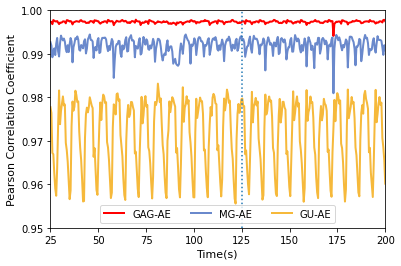

In [4]:
y_0,y_1,y_2=cc(input_, output_0, output_1, output_2)

In [6]:
import numpy as np
print(np.mean(y_0),np.mean(y_1),np.mean(y_2))

0.9973484862536413 0.9919341462650654 0.9717194088231387


In [5]:
def rmse_over_time(ori_data, rom_data_0, rom_data_1, rom_data_2):
    rmse_0 = rmse(ori_data, rom_data_0)
    rmse_1 = rmse(ori_data, rom_data_1)
    rmse_2 = rmse(ori_data, rom_data_2)
  
    # rmse_4 = rmse(ori_data, rom_data_4)
    # rmse_5 = rmse(ori_data, rom_data_5)
 
    # plt.figure(1)
    # x = np.linspace(5,8,600)

    fig, ax = plt.subplots()
    x = np.linspace(25+0,25+(0.5*rmse_0.shape[0]),rmse_0.shape[0])
    ax.set_prop_cycle(color = ['red','#6a89cc','#f6b93b'], linestyle = ['-', '-', '-'],linewidth=[2,2,2])
    # x = np.linspace(0,15,2875)
    y_0 = rmse_0
    y_1 = rmse_1
    y_2 = rmse_2
   
    # y_4 = rmse_4[-1800:-1200,:]
    # y_5 = rmse_5[-1800:-1200,:]
    # plt.title('Correlation Coefficient')
    ax.plot(x, y_0, x, y_1, x, y_2)
    # , x, rmse_4, linewidth = 0.6)
    # plt.xlim((-0.1, 200.1))# range
    plt.ylim((0, 0.042))
    plt.xlabel('Time(s)',{'size' : 11})
    plt.ylabel('RMSE',{'size' : 11})
    # plt.xticks(np.arange(0,200.1,25))
    # plt.yticks(np.arange(0,0.081,0.02))
    plt.legend(['GAG-AE', 'MG-AE', 'GU-AE'], loc='lower center',ncol=3)
    #plt.axis([50,400,0, 0.042])
    plt.axis([25,200,0, 0.042])
    plt.xticks([25, 50,75,100,125,150,175,200])
    plt.axvline(x=125,ls=":")
    plt.show()
    fig.savefig('/root/data1/bubble_duibishiyan/'+'RMSE.pdf', bbox_inches='tight')
    return y_0,y_1,y_2

2025-04-23 18:38:54.847283: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-23 18:38:55.475773: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3944 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:9b:00.0, compute capability: 8.9


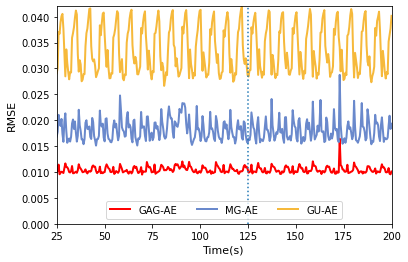

In [6]:
y_0,y_1,y_2=rmse_over_time(input_, output_0, output_1, output_2)

In [9]:
print(np.mean(y_0),np.mean(y_1),np.mean(y_2))

0.010430206 0.018156284 0.033759102


In [10]:
def acc(ori_data, rom_data):

    acc_value = []
    if len(ori_data) != len(rom_data):
        print('the length of these two array do not match')
    else:
        for i in range(len(rom_data)):
            ori=torch.Tensor(ori_data[i])
            rom=torch.Tensor(rom_data[i])
            value =torch.norm(ori- rom, p=2)/torch.norm(ori, p=2)
            
            if i == 0:
                acc_value = value
            else:
                acc_value = np.hstack((acc_value,value))
        acc_value = np.reshape(acc_value,(-1,1))
    return acc_value

In [11]:
acc0=acc(input_, output_0)
acc1=acc(input_, output_1)
acc2=acc(input_, output_2)
print(np.mean(acc0),np.mean(acc1),np.mean(acc2))

0.07248664 0.12611596 0.23473044


In [ ]:
from bubble_processing_duibishiyan import *

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
number_trajectories=1
for i in range(number_trajectories):
    data=torch.load('/root/data1/bubble_duibishiyan/GA_encode_decode_output1traj50200ts_vis.pt')
    print(len(data))#450
    print(data[0])
    satart_number_ts=50
    num=350
    originalFolder='/root/data1/water_slice_'+str(i)
    destinationFolder='/root/data1/bubble_duibishiyan/GA_bubble_dataset_EDoutput_'+str(i)
    fileName="/slice_"
    transform_vector(data, satart_number_ts,num, originalFolder, destinationFolder, fileName)

450
Data(x=[3351, 2], edge_index=[2, 19634], edge_attr=[19634, 3], cells=[6467, 3], mesh_pos=[3351, 2])
start to create the destination folder
start to store data as a new variable
transform succeed


In [ ]:
number_trajectories=1
for i in range(number_trajectories):
    data=torch.load('/root/data1/bubble_duibishiyan/model_1_encode_decode_output1traj50200ts_vis.pt')
    print(len(data))#450
    print(data[0])
    satart_number_ts=50
    num=350
    originalFolder='/root/data1/water_slice_'+str(i)
    destinationFolder='/root/data1/bubble_duibishiyan/model_1_bubble_dataset_EDoutput_'+str(i)
    fileName="/slice_"
    transform_vector(data, satart_number_ts,num, originalFolder, destinationFolder, fileName)

450
Data(x=[3351, 2], edge_index=[2, 19634], edge_attr=[19634, 3], cells=[6467, 3], mesh_pos=[3351, 2])
start to create the destination folder
start to store data as a new variable
transform succeed


In [ ]:
number_trajectories=1
for i in range(number_trajectories):
    data=torch.load('/root/data1/bubble_duibishiyan/model_2_encode_decode_output1traj50200ts_vis.pt')
    print(len(data))#450
    print(data[0])
    satart_number_ts=50
    num=350
    originalFolder='/root/data1/water_slice_'+str(i)
    destinationFolder='/root/data1/bubble_duibishiyan/model_2_bubble_dataset_EDoutput_'+str(i)
    fileName="/slice_"
    transform_vector(data, satart_number_ts,num, originalFolder, destinationFolder, fileName)

450
Data(x=[3351, 2], edge_index=[2, 19634], edge_attr=[19634, 3], cells=[6467, 3], mesh_pos=[3351, 2])
start to create the destination folder
start to store data as a new variable
transform succeed


In [ ]:
from bubble_processing_duibishiyan import *

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def point_over_time(ori_data,rom_data_0, rom_data_1, rom_data_2 ,j,start,ts):
        point = [0,150]
        x = np.linspace(125,125+int(point[1]*0.5),int(point[1]-point[0]))
        y_u=[]
        y_0_u=[]
        y_1_u=[]
        y_2_u=[]
        for i in range(ts):
            y_u.append(ori_data[start+i].x[j,0])
            y_0_u.append(rom_data_0[start+i].x[j,0])
            y_1_u.append(rom_data_1[start+i].x[j,0])
            y_2_u.append(rom_data_2[start+i].x[j,0])
        print(len(y_u))
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.set_prop_cycle(color = ['#2f3542','red','#6a89cc','#f6b93b'], linestyle = ['-','--', '--', '--'],linewidth=[4,2.5,2.5,2.5])
        
        ax.plot(x, y_u, x, y_0_u,x, y_1_u, x, y_2_u)

        plt.ylim((-0.35, 0.22))
       

        
        plt.xlabel('Time(s)')
        plt.ylabel('Liquid velocity (m/s)')
        plt.legend(['Full Model','GAG-AE', 'MG-AE', 'GU-AE'], loc='lower center',ncol=4)
        #plt.axis([250,400,-0.35, 0.22])
        #plt.xticks([250, 260, 280, 300, 320, 340, 360, 380, 400])
        plt.axis([125,200,-0.35, 0.22])
        plt.xticks([125, 150,175,200])
        fig.savefig('/root/data1/bubble_duibishiyan/'+str(j)+'velocity.pdf', bbox_inches='tight')
        plt.axis([130,150,-0.35, 0.22])
        plt.xticks([130, 140,150])
        fig.savefig('/root/data1/bubble_duibishiyan/'+str(j)+'-260-300velocity.pdf', bbox_inches='tight')

450


450
tensor([0.0542, 0.1445])
150


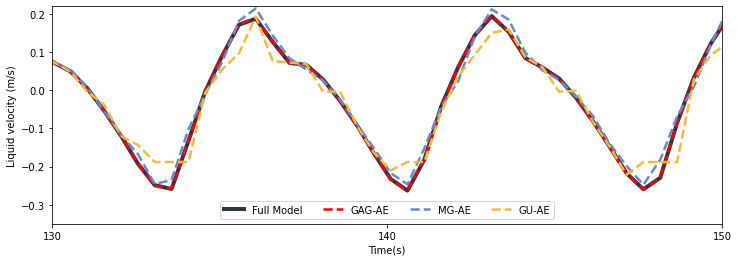

In [8]:
ED_out_0 = torch.load('/root/data1/bubble_duibishiyan/GA_encode_decode_output1traj50200ts_vis.pt') 
ED_out_1 = torch.load('/root/data1/bubble_duibishiyan/model_1_encode_decode_output1traj50200ts_vis.pt')
ED_out_2 = torch.load('/root/data1/bubble_duibishiyan/model_2_encode_decode_output1traj50200ts_vis.pt')

start=200
ts=150
ori=torch.load('/root/data1/bubble_EMD/meshgraphnets_miniset111traj50450ts_vis.pt')
print(len(ori))   #200
j=2700   #3351

print(ori[0].mesh_pos[j]) 
point_over_time(ori,ED_out_0,ED_out_1, ED_out_2 ,j,start,ts)

In [1]:
import torch
import vtk

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def vtk_vector(ori,data,i,destination_vtu_path_0):
    
    reader=vtk.vtkPolyDataReader()
    reader.SetFileName(destination_vtu_path_0)  # SetFileName设置要读取的vtk文件
    reader.ReadAllScalarsOn()
    reader.ReadAllVectorsOn()
    reader.ReadAllTensorsOn()
    reader.Update()

    vtkdata=reader.GetOutput()  # GetOutput获取文件的数据
    num_points=vtkdata.GetNumberOfPoints() 
    point_data =vtkdata.GetPointData()
    
    #a=ori[i].x-data[i].x
    a=data[i].x
    print(a.shape)
    a=a.to('cpu')
    a=a.numpy()
    
    velocity_array = point_data.GetArray('U.water')
        #print(velocity_array.GetTuple(0)[0:2])
    for j in range(num_points):
            original_velocity = list(velocity_array.GetTuple(j))
            original_velocity[0:2]=tuple(a[j])
            velocity_array.SetTuple(j, original_velocity)

    writer = vtk.vtkGenericDataObjectWriter()
    writer.SetFileName(destination_vtu_path_0)
    writer.SetInputData(vtkdata)
    writer.Write()
       
    print('transform succeed')

In [3]:
import shutil
 
def copy_vtk_file(source_path, destination_path):
    shutil.copy2(source_path, destination_path)
 
# 使用方法
t=280  #0-110
satart_number_ts=50
source_vtu_path = '/root/data1/water_slice_0/slice_' + str(t+satart_number_ts)+ ".vtk"

In [4]:
ED_out_0 = torch.load('/root/data1/bubble_duibishiyan/GA_encode_decode_output1traj50200ts_vis.pt') 
ED_out_1 = torch.load('/root/data1/bubble_duibishiyan/model_1_encode_decode_output1traj50200ts_vis.pt')
ED_out_2 = torch.load('/root/data1/bubble_duibishiyan/model_2_encode_decode_output1traj50200ts_vis.pt')
ori=torch.load('/root/data1/bubble_EMD/meshgraphnets_miniset111traj50450ts_vis.pt')

In [5]:
destination_vtu_path_0 = '/root/data1/bubble_duibishiyan/ae_GA_slice_' + str(t+satart_number_ts)+ ".vtk"
destination_vtu_path_1 = '/root/data1/bubble_duibishiyan/ae_model_1_slice_' + str(t+satart_number_ts)+ ".vtk"
destination_vtu_path_2 = '/root/data1/bubble_duibishiyan/ae_model_2_slice_' + str(t+satart_number_ts)+ ".vtk"
copy_vtk_file(source_vtu_path, destination_vtu_path_0)
copy_vtk_file(source_vtu_path, destination_vtu_path_1)
copy_vtk_file(source_vtu_path, destination_vtu_path_2)

vtk_vector(ori,ED_out_0,t,destination_vtu_path_0)
vtk_vector(ori,ED_out_1,t,destination_vtu_path_1)
vtk_vector(ori,ED_out_2,t,destination_vtu_path_2)

torch.Size([3351, 2])
transform succeed
torch.Size([3351, 2])
transform succeed
torch.Size([3351, 2])
transform succeed


训练时间序列模型

In [ ]:
import tensorflow.compat.v1 as tf
import torch
from STGCN import *
import scipy.sparse as sp

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
dataset_encode=torch.load('/root/data1/bubble_EMD/M_encode_output_01traj120050200ts_vis.pt')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_frame=31
n_his=30
n=dataset_encode[0].x.shape[0]
C0=dataset_encode[0].x.shape[1]
edge_index=dataset_encode[0].edge_index
data=seq_gen(dataset_encode,  n_frame)#(190,11,n,C)
n_train=150
n_val=20
Ks=3
Kt=5
batch_size=10
epoch=300
opt='RMSProp'
lr=1e-3
save_=5
blocks = [[C0, 64, 128], [128, 64, 128]]

inputs,x_stats=data_gen(data, n_train, n_val)

In [ ]:
print(inputs.get_data('train').shape)
print(inputs.get_data('val').shape)

torch.Size([150, 31, 1400, 32])
torch.Size([20, 31, 1400, 32])


In [ ]:
W = sp.coo_matrix((torch.ones(edge_index.shape[1]).to('cpu'), (edge_index[0, :].to('cpu'), edge_index[1, :].to('cpu'))), 
                                    shape=(n, n), dtype=np.float32)
W = W + W.T.multiply(W.T > W) - W.multiply(W.T > W)
print(W.shape)

(1400, 1400)


In [ ]:
W_dense = torch.tensor(W.toarray(), dtype=torch.float32)
L = scaled_laplacian(W_dense)
print(L.shape)

tensor(2.0000)
torch.Size([1400, 1400])


In [ ]:
Lk = cheb_poly_approx(L, Ks, n)

In [ ]:
print(Lk.shape)
tf.add_to_collection(name='graph_kernel', value=tf.cast(tf.constant(Lk), tf.float32))

(1400, 4200)


In [ ]:
model_train(inputs, n, n_his, Ks, Kt,batch_size, epoch,opt,blocks, C0,lr,save_,x_stats)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2024-11-21 15:10:15.392824: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 15:10:30.355659: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21051 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:53:00.0, compute capability: 8.6
2024-11-21 15:10:37.584912: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8202
2024-11-21 15:10:43.049561: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-21 15:10:44.198439: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. 

Epoch  0: MSE  8.251%; MAE  0.203; RMSE  0.287.
Epoch  5: MSE  1.167%; MAE  0.073; RMSE  0.108.
Epoch 10: MSE  0.362%; MAE  0.037; RMSE  0.060.
Epoch 15: MSE  0.236%; MAE  0.029; RMSE  0.049.
Epoch 20: MSE  0.199%; MAE  0.026; RMSE  0.045.
Epoch 25: MSE  0.183%; MAE  0.025; RMSE  0.043.
Epoch 30: MSE  0.175%; MAE  0.024; RMSE  0.042.
Epoch 35: MSE  0.172%; MAE  0.024; RMSE  0.041.
Epoch 40: MSE  0.170%; MAE  0.024; RMSE  0.041.
Epoch 45: MSE  0.169%; MAE  0.024; RMSE  0.041.
Epoch 50: MSE  0.169%; MAE  0.024; RMSE  0.041.
Epoch 55: MSE  0.169%; MAE  0.024; RMSE  0.041.
Epoch 60: MSE  0.169%; MAE  0.024; RMSE  0.041.
Epoch 65: MSE  0.169%; MAE  0.024; RMSE  0.041.
Epoch 70: MSE  0.169%; MAE  0.024; RMSE  0.041.
Epoch 75: MSE  0.169%; MAE  0.024; RMSE  0.041.
Epoch 80: MSE  0.169%; MAE  0.024; RMSE  0.041.
Epoch 85: MSE  0.169%; MAE  0.024; RMSE  0.041.
Epoch 90: MSE  0.169%; MAE  0.024; RMSE  0.041.
Epoch 95: MSE  0.169%; MAE  0.024; RMSE  0.041.
Epoch 100: MSE  0.169%; MAE  0.024; RMSE

In [ ]:
data_test=seq_gen(dataset_encode[0:n_frame],  n_frame)#[1,21,n,c0]
print(data_test.shape)
x_test = z_score(data_test, x_stats['mean'], x_stats['std'])
n_pred=320  #350-30
y_test=model_test(x_test, x_stats,  n_his, n_pred, load_path='/root/data1/bubble_duibishiyan/saved_model/')#逆标准化
print(y_test.shape)#(320,n,c0)

torch.Size([1, 31, 1400, 32])
INFO:tensorflow:Restoring parameters from /root/data1/bubble_duibishiyan/saved_model/model.ckpt


2024-11-21 15:21:09.364081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21051 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:53:00.0, compute capability: 8.6


>> Loading saved model from /root/data1/bubble_duibishiyan/saved_model/model.ckpt ...
(320, 1400, 32)
Testing model finished!
torch.Size([320, 1400, 32])


In [ ]:
torch.save(y_test,'/root/data1/bubble_duibishiyan/ST_320_pred')

In [ ]:
import copy
from  self_attention import *

import numpy as np
import random

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
a=torch.load('/root/data1/bubble_EMD/M_encode_output_01traj120050200ts_vis.pt')
edge_num=a[0].edge_attr.shape[0]
print(edge_num)    #14586
number_trajectories=1

3264


In [ ]:
data_1=[]
data_label_1=[]

for i in range(number_trajectories):
    dataset_encode=torch.load('/root/data1/bubble_EMD/M_encode_output_01traj120050200ts_vis.pt')
    per_t=11
    for j in range(len(dataset_encode)-per_t+1):
        for k in range(per_t):
            if k <(per_t-1):
                E_data  = copy.deepcopy(dataset_encode[j+k])
                E_data=E_data.to('cpu')
                data_1.append(E_data)
            else:
                E_data  = copy.deepcopy(dataset_encode[j+k])
                E_data=E_data.to('cpu')
                data_label_1.append(E_data)
                       
print(len(data_1))      #140*10
print(len(data_label_1))   #140

data_=data_1
data_label=data_label_1


1900
190


In [ ]:
device='cuda'
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d   
for args in [
        {'model_type': 'Multi-attention',
         
         'batchsize': 5,       #是lable上的batchsize
         'hidden_dim': 32,     #这里的hidden_dim与encode_decode中的hidden_channels相同
         'epochs': 1000,#5000
         
         'train_size':150, #45
         'test_size': 40, #10         #按照lable的来
         'device':'cuda',
         'shuffle': False,
         'save_best_model': True,
         'checkpoint_dir': '/root/data1/bubble_EMD/Multi-attention_best_models/',
         'postprocess_dir': '/root/data1/bubble_EMD/Multi-attention_loss_plots/',
         'd_k': 28,#28
         'd_v': 28,
         'input_shape': 12,   #加上时间信息，所以比n_graph_encode的最后一个多两维
         'n_heads': 6,
         'n_layers': 5,
         'ff_dim': 64,
         'seq_len': 10,        #改per_t-1,二推一
         'per_t':11,
         
        'n_graph_encode':[500,150,80,10],
        'pool_num':[2700,2000,1400]},
]:
        args = objectview(args)
torch.manual_seed(5)  #Torch
random.seed(5)        #Python
np.random.seed(5)     #NumPy
torch.cuda.manual_seed_all(5)   #GPU

cuda


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training:   0%|          | 1/1000 [00:05<1:30:18,  5.42s/Epochs]

train loss 0.954905 test loss 1.113865


Training:  10%|█         | 101/1000 [04:43<53:59,  3.60s/Epochs]

train loss 0.025073 test loss 0.022302


Training:  20%|██        | 201/1000 [09:24<44:37,  3.35s/Epochs]

train loss 0.018278 test loss 0.01691


Training:  30%|███       | 301/1000 [14:06<36:40,  3.15s/Epochs]

train loss 0.015847 test loss 0.011502


Training:  40%|████      | 401/1000 [18:44<33:50,  3.39s/Epochs]

train loss 0.014417 test loss 0.010111


Training:  50%|█████     | 501/1000 [23:26<26:22,  3.17s/Epochs]

train loss 0.012704 test loss 0.010662


Training:  60%|██████    | 601/1000 [28:21<25:29,  3.83s/Epochs]

train loss 0.014364 test loss 0.011293


Training:  70%|███████   | 701/1000 [33:37<18:33,  3.72s/Epochs]

train loss 0.015465 test loss 0.010333


Training:  80%|████████  | 801/1000 [38:41<12:36,  3.80s/Epochs]

train loss 0.012034 test loss 0.008884


Training:  86%|████████▌ | 858/1000 [41:29<07:10,  3.03s/Epochs]

Epoch   858: reducing learning rate of group 0 to 5.0000e-05.


Training:  90%|█████████ | 901/1000 [43:42<05:34,  3.38s/Epochs]

train loss 0.011374 test loss 0.00978


Training: 100%|██████████| 1000/1000 [48:57<00:00,  2.94s/Epochs]

Min test set loss: 0.008075340650975704
Minimum loss: 0.009888516925275325


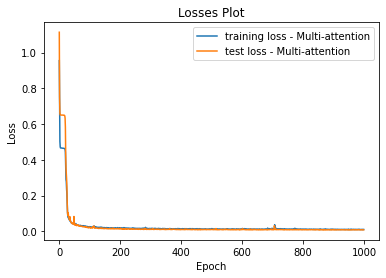

In [ ]:
data_stats_list=torch.load('/root/data1/bubble_EMD/data_stats_list.pt')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.device = device
print(device)

test_losses, losses, best_model,best_test_loss =Mulit_attention_train(data_,data_label, device,data_stats_list, args,edge_num)
print("Min test set loss: {0}".format(min(test_losses)))
print("Minimum loss: {0}".format(min(losses)))

save_plots(args, losses, test_losses)

In [ ]:
per_t=1     
data_encode=torch.load('/root/data1/bubble_EMD/M_encode_output_01traj120050200ts_vis.pt')
print(len(data_encode))
data=copy.deepcopy(data_encode[0:10])
a=copy.deepcopy(data_encode[0])
print(a)

200
Data(x=[1400, 32], edge_index=[2, 3264], edge_attr=[3264, 32])


In [ ]:
model_name='Multi-attention_model_nl'+'_bs'+str(args.batchsize) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd' + \
               '_shuff_'+str(args.shuffle)+'_dk'+str(args.d_k)+'_heads'+str(args.n_heads)
args.batchsize=1
node_model = self_transformer(args,edge_num).to(device)
node_model.load_state_dict(torch.load('/root/data1/bubble_EMD/Multi-attention_best_models/'+model_name+'.pt'))

EDstats_list=torch.load('/root/data1/bubble_EMD/EDstats_list.pt')
data_stats_list=torch.load('/root/data1/bubble_EMD/data_stats_list.pt')
[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))
[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge] = data_stats_list
(mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)=(mean_vec_x.to(device),std_vec_x.to(device),
                                                   mean_vec_edge.to(device),std_vec_edge.to(device))

In [ ]:
def predict_sequences_multiple(model, data, a, predict_num,seq_len):

        print('[Model] Predicting Sequences Multiple...')
        a=a.to(device)
        code_index=a.edge_index
        for i in range(predict_num):
          list_p = data[:] if i == 0 else data[i:]
          data_loader=DataLoader(list_p, batch_size=seq_len, shuffle=False) 
          for i,batch in enumerate(data_loader):
              batch=batch.to(device)
              code_x,code_edge_attr = Mulit_attention_pred(batch,model,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
          
          new_data=Data(x=code_x, edge_index=code_index, edge_attr=code_edge_attr)
          data.append(new_data)

        return data

In [ ]:
predict_num=340#350-10
seq_len=10
data=predict_sequences_multiple(node_model, data, a, predict_num,seq_len)
print(len(data))  #60

[Model] Predicting Sequences Multiple...


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


350


In [ ]:
torch.save(data,'/root/data1/bubble_duibishiyan/MultiAttention_350_pred')

还原

In [ ]:
from d_TAP_MP_Attention import *

In [ ]:
import torch

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
data_GA=torch.load('/root/data1/bubble_duibishiyan/GA_350_pred')
y_test=torch.load('/root/data1/bubble_duibishiyan/ST_320_pred')

In [ ]:
print(data_GA[0])
print(len(data_GA))
print(len(y_test))
print(y_test[0].shape)

Data(x=[1400, 32], edge_index=[2, 3264], edge_attr=[3264, 32])
350
320
torch.Size([1400, 32])


In [ ]:
import copy

In [ ]:
device='cuda'
y_ST=copy.deepcopy(data_GA)
for i in range(int(len(data_GA)-30)):
    y_ST[i+30].x=y_test[i,:,:].to(device)

In [ ]:
data_list=torch.load('/root/data1/bubble_EMD/M_encode_output_01traj120050200ts_vis.pt')

In [ ]:
print(data_list[0])

Data(x=[1400, 32], edge_index=[2, 3264], edge_attr=[3264, 32])


In [ ]:
for i in range(30):
    y_ST[i]=data_list[i]

In [ ]:
#data=torch.load('/root/data1/bubble_duibishiyan/GA_350_pred')
data=y_ST
#data=torch.load('/root/data1/bubble_duibishiyan/MultiAttention_350_pred')

In [ ]:
i=0
device='cuda'
number_trajectories=1
dataset_dir = '/root/data1/bubble_EMD'
batches=torch.load(dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'batches.pt')
xs=torch.load(dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'xs.pt')
positions=torch.load( dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'positions.pt')
edge_attrs=torch.load( dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_attrs.pt')
edge_indices=torch.load( dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_indices.pt')
edge_masks=torch.load(dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_masks.pt')
EDstats_list=torch.load('/root/data1/bubble_EMD/EDstats_list.pt')

[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))



perm_list=torch.load(dataset_dir+'/perm_list_150.pt')

in_channels_node = 2  #2
in_channels_edge = 3  #3
hidden_channels = 32    #22#12
out_channels = in_channels_node
batch_size =25       #改
n_mlp_encode = 4
n_mlp_mp = 6#5
encoding_dim=32
ae_dim=[300,128,64,32]#[128,64,32,16,10]
n_mp_down = [2,2,1,1]
n_mp_up= [1,1,2,2]
pool_num =[2700,2000,1400]#[2000,1500,1200,1000][2000,1600,1400,1000]

act = F.elu
param_sharing = False
pathD='/root/data1/bubble_EMD/Decode_state_dict.pt'



decode_model=GNN_Decode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
decode_model.load_state_dict(torch.load(pathD), strict=False)
decode_model.to(device)

pred_x=[]
with torch.no_grad():
        for i in range(len(data)):
              x=decode_model(data[i], batches , xs, positions, edge_attrs, edge_indices, edge_masks,perm_list[0])
              x=x*EDstd_vec_x+EDmean_vec_x
              pred_x.append(x)

              
print(len(pred_x))

350


In [ ]:
#torch.save(pred_x,'/root/data1/bubble_duibishiyan'+'/GAROM-350.pt')
torch.save(pred_x,'/root/data1/bubble_duibishiyan'+'/STROM-350.pt')
#torch.save(pred_x,'/root/data1/bubble_duibishiyan'+'/Multi-attention-ROM-350.pt')

In [9]:
def pearson_value(ori_data, rom_data):
    # print(ori_data.shape)
    # print(len(ori_data))
    pearson_value = []
    if len(ori_data) != len(rom_data):
        print('the length of these two array do not match')
    else:
        for i in range(len(rom_data)):
            row_1 = np.reshape(ori_data[i],(-1,1))
            row_2 = np.reshape(rom_data[i],(-1,1))
            data = np.hstack((row_1,row_2))
            df = pd.DataFrame(data=data[0:,0:],columns=['11','22'])
            pearson = df.corr() # pearson cc  # 
            # pearson = data.corr('spearman') # spearman cc  
            pear_value=pearson.iloc[0:1,1:2]
            value = pear_value.values
            if i == 0:
                pearson_value = value
            else:
                pearson_value = np.hstack((pearson_value,value)) 
        pearson_value = np.reshape(pearson_value,(-1,1))
    return np.array(pearson_value)


def cc(ori_data, rom_data_0, rom_data_1, rom_data_2):
    pcc_0 = pearson_value(ori_data, rom_data_0)
    pcc_1 = pearson_value(ori_data, rom_data_1)
    pcc_2 = pearson_value(ori_data, rom_data_2)
    fig, ax = plt.subplots()
    x = np.linspace(25+0,25+0.5*pcc_0.shape[0],pcc_0.shape[0])
    print(pcc_0.shape, pcc_1.shape)
    ax.set_prop_cycle(color = ['red','#6a89cc','#f6b93b'], linestyle = ['-', '-', '-'],linewidth=[2,2,2])
    y_0 = pcc_0
    y_1 = pcc_1
    y_2 =pcc_2
   
    ax.plot(x, y_0, x, y_1, x, y_2)
     
            # plt.xlim((-0.1, 200.1))# range
    plt.ylim((0.7, 1))
    plt.xlabel('Time(s)',{'size' : 11})
    plt.ylabel('Pearson Correlation Coefficient',{'size' : 11})
            # plt.xticks(np.arange(0,200.1,25))
            # plt.yticks(np.arange(0.97,1.0001,0.01))
            # plt.legend(['D4:AE+TF', 'D8:AE+TF', 'D12:AE+TF', 'D4:PCA+TF', 'D8:PCA+TF', 'D12:PCA+TF'], loc='lower right')   
    plt.legend(['MRROM','GAG-AE+STGCN', 'GAG-AE+MHSA'], loc='lower center',ncol=3)   
    plt.axis([25,200,0.8, 1])
    plt.xticks([25, 50,75,100,125,150,175,200])
    plt.axvline(x=125,ls=":",color='black')

    plt.show()
    fig.savefig('/root/data1/bubble_duibishiyan/'+'ROM-Pcc.pdf', bbox_inches='tight')
    return y_0,y_1,y_2

In [10]:
import numpy as np
import meshio
import torch
import tensorflow.compat.v1 as tf
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import pandas as pd
import os
import time
from IPython.lib.display import isdir
import random
import matplotlib.pyplot as plt
import copy
from matplotlib import tri as mtri
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [11]:
ED_out_0 = torch.load('/root/data1/bubble_duibishiyan/GAROM-350.pt') 
ED_out_1 = torch.load('/root/data1/bubble_duibishiyan/STROM-350.pt')
ED_out_2 = torch.load('/root/data1/bubble_duibishiyan/Multi-attention-ROM-350.pt')

number_ts=350
ori=torch.load('/root/data1/bubble_EMD/meshgraphnets_miniset111traj50450ts_vis.pt')
print(len(ori))   #200


for i in range(number_ts):
    
    uvw_0=ED_out_0[i].reshape(1,ED_out_0[i].shape[0],ED_out_0[i].shape[1]).to('cpu')
    uvw_1=ED_out_1[i].reshape(1,ED_out_1[i].shape[0],ED_out_1[i].shape[1]).to('cpu')
    uvw_2=ED_out_2[i].reshape(1,ED_out_2[i].shape[0],ED_out_2[i].shape[1]).to('cpu')
    
    ouvw=ori[i].x.reshape(1,ori[i].x.shape[0],ori[i].x.shape[1])
    outputs_0 = uvw_0 if i==0 else np.vstack((outputs_0,uvw_0))
    outputs_1 = uvw_1 if i==0 else np.vstack((outputs_1,uvw_1))
    outputs_2 = uvw_2 if i==0 else np.vstack((outputs_2,uvw_2))
    inputs=ouvw if i==0 else np.vstack((inputs,ouvw))

output_0 = np.hstack((outputs_0[:,:,0],outputs_0[:,:,1]))
output_1 = np.hstack((outputs_1[:,:,0],outputs_1[:,:,1]))
output_2 = np.hstack((outputs_2[:,:,0],outputs_2[:,:,1]))
input_ = np.hstack((inputs[:,:,0],inputs[:,:,1]))
print(output_0.shape,output_1.shape,output_2.shape,input_.shape)



450
(350, 6702) (350, 6702) (350, 6702) (350, 6702)


(350, 1) (350, 1)


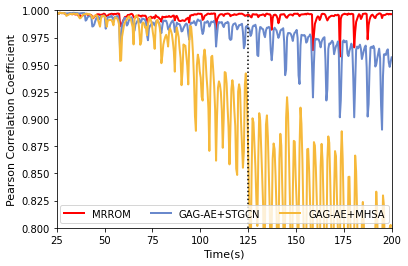

In [12]:
y_0,y_1,y_2=cc(input_, output_0, output_1, output_2)

In [7]:
print(np.mean(y_0),np.mean(y_1),np.mean(y_2))

0.9946016129837469 0.97857235273697 0.8973438843125849


In [8]:
import math
from keras import backend as K

In [13]:
def root_mean_squared_error(true, pred):
    return K.mean(K.square(pred - true))
def rmse(ori_data, rom_data):

    rmse_value = []
    if len(ori_data) != len(rom_data):
        print('the length of these two array do not match')
    else:
        for i in range(len(rom_data)):
            value = np.sqrt(root_mean_squared_error(ori_data[i], rom_data[i]))
            if i == 0:
                rmse_value = value
            else:
                rmse_value = np.hstack((rmse_value,value))
        rmse_value = np.reshape(rmse_value,(-1,1))
    return rmse_value
def rmse_over_time(ori_data, rom_data_0, rom_data_1, rom_data_2):
    rmse_0 = rmse(ori_data, rom_data_0)
    rmse_1 = rmse(ori_data, rom_data_1)
    rmse_2 = rmse(ori_data, rom_data_2)
  
    # rmse_4 = rmse(ori_data, rom_data_4)
    # rmse_5 = rmse(ori_data, rom_data_5)
 
    # plt.figure(1)
    # x = np.linspace(5,8,600)

    fig, ax = plt.subplots()
    x = np.linspace(25,25+0.5*rmse_0.shape[0],rmse_0.shape[0])
    ax.set_prop_cycle(color = ['red','#6a89cc','#f6b93b'], linestyle = ['-', '-', '-'],linewidth=[2,2,2])
    # x = np.linspace(0,15,2875)
    y_0 = rmse_0
    y_1 = rmse_1
    y_2 = rmse_2
   
    # y_4 = rmse_4[-1800:-1200,:]
    # y_5 = rmse_5[-1800:-1200,:]
    # plt.title('Correlation Coefficient')
    ax.plot(x, y_0, x, y_1, x, y_2)
    # , x, rmse_4, linewidth = 0.6)
    # plt.xlim((-0.1, 200.1))# range
    plt.ylim((0, 0.15))
    plt.xlabel('Time(s)',{'size' : 11})
    plt.ylabel('RMSE',{'size' : 11})
    # plt.xticks(np.arange(0,200.1,25))
    # plt.yticks(np.arange(0,0.081,0.02))
   
    plt.legend(['MRROM','GAG-AE+STGCN', 'GAG-AE+MHSA'], loc='upper center',ncol=3)   
    plt.axis([25,200,0, 0.15])
    plt.xticks([25, 50,75,100,125,150,175,200])
    plt.axvline(x=125,ls=":",color='black') 
    plt.show()
    fig.savefig('/root/data1/bubble_duibishiyan/'+'ROM-RMSE.pdf', bbox_inches='tight')
    return y_0,y_1,y_2

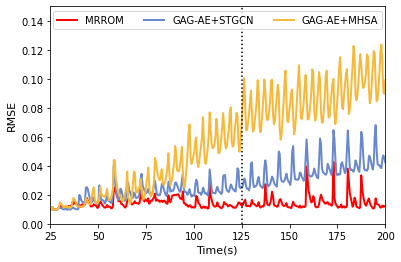

In [14]:
y_0,y_1,y_2=rmse_over_time(input_, output_0, output_1,output_2)

In [11]:
print(np.mean(y_0),np.mean(y_1),np.mean(y_2))

0.014380284 0.027638717 0.05637806


In [12]:
print(np.mean(y_0[0:50]),np.mean(y_0[300:350]),np.mean(y_1[0:50]),np.mean(y_1[300:350]),np.mean(y_2[0:50]),np.mean(y_2[300:350]))

0.012449375 0.014710692 0.013224213 0.0428695 0.013367222 0.099488884


In [3]:
def acc(ori_data, rom_data):

    acc_value = []
    if len(ori_data) != len(rom_data):
        print('the length of these two array do not match')
    else:
        for i in range(len(rom_data)):
            ori=torch.Tensor(ori_data[i])
            rom=torch.Tensor(rom_data[i])
            value =torch.norm(ori- rom, p=2)/torch.norm(ori, p=2)
            
            if i == 0:
                acc_value = value
            else:
                acc_value = np.hstack((acc_value,value))
        acc_value = np.reshape(acc_value,(-1,1))
    return acc_value

In [4]:
acc0=acc(input_, output_0)
acc1=acc(input_, output_1)
acc2=acc(input_, output_2)
print(np.mean(acc0),np.mean(acc1),np.mean(acc2))

0.099804536 0.19182432 0.39236355


In [15]:
def point_over_time(ori_data,rom_data_0, rom_data_1, rom_data_2 ,j,start,ts):
        point = [0,ts]
        x = np.linspace(125,125+point[1]*0.5,int(point[1]-point[0]))
        y_u=[]
        y_0_u=[]
        y_1_u=[]
        y_2_u=[]
        for i in range(ts):
            y_u.append(ori_data[start+i].x[j,0])
            y_0_u.append(rom_data_0[start+i][j,0].to('cpu'))
            y_1_u.append(rom_data_1[start+i][j,0].to('cpu'))
            y_2_u.append(rom_data_2[start+i][j,0].to('cpu'))
        print(len(y_u))
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.set_prop_cycle(color = ['#2f3542','#ff6b81','#6a89cc','#f6b93b'], linestyle = ['-','--', '--', '--'],linewidth=[4,2,2,2])
        
        ax.plot(x, y_u, x, y_0_u,x, y_1_u, x, y_2_u)

        plt.ylim((-0.04, 0.05))
       

        
        plt.xlabel('Time(s)')
        plt.ylabel('Liquid velocity (m/s)')
        
        plt.legend(['Full Model','MRROM','GAG-AE+STGCN', 'GAG-AE+MHSA'], loc='upper center',ncol=4)   
        plt.axis([125,200,-0.04, 0.05])
        plt.xticks([125, 150, 175,200])
        plt.show()
        fig.savefig('/root/data1/bubble_duibishiyan/ROM'+str(j)+'velocity.pdf', bbox_inches='tight')

In [14]:
ED_out_0 = torch.load('/root/data1/bubble_duibishiyan/GAROM-350.pt') 
ED_out_1 = torch.load('/root/data1/bubble_duibishiyan/STROM-350.pt')
ED_out_2 = torch.load('/root/data1/bubble_duibishiyan/Multi-attention-ROM-350.pt')

450
tensor([0.1053, 0.5056])
150


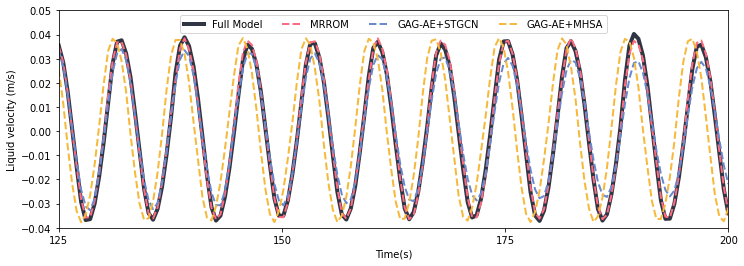

In [16]:
start=200
ts=150
ori=torch.load('/root/data1/bubble_EMD/meshgraphnets_miniset111traj50450ts_vis.pt')
print(len(ori))   #200
j=2000   #3351

print(ori[0].mesh_pos[j]) 
point_over_time(ori,ED_out_0,ED_out_1, ED_out_2 ,j,start,ts)